<h1 style="background-color:black; color:white; padding:10px;">
    Notebook 07 - Experimentos com pré-processamento e seleção de variáveis
</h1>

Experimentos com PyCaret realizados em Servidor CentOS Linux 7 - 64 bits, 128 GB RAM, 32 processadores Intel Xeon E5-2620 v4 (2.10GHz, 8 núcleos, 16 threads).

<hr style="background-color:transparent;height:4px;border:none;border-top:2px solid #c0c0c0;border-bottom:2px solid #c0c0c0;">

### Definições iniciais

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Habilitação de recarga de módulo editado.

In [2]:
%load_ext autoreload
%autoreload 2

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Pacotes de uso geral.

In [3]:
import sys
# import pycaret    # instalado com: pip install pycaret
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from pycaret.regression import *
from IPython.display import Markdown

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Ajuste para módulos em diretórios fora de `sys.path`.

In [4]:
# servidor Linux
p_user = Path('~').expanduser()
nm_dir_tcc = 'jup_ws/tcc'
p_tcc = p_user / nm_dir_tcc
sys.path.append(str(p_tcc))

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Módulos em diretórios fora de `sys.path`.

In [5]:
import tcc
from pd_utils import (
    d_pd, exemplo_linha, resumo_tipos, resumo_categ, resumo_serie,
    DisplayPandas, ExemploLinha, ResumoTipos, ResumoCateg, ResumoSerie
)

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Utilidades de exibição e resumo de objetos `pandas`.

In [6]:
# índice do primeiro elemento True de uma série boleana
# prim_true = lambda sr: sr[lambda s: s].index[0]

In [7]:
# índice do ultimo elemento True de uma série boleana
# ulti_true = lambda sr: sr[lambda s: s].index[-1]

In [8]:
# primeiro item, 4 items intermediárias, item final e dimensões de objeto pandas
# h1s4t1 = DisplayPandas(head=1, sample=4, tail=1)

In [9]:
# primeiro item, 1 items intermediário, item final e dimensões de objeto pandas
h1s1t1 = DisplayPandas(head=1, sample=1, tail=1)

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Outras definições.

In [10]:
d = display
pdod = pd.options.display
pdoc = pd.option_context
pdod.precision = 2
pdod.max_columns = None

def print_expr(expr, sep='=', inv=False):
    if inv:
        print(f'{eval(expr)} {sep} {expr}')
    else:
        print(f'{expr} {sep} {eval(expr)}')

def print_rslt(expr, sep='-->', inv=True):
    print_expr(expr, sep, inv)

def teste_features(todas, alvo, cate, nume, igno):
    def p_r(e):
        nonlocal todas, alvo, cate, nume, igno
        print(f'{eval(e)} --> {e}')
    p_r( 'set(cate).isdisjoint( set(nume) )' )
    p_r( 'set(nume).isdisjoint( set(igno) )' )
    p_r( 'set(igno).isdisjoint( set(cate) )' )
    p_r( 'alvo not in ( set(cate) | set(nume) | set(igno) )' )
    p_r( 'set(todas) == ( {alvo} | set(cate) | set(nume) | set(igno) )' )

def d_dct(dct, tit_chave='chave', tit_valor='valor'):
    txt_md = f'{tit_chave}|{tit_valor}\n:--|:--'
    for chave, valor in dct.items():
        txt_md += f'\n{chave}|{valor!r}'
    display(Markdown(txt_md))

def salvar_experi(best_models):
    nomes = []
    data_hora = f'{datetime.now():%Y%m%d_%H%M%S}'
    nome = f'{data_hora}.pkl'
    save_config(nome)
    nomes.append(nome)
    for ind, model in enumerate(best_models, 1):
        nome = f'{data_hora}_{ind}_{model.__class__.__name__}'
        save_model(model, nome)
        nomes.append(nome)
    return nomes

<hr style="background-color:transparent;height:4px;border:none;border-top:2px solid #c0c0c0;border-bottom:2px solid #c0c0c0;">

### Importação de `df_vendas_bricks`

- Dataframe consolidado de vendas das peças de interesse com modificações do notebook 05 (arquivo `df_vendas_bricks_nb5.parquet`).
- Colunas do dataframe:
<table>
<tr><th style="text-align:left;">Grupo</th><th>Coluna</th><th>Descrição</th></tr>
<tr style="border-top:1px solid black;"><td rowspan=9 style="text-align:left;">Variáveis da linha de pedido (o = order):</td><td><code>o_itid</code></td><td>ID arbitrário da linha de pedido de peça</td></tr>
<tr><td><code>p_no</code></td><td>código do modelo da peça</td></tr>
<tr><td><code>c_id</code></td><td>código/ID da cor da peça</td></tr>
<tr><td><code>n_u</code></td><td>estado da peça</td></tr>
<tr><td><code>o_qtty</code></td><td>quantidade</td></tr>
<tr><td><code>o_unpr</code></td><td>preço unitário em USD</td></tr>
<tr><td><code>o_sctr</code></td><td>país do vendedor</td></tr>
<tr><td><code>o_bctr</code></td><td>país do comprador</td></tr>
<tr><td><code>o_dthr</code></td><td>data e hora do pedido</td></tr>
<tr style="border-top:1px solid black;"><td rowspan=5 style="text-align:left;">Características físicas da peça comercializada (p = part)</td><td><code>p_wt</code></td><td>peso/massa em gramas</td></tr>
<tr><td><code>p_dx</code></td><td>largura em studs</td></tr>
<tr><td><code>p_dy</code></td><td>comprimento em studs</td></tr>
<tr><td><code>p_dz</code></td><td>altura em bricks</td></tr>
<tr><td><code>p_dv</code></td><td>volume externo em studs cúbicos</td></tr>
<tr style="border-top:1px solid black;"><td rowspan=3 style="text-align:left;">Outros atributos da peça comercializada (p = part)</td><td><code>p_nm</code></td><td>nome do modelo de peça</td></tr>
<tr><td><code>p_pfx</code></td><td>prefixo do código de modelo</td></tr>
<tr><td><code>p_sfx</code></td><td>sufixo do código de modelo</td></tr>
<tr style="border-top:1px solid black;"><td rowspan=3 style="text-align:left;">Atributos da cor da peça comercializada (c = color)</td><td><code>c_nm</code></td><td>nome da cor</td></tr>
<tr><td><code>c_cd</code></td><td>código da cor (RGB 24 bits hexadecimal)</td></tr>
<tr><td><code>c_tp</code></td><td>tipo/família da cor</td></tr>
<tr style="border-top:1px solid black;"><td rowspan=3 style="text-align:left;">Métricas calculadas da linha do pedido (o = order):</td><td><code>o_ttpr</code></td><td>preço total em USD <code>o_qtty * o_unpr</code></td></tr>
<tr><td><code>o_ttwt</code></td><td>peso/massa total em gramas <code>o_qtty * p_wt</code></td></tr>
<tr><td><code>o_ttdv</code></td><td>volume externo total em studs cúbicos <code>o_qtty * p_dv</code></td></tr>
<tr style="border-top:1px solid black;"><td rowspan=2 style="text-align:left;">Categorias calculadas (grp = grupo):</td><td><code>grp_dim</code></td><td>grupo de peças com mesmas dimensões externas</td></tr>
<tr><td><code>grp_cor</code></td><td>grupo de cores adaptado do Studio 2.0</td></tr>
</table>

In [11]:
nms_cols = [
    'p_no', 'c_id', 'n_u', 'o_qtty', 
    'o_unpr',    # variável alvo
    'o_sctr', 'o_bctr', 
    'o_dthr',    # aspecto temporal será ignorado (descartar)
    'p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 
    'p_nm',    # descrição de `p_no` (descartar)
    'p_pfx', 'p_sfx',    # fragmentos de `p_no` (descartar)
    'c_nm',    # `c_nm` é descrição de `c_id` (descartar)
    'c_cd',    # `c_cd` como RGB hexadec texto não é útil (descartar)
    'c_tp', 
    'o_ttpr',    # métrica calculada com variável target (descartar)
    'o_ttwt', 'o_ttdv', 'grp_dim', 
    'grp_cor',    # grupos formados não refletem preços (descartar)
]    # nova ordem das colunas
df_vendas_bricks = (
    pd.read_parquet(tcc.pckl_df_vendas_bricks_nb5.with_suffix('.parquet'))
    [nms_cols]
)
h1s1t1(df_vendas_bricks)    # primeira linha, linha aleatória, última linha e dimensões

,p_no,c_id,n_u,o_qtty,o_unpr,o_sctr,o_bctr,o_dthr,p_wt,p_dx,p_dy,p_dz,p_dv,p_nm,p_pfx,p_sfx,c_nm,c_cd,c_tp,o_ttpr,o_ttwt,o_ttdv,grp_dim,grp_cor
o_itid,,,,,,,,,,,,,,,,,,,,,,,,
40646,3005,80,N,20,0.10,DE,GB,2021-02-01 00:14:32.880,0.44,1.0,1.0,1.0,1.2,Brick 1 x 1,3005,,80,2e5543,solid,1.94,8.80,24.0,1x1x1,12
978772,3010,85,U,2,0.22,DE,DE,2021-05-30 12:18:38.243,1.64,1.0,4.0,1.0,4.8,Brick 1 x 4,3010,,85,595d60,solid,0.43,3.28,9.6,1x4x1,-1
770553,6213,6,U,2,6.06,DE,IL,2021-04-30 07:33:47.810,10.18,2.0,6.0,3.0,43.2,Brick 2 x 6 x 3,6213,,6,00642e,solid,12.12,20.36,86.4,2x6x3,12


(1291936, 24)

<hr style="background-color:transparent;height:4px;border:none;border-top:2px solid #c0c0c0;border-bottom:2px solid #c0c0c0;">

### D - Experimento de referência

<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### D.1 - *Dataset* completo, *train size* de 60%, 5 variáveis categóricas, 8 variáveis numéricas, SEM outras opções de pré-processamento

- Repetição do experimento C.3 do notebook 6, com captura de informações do resultado do pré-processamento.
- 5 variáveis categóricas, 8 variáveis numéricas.
- *Dataset* original com dimensões (1291936, 24).
- *Train set* processado com dimensões (775161, 349).
- Opções padrão do PyCaret para pré-processamento e treinamento, exceto:
    - *cross validation* com 5 *folds* ;
    - conjunto reduzido de modelos com melhores desempenhos nos experimentos anteriores .
- Principais parâmetros do experimento no quadro resumo abaixo.

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Escolha, classificação e conferência das variáveis.

In [16]:
target = 'o_unpr'
categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]
numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv', ]
ignore_features = [
    'grp_cor', 'c_tp', 'grp_dim', # cat
    # num
    'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr', # sempre
]
teste_features(df_vendas_bricks.columns, target, 
               categorical_features, numeric_features, ignore_features)

True --> set(cate).isdisjoint( set(nume) )
True --> set(nume).isdisjoint( set(igno) )
True --> set(igno).isdisjoint( set(cate) )
True --> alvo not in ( set(cate) | set(nume) | set(igno) )
True --> set(todas) == ( {alvo} | set(cate) | set(nume) | set(igno) )


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [20]:
include = ['et','rf','gbr','dt','lightgbm','ridge']
dct_compare_models = dict(n_select=3, include=include)

dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5, 
)

In [21]:
%%time
cfg_regress = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 349)"


CPU times: user 51 s, sys: 21.8 s, total: 1min 12s
Wall time: 50.9 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [22]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5

parâmetro compare_models|valor
:--|:--
n_select|3
include|['et', 'rf', 'gbr', 'dt', 'lightgbm', 'ridge']

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [23]:
%%time
best_models = compare_models(**dct_compare_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0479,0.0741,0.2705,0.7208,0.0704,0.3966,443.0580
et,Extra Trees Regressor,0.0494,0.0742,0.2722,0.7081,0.0732,0.4067,731.0160
dt,Decision Tree Regressor,0.0517,0.0891,0.2981,0.6436,0.0771,0.4206,16.4560
gbr,Gradient Boosting Regressor,0.0755,0.1264,0.3534,0.5223,0.0999,0.7795,110.5200
lightgbm,Light Gradient Boosting Machine,0.0604,0.1731,0.4091,0.3667,0.0856,0.5323,3.2660
ridge,Ridge Regression,0.0780,0.2001,0.4430,0.2547,0.1020,0.7143,1.3800


CPU times: user 13h 17min 44s, sys: 2min 31s, total: 13h 20min 16s
Wall time: 2h 18min 53s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Salvamento das configurações e dos modelos do experimento de referência. 
- Conferência da existência dos arquivos salvos.

In [53]:
salvar_experi(best_models)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


['20211217_161835.pkl',
 '20211217_161835_1_RandomForestRegressor',
 '20211217_161835_2_ExtraTreesRegressor',
 '20211217_161835_3_DecisionTreeRegressor']

In [54]:
list(Path().glob('20211217_161835*.pkl'))

[PosixPath('20211217_161835.pkl'),
 PosixPath('20211217_161835_1_RandomForestRegressor.pkl'),
 PosixPath('20211217_161835_2_ExtraTreesRegressor.pkl'),
 PosixPath('20211217_161835_3_DecisionTreeRegressor.pkl')]

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Gráficos de importância de variáveis do *Random Forest Regressor*, modelo de melhor desempenho segundo $R^2$, armazenado na variável `rfr` .

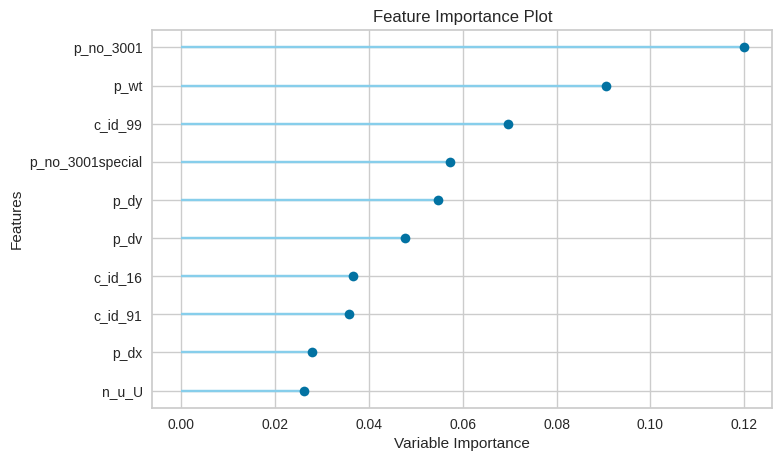

In [25]:
plot_model(rfr, 'feature')

<img style="float:left;" src="data:image/png;base64, 
iVBORw0KGgoAAAANSUhEUgAAAw4AAARxCAIAAAAH80eAAADWTElEQVR4nOzdeVyU9f7///ewD4IQ
IggqglKEigsa7pBppaSJlpSYS1rHJTSlTmJH3FNxSzHULEqOekzK5ahlJpnHJU+aC6AiHVAcVBYT
FZCRxbl+f0yf+fEVrmHUGQb1cf/D21zv6329r9e8LHl6XdeMCkmSBAAAAGpiYe4CAAAA6i+iEgAA
gCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyi
EgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgATio6O9qvJ
qlWrzF1aLbZt2+bn55eVlWXuQszvnt+7wMDAUaNGHTp0SLv38uXLfn5+mzdvNm+RgOlYmbsAAI85
FxeXnTt33jNob2//MGvGxMQ4OTl9+OGHD7NIPbdr164NGzYkJSWZuxAhhHjrrbfGjx8vhNBoNPn5
+V999dW77777+eefh4SEGL7I2rVrMzIyPv30U5OVCZgEUQmAaVlYWDRu3Ni4a54+ffq+fkg/ik6f
Pm3uEv5/SqVS95vo7u6+dOnSM2fObN68+b5+F06fPq1UKk1TIGBC3IADYE7ff//90KFDAwMDg4KC
pk6dmp+fr9v173//e8iQIZ06derUqdOwYcOOHTumHffz8/vjjz+++OILPz+/y5cvr1q1ys/Pr6ys
TLu3rKxMd4Pvt99+8/Pz27Nnz8CBA7t3766dcOTIkbfeeisoKCgwMPDdd9815Bab9h7Tjh07/vGP
f3Tu3DkoKCg2NrasrGz27NlBQUHdunVbvHixdqb2jAcOHJg6dWqnTp06duwYFRV169Yt7V5Jkr78
8suXX365bdu2QUFBkydPzsnJ0e5atWpV586dk5OTe/bsOXny5BEjRmzcuDElJcXPz2/btm1CiJSU
lLFjx3br1q19+/ahoaHffPONrrwXXnjhk08++fbbb19++eX27dsPHDjwwIEDur2pqakjRozo2LFj
jx49/v73vxcUFGjHS0tL58+f//LLLwcEBPTt23fdunWSJBn4u2ZlZeXr63v58uXqu7KyssaPH9+5
c+e2bduGhoZu3LhRV+Qvv/zyww8/+Pn5/fbbbwaeCKgPiEoAzOaHH36IiooKCAj47rvvVq9efeHC
hdGjR5eXlwshjh079tFHHwUHB+/YsePbb79t1qzZ+PHjtUHq8OHDQoi33nrr8OHDHh4etZ5l7dq1
77///tatW4UQJ0+efPfddxs1arRx48bExMTy8vK33nqrsLDQkGrXrl3brl27bdu2DR069Kuvvnr7
7bdbtWr13XffvfbaawkJCbokJ4T45JNPnnvuuW3bti1YsOCXX3755JNPtOOrVq1asWLFsGHDdu/e
vXr16uzs7FGjRpWWlmr33r17d8OGDatXr545c+aqVas6duzYpk2bw4cPh4aGlpSUvP3229bW1hs2
bPj+++/Dw8NnzZq1f/9+3RkPHz7866+/rly5MikpqUGDBh988EFJSYkQ4tKlS6NGjfLx8UlKSlq9
enVGRsaECRO0h7z//vu7du2KjIzcvXv3u++++9lnn8XHxxvSB62cnJxmzZrdM3j9+vXhw4ffuHFj
3bp1u3fvHjRo0Pz587Vp6bvvvmvSpEmfPn0OHz7csWNHw08EmB1RCYDZrF69OjAwcObMmS1btuzc
ufOiRYsuXLiwd+9eIUTbtm1/+OGHyMjI5s2bt2zZcvz48bdv3z558qQQQnsnSHtLyNLSstazdO/e
vW/fvtpQ9fnnnzdp0mTZsmXPPPNMQEDAsmXLSkpKDHweqG3btm+88YaXl9c777wjhLCzsxsxYoSX
l9fYsWOFEOfOnat6xoiIiBYtWvTv3z88PHzv3r1qtbq8vHz9+vVDhgwZPXq0t7d3586dFyxYcOXK
leTkZO1RpaWlo0ePbteunaurq7Ozs7W1tZWVVePGje3s7Ozs7Hbs2LF48WJfX99mzZqNHj3a1dVV
92C1EKKkpCQ2NvbZZ5/18/MbOXJkSUnJhQsXhBAbNmywtbWdOXPm008/3b59+1mzZrVq1eratWtp
aWkHDx788MMPBw4c2KJFizfeeOONN9746quvtDlVv6Kiok8//TQrK2vUqFH37Nq6deutW7fi4uIC
AwO9vb3HjRv3/PPP//Of/xRCuLi4WFpa2traNm7c2MbGxpCGA/UEzyoBMK3r169Xv4qwfPny5557
7n//+9/kyZN1g/7+/s7OzufOnRs4cKC9vf3p06dnzJhx6dIltVqtvTd08+bNByigbdu2utenT5/u
06ePldVff/S5uro+/fTTVVOOHm3atNG+cHZ2FkI8++yzVTe1V3G0OnfuXPWoO3fuXL16taKi4vbt
288995xuV+vWrW1tbc+ePfvqq69WL7UqKyur/Pz8BQsWnD9/Xns7T61WV+1GmzZtdPnDxcVFCKGd
lpKS0qZNG9371d7NFEL8+OOPQoiePXvqVujWrds///nP7OzsZ555pnoB69ev37RpkxBCkiS1Wu3p
6bl48eJu3brdMy01NdXLy8vd3V030qFDh19++aWkpMTBwaHGtwbUf0QlAKbl7Oy8ZcuWewYbN25c
VFQkhFizZs2XX36pG1er1dqHaRITExcsWDBs2LDp06c7OTnl5+ePGDHiwQpwdHTUvS4uLt65c+ee
PXt0I2VlZQZe5LCzs9O+UCgUQgjdE8razaoP+jRs2FD3WhsRioqK7t69e08xFhYW9vb2t2/frvHA
qs6cOTNq1KjOnTsvXLjQ3d3d0tLynm5UfVy6aj1FRUU13qMsLi4WQoSGhupGNBqNEOLatWs1RqUh
Q4ZoL54pFIqqj3jfo3ok0r7f27dvE5Xw6CIqATAtS0vLFi1aVB/X/iwfPXr00KFDq45rv0fg3//+
t5+f3+zZs7WDeh4nuiepVE0e1TVs2LBnz56TJk2qOmj0+0FVa9CGEicnp8rKSvH/XnzSaDSlpaVV
w5Oc77//XqPRxMXFaa9gaTQa3aPi+jVq1KjGmU5OTkKIxMRE7QsduQzUsGHDGn8Tq0/Lzc2tOqJ9
++QkPNJ4VgmAeTRo0OCZZ565ePFiiyrKy8sbNWokhKioqPD09NRN3r59u/h/r9zoXmujhi5LpaSk
6Dlphw4dsrKyqp6xsrLS6N9l8N///lf3Oi0tzd7e3tPT08fHx9HR8fjx47pdJ06cKCsrCwgIkFtH
9x7Ly8uVSqU2Jwkhfvjhhzt37hjygbW2bdumpaXduXNHu5mamjps2LCLFy+2b99eCFFQUKDrQ8OG
DZVK5UN+31W7du1ycnKqfozx119/bdWqVYMGDe55R8AjhKgEwGzGjRv3888/r1q1KisrKysrKzY2
dvDgwdonh9q3b//bb7/9+uuvly5dWrJkiUajsbS0TE1N1Uaihg0bpqamnj9/vqioSBs11q5dq1Kp
Dh8+/OWXX+r58p533nknIyNj9uzZ58+fv3Tp0hdffDFw4MD//Oc/xn1fhw8f/uabby5durRnz56t
W7e+8sordnZ21tbWb7/99tatWzdu3JiTk3P8+PHZs2e3bNmyb9++NS7SsGFDlUqVmpqal5fXvn37
0tLS9evXX758edu2bZs2berQocP//ve/Gj+uX9WIESMqKys/+uij8+fPp6amzpkz586dOy1atGjb
tm3Pnj3nzZuXnJx8+fLlY8eOvfPOO+PHj3/IKDNkyBBnZ+cpU6akpqZmZ2fHx8f/9ttvf/vb33Tv
6Pz58+fOnbt+/frDnAWoY0QlAGYzYMCA5cuX79+/f9CgQa+99tqZM2e+/PJL7aPNU6dO7dKlS2Rk
5JtvvllZWTlr1qy33nrr+++/X7hwoRBiwoQJZ86cGT58eFZWVmBg4OTJk/fv3z9gwIDPPvssJiZG
9xRzdZ07d/7yyy8zMjLeeOONAQMG/Pjjj8uXL+/Tp49x39fUqVOPHTs2ZMiQjz/++KWXXoqJidGO
T5w4ccqUKf/85z/79es3adKk1q1bJyYmyt3+GzlypLW19fDhw/fs2TNgwIBRo0Z9/vnnr7766r59
+1asWDFq1Kjc3Nxan99q3rz5119//eeff77xxhvjx4/39vb+/PPPLSwshBCrVq166aWX5s6d+9JL
L73//vutW7f+8ssvtXczH5iLi8uGDRsaNmz49ttvDxgwYO/evbGxsWFhYdq97777bmFhYURERNUv
VgDqPwWXQwHAWH777beRI0d+8cUXwcHB5q4FgHFwVQkAAEAWUQkAAEAWN+AAAABkcVUJAABAFlEJ
AABAFlEJAABAFv+wyePg1KlTkiRZW1ubuxAAAB4xFRUVCoWi+r/qrcNVpceBJEmmeDxfkqTy8nIe
/K+OzsihM3LojBw6UyPaIscUnan1ZyhXlR4H2utJev4lqQdTWlqanp7u6+v7kP8s1OOHzsihM3Lo
jBw6UyPaIscUnUlLS9M/gatKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAA
sohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohK
AAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAADgESBJ0uHsaz9l3zqc
fU2SpDo7L1HJ+Pbs2TNw4MAOHTq88MILS5Ysqays1I6vX7/+5Zdf7tSp07Bhw1JTU7WDZWVlMTEx
wcHBXbt2nTRpUmFhoW6dQ4cOde/eferUqWZ4DwAA1Cfb01R+C//dP+HgjF+v9E846Lfw39vTVHVz
aqKSkZ05cyY6OvrDDz88efLk6tWrt23btmnTJiFEcnJyfHz84sWLjxw50qdPnwkTJty+fVsIsWzZ
snPnzm3ZsmXv3r0KhWL69Onadb744ov58+e3aNHCnG8GAIB6YHuaKjzxYNb1Yt1I1vXi8MSDdZOW
rOrgHGZ0+fLlPn36xMXFxcXFqVSqgICAlStXNm7cuMbJq1atOnfuXGBg4Pr168vLywcNGjRjxgwh
RFlZ2ZIlS5KTk0tLS/39/aOjo/39/eXOqFQqly1bFhISIoR49tlnO3Xq9L///U8I8e233w4ZMqR9
+/ZCiLFjxyYmJh44cKBfv37btm2LjY318PAQQkyZMiU0NDQ/P9/d3d3W1va777775JNPysrKTNEZ
A90SNnnqu3ZShRlrqIfu3LlLZ2pEZ+TQGTl0pka0pSpJkj7YeUJT7Y6bRpKid58Ma9tcoVCYtIDH
PCppbdy4MSEhQalURkZGzp49Oz4+Xm7myZMn27Vr98svv5w4cWL06NGvvvpqu3btli9ffvz48Y0b
NzZq1Cg2NnbcuHHJyck2NjY1rtCqVatWrVoJITQazfHjx3///fclS5YIIc6ePRsaGqqdo1Aonn32
2bS0NH9//+Li4jZt2mjHW7ZsaWdnd/bsWXd395EjR97Xe5QkqbS09L4OqZVarT5m4XFMVSaEOeNa
PUVn5NAZOXRGDp2pEW35PxfzCy8VltS4K/PP4uT0nB7erg+zviRJ+sPWExGVIiIimjRpIoQYPXr0
lClTNBqNhUXNdx4tLS3HjRtnYWHRrVs3FxeXrKysdu3abd26de7cuc2aNRNCREVFbdmyJTU1tXPn
znrOuGPHjo8//tjW1vbjjz/u1auXEOLmzZtOTk66CU5OTjdu3Lh586YQomHDhrrxhg0b3rhx4wHe
Y0VFRXp6+gMcWAsL7gACAMypWH1Hz94T5zNd1Nce8hRylz+0noio5OPjo33RtGnT8vLymzdvuri4
1DjT09NTl6KUSuWdO3du3bpVXFzcsmVL7WDDhg1dXV1zc3P1nzEsLGzAgAGnT5+Oioq6e/fum2++
ec8EuQxba7aVY21t7evr+wAH6qFWq4Oyr3p4eNja2hp35UddWVlZbm4unamOzsihM3LoTI1oS1Xe
wnHLYdm9nZ719X+4q0qZmZn6JzwRUUmj0Whf1PrZQrmrTVXjiyRJFRW13zy2srLq3Lnz8OHDN27c
+Oabbz711FNVLxfdunXr6aef1ia2Gzdu2Nvba8eLiorkYpx+CoVCt4gROYnyFs72plj5kVZaalma
S2dqQGfk0Bk5dKZGtKUqHxeHmXtSqj7TrePr6tjX/2GfVar18CfiE3Aq1V9PyF+5csXOzu6pp54y
/FgnJycnJ6esrCztZlFRUWFhoZeXl9z8+Pj4Dz/8ULepUCisrKyEEG3btj179qx28O7du+fOnWvf
vn3z5s2dnJx043/88Ud5eXnbtm3v580BAPA4UygUsQMDLaoFGguFYtGAQFM/0y2ekKi0adOm/Pz8
mzdvrl+/PiQk5H7b2r9//3Xr1uXl5ZWWli5durRZs2YdO3aUm9ylS5cff/zxxx9/rKys/N///vfN
N9/07t1bCDFs2LAdO3acPn1arVavWbPGxsbm+eeft7S0DA8PX7t2bW5u7o0bN5YvX/7iiy+6uj7U
hUQAAB4zgwO8kkYF+7o66kZ8XR2TRgUPDpC9cmFET8QNuLCwsDFjxqhUqg4dOsyaNet+D582bdq8
efOGDh1aXl7esWPHr7/+2tLSUm5y586dly5dunLlyr///e+urq6vvPLKhAkThBDBwcFRUVHR0dHX
rl1r06bNunXr7OzshBCTJ08uLS194403Kisru3fvrisvICBACKH9+srk5GQhRFpa2gO9ewAAHnmD
A7zC2jbfl646eT6r07O+D3/fzXCKuvxq8Lqn/V6lH374QfsB/seVNkVp05URlZaWpqen+/v7c7P8
HnRGDp2RQ2fk0Jka0RY5puhMrT9Dn4gbcAAAAA/mibgBV1VCQsKKFSuqjw8aNGj+/PkGLpKamjp8
+PDq456ennv37n2Y8gAAQL3ymEelZs2aZWRkVB0ZO3bs2LFjH3LZdu3a8eQQAABPAm7AAQAAyCIq
AQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAA
yCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyCIqAQAAyLIydwEAANQX
kiQdulBwtajUs6F9r5ZuCoXC3BXB/IhK9d3Nmzf37ds3dOhQcxcCAI+57WmqabtOZl0v1m62auQY
OzBwcICXeauC2XEDrr7773//++2335q7CgB4zG1PU4UnHtTlJCFE1vXi8MSD29NUZqwK9QFXlUzi
8uXLffr0iYuLi4uLU6lUAQEBK1eubNy4cfWZ33777ebNm7dt2yaEOHbs2IgRI9atWxcSEiKEGDFi
RNeuXePj4zUaTUBAwA8//NC8efM6fiO3hE2e+q6dVFHH563n7ty5S2dqRGfk0Bk59aQzkiR9sPOE
RpLuGddIUvTuk2Ftm3Mn7klGVDKhjRs3JiQkKJXKyMjI2bNnx8fHV5/TtWvX2bNnl5aW2tvbHz9+
3MfH5+TJkyEhIRUVFampqbNmzdJoNIcOHUpKStJ/LkmSSktLjVu/Wq0+ZuFxTFUmRJlxV34c0Bk5
dEYOnZFTDzpzMb/wUmFJjbsy/yxOTs/p4e1al/Wo1Wrdr6jKFJ2RJEl/FCYqmVBERESTJk2EEKNH
j54yZYpGo7GwuPeOZ/Pmzd3d3VNTU7t27fr777+/+eabycnJQogzZ844Ojr6+voaeK6Kior09HTj
1i+EEBYtjL8mANQzxeo7evaeOJ/por5WZ8XoZGdn1/1JHwlG74yNjY2evUQlE/Lx8dG+aNq0aXl5
+c2bN11cXKpP69Kly6lTpzp37nzu3LnPPvtszZo15eXlv//+e9euXQ0/l7W1teG5ykBqtToo+6qH
h4etra1xV37UlZWV5ebm0pnq6IwcOiOnnnTGWzhuOSy7t9Ozvv51flUpOzvb29tbqVTW5XnrP1N0
JjMzU/8EopIJaTQa7Qup2v3vqrp06fLDDz+cPXvWx8enQYMGzzzzzNmzZ0+cOPHiiy8afi6FQmFv
b/9Q5dbESZS3cLY3xcqPtNJSy9JcOlMDOiOHzsipJ53xcXGYuSel6jPdOr6ujn39zfOsklKp5D+Y
Ghm3M7X+5vIJOBNSqf763MSVK1fs7OyeeuqpGqd17dr19OnTv/32W6dOnYQQHTt2/P3330+ePHlf
V5UAAA9MoVDEDgy0qPYj00KhWDQgkGe6n3BEJRPatGlTfn7+zZs3169fHxISIvc/W5MmTZydnbdu
3aqLSjt27HB2dm7atKkQwtbW9tq1a9euXSsvL6/T6gHgSTI4wCtpVLCvq6NuxNfVMWlUMN+rBKKS
CYWFhY0ZM6ZXr14KhWLWrFl6Znbt2vXSpUuBgYFCiI4dO2ZlZekuKfXt21eSpBdffPHMmTN1UTQA
PKkGB3idjx70y8SX/vVWrwPvvXQ+ehA5CYJnlUyqQ4cO33//vSEz586dO3fuXO1rZ2fn8+fP63a1
bNnywIEDpigPAHAPhUIR3Mrd3FWgfuGqEgAAgCyuKtWRhISEFStWVB8fNGjQ/Pnz67wcAABgEKKS
STRr1iwjI6PqyNixY8eOHWuuegAAwIPhBhwAAIAsohIAAIAsohIAAIAsohIAAIAsohIAAIAsohIA
AIAsohIAAIAsohIAAIAsohIAAIAsohIAAIAsohIAAIAsohIAAIAsohIAAIAsohIAAIAsohIAAIAs
ohIAAIAsohIAAIAsohIAAIAsK3MXAACoC5IkHbpQcLWo1LOhfa+WbgqFwtwVAY8GopIR7NixIy4u
bv/+/feML126NCUlZcOGDWapCgB0tqeppu06mXW9WLvZqpFj7MDAwQFe5q0KeCRwA84IwsLCquck
Q5SUlMyZMyc4OLhjx46RkZGFhYXa8ezs7PHjx3fp0qVLly6xsbEajcao9QJ4smxPU4UnHtTlJCFE
1vXi8MSD29NUZqwKeFRwVcmcFixYcO7cuc2bNzs5OS1cuDA6OnrdunWVlZXjx4/v0KHDzz//XFRU
NGnSpK+++uqdd94xS4W3hE2e+q6dVGGWs9dbd+7cpTM1ojNyzNgZSZI+2HlCI0n3jGskKXr3ybC2
zbkTB+hHVNInJydn5syZp06dcnZ2HjNmzMiRI2uctm3btmXLlh05ckQIsX///tjY2IKCgt69e7u4
uOhff//+/dOnT2/atKkQYvr06UFBQfn5+UVFRRcvXly/fr2Dg4ODg8PkyZMXLFhQa1SSJKm0tPSB
3qUstVp9zMLjmKpMiDLjrvw4oDNy6IwcM3XmYn7hpcKSGndl/lmcnJ7Tw9u1jkuqSq1W636FDm2R
Y4rOSJKk/y8MRCV9IiMjg4KCVq9erVKpIiIifHx8evXqpWd+UVHR1KlTo6Kihg0bdvTo0aioqNat
W+s/he63R6lU2tjYnD9/3tPTs+p4w4YNs7Oz1Wq1UqnUs05FRUV6evp9vDcDWbQw/poA6lCx+o6e
vSfOZ7qor9VZMXKys7PNXUJ9RFvkGL0zNjY2evYSlWSdO3cuIyMjMTFRqVT6+fnFx8c3btxY/yGH
Dx+2s7MbMWKEhYVFSEhIp06d9Cff3r17JyQkBAYGNmrUaO3atRqN5tatWz169PD29l6+fHlMTExp
aelXX30lhCgqKtIflaytrX19fR/gbeqhVquDsq96eHjY2toad+VHXVlZWW5uLp2pjs7IMWNnvIXj
lsOyezs96+tv7qtK2dnZ3t7e+v+Ie9LQFjmm6ExmZqb+CUQlWSqVysHBwdnZWbvZtWvXWg/Jy8tr
0qSJhcVfD8t7eXllZGTomR8dHf3JJ5+8/vrrdnZ2b7/9dvPmza2srKysrD777LN58+aFhIR4enqO
Gzfup59+srKq5XdKoVDY29sb9Mbuh5Mob+Fsb4qVH2mlpZaluXSmBnRGjhk74+PiMHNPStVnunV8
XR37+teLZ5WUSiX/zVRHW+QYtzO1/i9AVJKlUCju96Nn5eXlVTd1mUmOk5PT4sWLta8lSVq5cmWT
Jk2EEE8//fQ///lP7fiZM2dsbW11iQ0A7otCoYgdGBieePCeJ7stFIpFAwLrQ04C6jm+LECWl5fX
7du3CwoKtJv79u07evSo/kPc3Nzy8vJ0ASsrK0v//OPHj6empmpfnz59WqPRaJ9t+v777/Pz87Xj
R44c6dChg6Wl5QO/EQBPuMEBXkmjgn1dHXUjvq6OSaOC+V4lwBBEJVn+/v5t2rRZsWLF7du3//jj
jxkzZtxz0ai6bt26lZSUbNmypby8PDk5OSUlRf/8//73v9OnT7927dr169dnzZr15ptv2tnZCSG+
+eabxYsXl5WVpaamrlu3bvTo0cZ6UwCeTIMDvM5HD/pl4kv/eqvXgfdeOh89iJwEGIgbcPqsWbPm
o48+6t69e6NGjSIjI0NCQvTP9/DwWLJkyfLly2NjY4ODgyMiIk6dOqVn/rhx4y5fvtyvXz8rK6sB
AwZERUVpxxcsWDB9+vQuXbo89dRTH3744QsvvGC0twTgSaVQKIJbuZu7CuDRQ1TSx93dPTExsdZp
Q4YMGTJkiPZ1aGhoaGiogevb2NjExsZWH2/evPnGjRsNrxMAAJgIN+AAAABkcVXJUKmpqcOHD68+
7unpuXfvXj0Hzps3Lykpqfr4hAkTJk6caLT6AACACRCVDNWuXbu0tLQHODAmJiYmJsbo9QAAgDrA
DTgAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUA
AABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCXzCwgI
OHLkiNzey5cv+/n5ZWVl1WVJAAwhSdLBrPxvTl08mJUvSZK5ywFgElbmLsDI9uzZs3r16pycHBcX
l/79+0+dOtXKykoIsX79+s2bN//555/PPPPM9OnT27VrJ4QoKyubP3/+f/7zn/Ly8ueee27OnDku
Li7adQ4dOjRt2rQuXbp8+umnpq45LS3N1KcAYHTb01TTdp3Mul6s3WzVyDF2YODgAC/zVgXA6B6r
q0pnzpyJjo7+8MMPT548uXr16m3btm3atEkIkZycHB8fv3jx4iNHjvTp02fChAm3b98WQixbtuzc
uXNbtmzZu3evQqGYPn26dp0vvvhi/vz5LVq0MOebAVCPbU9ThSce1OUkIUTW9eLwxIPb01RmrAqA
KZjwqtLly5f79OkTFxcXFxenUqkCAgJWrlzZuHHjGievWrXq3LlzgYGB69evLy8vHzRo0IwZM4QQ
ZWVlS5YsSU5OLi0t9ff3j46O9vf3lzujUqlctmxZSEiIEOLZZ5/t1KnT//73PyHEt99+O2TIkPbt
2wshxo4dm5iYeODAgX79+m3bti02NtbDw0MIMWXKlNDQ0Pz8fHd3d1tb2+++++6TTz4pKyvTLV5a
Wjp79uyDBw+WlZX5+fnNnDmzdevWq1atOnHiRFBQUGJiYkVFxYgRI6ZOnSqE0Gg0n3322c6dO69d
u/b000/Pnz//2WefFUIUFhbOnj370KFDDRo0GDJkyNSpUxUKhZ+f3xdffBEcHKzde/z48YqKik6d
Os2dO9fd3d2IvyMP4JawyVPftZMqzFtGfXPnzl06U6MnpDOSJH2w84Sm2h03jSRF7z4Z1ra5QqEw
S2EATMHkN+A2btyYkJCgVCojIyNnz54dHx8vN/PkyZPt2rX75ZdfTpw4MXr06FdffbVdu3bLly8/
fvz4xo0bGzVqFBsbO27cuOTkZBsbmxpXaNWqVatWrYQQGo3m+PHjv//++5IlS4QQZ8+eDQ0N1c5R
KBTPPvtsWlqav79/cXFxmzZttOMtW7a0s7M7e/asu7v7yJEjqy+emJiYkZHx448/Ojg4fPXVVzEx
MVu3bhVCpKSkdOzY8dChQ2lpaWPHjg0ICOjbt+/69et37979xRdfNG3adMuWLSNHjjxw4IC9vf2M
GTOsrKwOHTpUVFT01ltvNW3a9I033tCdYsmSJSUlJT///LNGo4mMjFy8ePGyZcsM7LMkSaWlpQZO
NpBarT5m4XFMVSZEWe2znzR0Rs4T0JmL+YWXCktq3JX5Z3Fyek4Pb9d7xtVqte5XVEVnakRb5Jii
M5Ik6f/rjcmjUkRERJMmTYQQo0ePnjJlikajsbCo+a6fpaXluHHjLCwsunXr5uLikpWV1a5du61b
t86dO7dZs2ZCiKioqC1btqSmpnbu3FnPGXfs2PHxxx/b2tp+/PHHvXr1EkLcvHnTyclJN8HJyenG
jRs3b94UQjRs2FA33rBhwxs3bsgtW1RUZGlpaWdnZ2Vl9e6777777rvacQsLi/fee8/KyqpTp049
e/Y8cOBA3759t27d+vbbb/v4+AghRowYob2O1a1bt19++WXbtm0ODg4ODg6ffvrpPa2YPXt2ZWWl
vb29EOKFF17Q3j00UEVFRXp6uuHzDWXBXUjgXsXqO3r2njif6aK+VuOu7OxskxT06KMzNaItcoze
GblLMFomj0rauCCEaNq0aXl5+c2bN3WPTt/D09NTFx2USuWdO3du3bpVXFzcsmVL7WDDhg1dXV1z
c3P1nzEsLGzAgAGnT5+Oioq6e/fum2++ec8EufyoP1cOGzYsOTk5JCSkZ8+effv2ffnll7WTvby8
tE+Oa9+C9vdPpVJ98sknCxYs0I5rNJrc3NzLly9rNJqmTZtqB7U3BKu6dOnSwoULz5w5c+fOHY1G
c19336ytrX19fQ2fbwi1Wh2UfdXDw8PW1ta4Kz/qysrKcnNz6Ux1T0hnvIXjlsOyezs96+tf01Wl
7Oxsb29vpVJp2uIeNXSmRrRFjik6k5mZqX+CyaOSRqPRvqj1k7RyV5uqxhdJkioqan8GwsrKqnPn
zsOHD9+4ceObb7751FNPVb1cdOvWraefflqb2G7cuKG9iiOEKCoqkotxQggvL689e/b8+uuvv/zy
S0xMzM6dO9esWSOEuHv3btXytNXa2dnNnz//5ZdfrrrCmTNnRJWG3EOj0YwfP75Tp0579+51cXHZ
tGlTQkJCre9UR6FQ6N6IETmJ8hbO9qZY+ZFWWmpZmktnavCEdMbHxWHmnpSqz3Tr+Lo69vWXfVZJ
qVQ+3p15YHSmRrRFjnE7U+vDhSb/BJxK9dfnQa5cuWJnZ/fUU08ZfqyTk5OTk5PuK4WKiooKCwu9
vGQ/ixsfH//hhx/qNhUKhfZ6T9u2bc+ePasdvHv37rlz59q3b9+8eXMnJyfd+B9//FFeXt62bVu5
xUtLSysrK4ODg2fNmrV69er9+/dr41dubm5lZaXuPWovBTVv3jwjI0N37OXLl4UQzZo1s7CwuHjx
onbw6NGj+/bt0835888/r1y5MmLECG1c0xUGoL5RKBSxAwMtqv3xaqFQLBoQyDPdwGPG5FFp06ZN
+fn5N2/eXL9+fUhIyP3+IdK/f/9169bl5eWVlpYuXbq0WbNmHTt2lJvcpUuXH3/88ccff6ysrPzf
//73zTff9O7dWwgxbNiwHTt2nD59Wq1Wr1mzxsbG5vnnn7e0tAwPD1+7dm1ubu6NGzeWL1/+4osv
urree9lcZ9KkSXPnzi0pKamsrDx79qyzs7P2+afKysq1a9eWl5f//vvvR44ceeGFF4QQb7755qZN
m06fPn337t0ffvhhwIABV69edXZ27tOnT3x8/M2bN3Nzc2fOnHnt2v//QIOLi4u9vf3p06fLysp2
7NiRmZl569atO3f0PRIBwFwGB3gljQr2dXXUjfi6OiaNCuZ7lYDHj8lvwIWFhY0ZM0alUnXo0GHW
rFn3e/i0adPmzZs3dOjQ8vLyjh07fv3115aWlnKTO3fuvHTp0pUrV/797393dXV95ZVXJkyYIIQI
Dg6OioqKjo6+du1amzZt1q1bZ2dnJ4SYPHlyaWnpG2+8UVlZ2b17d115AQEBQgjttaLk5GQhRFpa
2rx582JiYoKDg4UQzzzzTHx8vPaO4dNPPy2E6NWrV2Vl5TvvvPP8888LIV5//fXc3NzIyMiSkpKW
LVuuWrXK09NTCLFw4cJ//OMfvXv3btCgwWuvvTZs2DBd8VZWVrNnz16yZElcXNzAgQNXrVo1fPjw
l1566V//+tf9Ng1AHRgc4BXWtvmhCwW5RWpPJ2VPHzeuJwGPJYXpvoxf+71KP/zwg/YD/I+lVatW
HTp0KCkpybxlaL/vW5vwjKi0tDQ9Pd3f35+b5fegM3LojBw6I4fO1Ii2yDFFZ2r9GfpYfVs3AACA
cdXpvwGXkJCwYsWK6uODBg2aP3++gYukpqYOHz68+rinp+fevXsfpjwAAIB7mDAqNWvWrOqnwIQQ
Y8eOHTt27EMu265du/rz78tOmjRp0qRJ5q4CAACYCjfgAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGV
AAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAA
ZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGV6pcePXps27bN3FUAEJIkHczK/+bUxYNZ+ZIkmbsc
AGZjZe4CAKDe2Z6mmrbrZNb1Yu1mq0aOsQMDBwd4mbcqAGbBVSUA+H9sT1OFJx7U5SQhRNb14vDE
g9vTVGasCoC5cFXJ+C5fvtynT5+4uLi4uDiVShUQELBy5crGjRvXOLmysnLhwoW7d++2tbWdNGmS
djA+Pv7nn3/W3Yk7fvz422+//euvvzZs2LCO3sP/uSVs8tR37aSKOj5vPXfnzl06U6PHoDOSJH2w
84Sm2h03jSRF7z4Z1ra5QqEwS2EAzIWoZCobN25MSEhQKpWRkZGzZ8+Oj4+vcdrWrVv37NmzadMm
T0/PRYsW3bp1SwgxaNCgVatWZWVltWrVSgjx008/Pf/88/pzkiRJpaWlxn0LarX6mIXHMVWZEGXG
XflxQGfkPOKduZhfeKmwpMZdmX8WJ6fn9PB2fYBl1Wq17ldURWdqRFvkmKIzkiTp/ysQUclUIiIi
mjRpIoQYPXr0lClTNBqNhUUNtzv37ds3YMAAX19fIcSUKVO2bNkihGjWrFnnzp137do1ZcoUIcTP
P/8cHR2t/3QVFRXp6elGfxfCooXx1wTqsWL1HT17T5zPdFFfe+DFs7OzH/jYxxudqRFtkWP0ztjY
2OjZS1QyFR8fH+2Lpk2blpeX37x508XFpfq0/Pz8nj17al+7uLg0aNBA+3rQoEGff/75lClT0tLS
iouLn3/+ef2ns7a21uYtI1Kr1UHZVz08PGxtbY278qOurKwsNzeXzlT3GHTGWzhuOSy7t9Ozvv4P
elUpOzvb29tbqVQ+eHGPIzpTI9oixxSdyczM1D+BqGQqGo1G+0L/x4zLy8urblpaWmpf9O/ff/78
+adPn/7ll1/69eunP/AKIRQKhb29/UPUWzMnUd7C2d4UKz/SSkstS3PpTA0eg874uDjM3JNS9Zlu
HV9Xx77+D/WsklKpfHQ7Y1J0pka0RY5xO1Pr/9R8As5UVKq/Pixz5coVOzu7p556qsZpbm5uubm5
2tcFBQVFRUXa1w4ODn369Pnxxx/37NkzcODAOigYgBBCoVDEDgy0qPZHp4VCsWhAIM90A08gopKp
bNq0KT8//+bNm+vXrw8JCZH7E7Znz57ff/99dnZ2SUnJp59+WvW2xaBBg7799tuKiornnnuurqoG
IAYHeCWNCvZ1ddSN+Lo6Jo0K5nuVgCcTN+BMJSwsbMyYMSqVqkOHDrNmzZKb9vbbb+fk5ISHh9vY
2EyePPnEiRO6XT179lQqlQMGDOAvskAdGxzgFda2+aELBblFak8nZU8fN/43BJ5YRCVT6dChw/ff
f1/rNBsbm/nz58+fP1+7GR4ertulVqvVavVrr71mqhIByFMoFMGt3M1dBQDz4wZcPVVWVjZ37tye
PXt6e3ubuxYAAJ5cXFWqCwkJCStWrKg+PmjQIN31pKp+//33MWPGPPfcc0uWLDF5cQAAQB5Ryfia
NWuWkZFRdWTs2LFjx441fIXOnTunpqYauy4AAHDfuAEHAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gE
AAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAg
i6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6gEAAAgi6hUv/To0WPbtm3mrgKo7yRJOpiV/82piwez
8iVJMnc5AB5nVuYuAADuz/Y01bRdJ7OuF2s3WzVyjB0YODjAy7xVAXhccVUJwKNke5oqPPGgLicJ
IbKuF4cnHtyepjJjVQAeY1xVMr7Lly/36dMnLi4uLi5OpVIFBASsXLmycePGNU6urKxcuHDh7t27
bW1tJ02apB1cvHhxWlrahg0btJs///zztGnTfv31Vxsbmzp6D//nlrDJU9+1kyrq+Lz13J07d+lM
jUzdGUmSPth5QlPtjptGkqJ3nwxr21yhUJjivACeZEQlU9m4cWNCQoJSqYyMjJw9e3Z8fHyN07Zu
3bpnz55NmzZ5enouWrTo1q1bQoj+/fuvX7/+xo0bTz31lBBi3759ffv21Z+TJEkqLS017ltQq9XH
LDyOqcqEKDPuyo8DOiPHlJ25mF94qbCkxl2ZfxYnp+f08HY1xXkfnlqt1v2KquhMjWiLHFN0RpIk
/X/LIiqZSkRERJMmTYQQo0ePnjJlikajsbCo4Xbnvn37BgwY4OvrK4SYMmXKli1bhBABAQEeHh4H
DhwYPHhwZWXlL7/8smTJEv2nq6ioSE9PN/7bsGhh/DWBB1WsvqNn74nzmS7qa3VWzAPIzs42dwn1
FJ2pEW2RY/TO6L8YQVQyFR8fH+2Lpk2blpeX37x508XFpfq0/Pz8nj17al+7uLg0aNBA+7pfv37J
ycmDBw8+duyYEKJ79+76T2dtba3NW0akVquDsq96eHjY2toad+VHXVlZWW5uLp2pztSd8RaOWw7L
7u30rK9/Pb6qlJ2d7e3trVQqzV1L/UJnakRb5JiiM5mZmfonEJVMRaPRaF/o/yRzeXl51U1LS0vt
i379+o0YMeLOnTs//fTTyy+/bGVVy++UQqGwt7d/iHpr5iTKWzjbm2LlR1ppqWVpLp2pgak74+Pi
MHNPStVnunV8XR37+tf3Z5WUSiX/zdSIztSItsgxbmdq/XODT8CZikr11+dxrly5Ymdnp33qqDo3
N7fc3Fzt64KCgqKiIu3rgIAAV1fXX3/9NTk5uX///nVQMFD/KRSK2IGBFtX+XLNQKBYNCKznOQnA
I4qoZCqbNm3Kz8+/efPm+vXrQ0JC5P4Q79mz5/fff5+dnV1SUvLpp59WvW3x8ssvf/3115IkdenS
pa6qBuq7wQFeSaOCfV0ddSO+ro5Jo4L5XiUAJsINOFMJCwsbM2aMSqXq0KHDrFmz5Ka9/fbbOTk5
4eHhNjY2kydPPnHihG5X//79v/zyy7feeqvG58GBJ9bgAK+wts0PXSjILVJ7Oil7+rhxPQmA6RCV
TKVDhw7ff/99rdNsbGzmz58/f/587WZ4eLhuV9u2bTMyMkxVH/AoUygUwa3czV0FgCcClysAAABk
cVWpLiQkJKxYsaL6+KBBg3TXkwAAQD1EVDK+Zs2a3XPjbOzYsWPHjjVXPQAA4IFxAw4AAEAWUQkA
AEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAW
UQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAECWlbkLAFBPSZJ06ELB1aJS
z4b2vVq6KRQKc1cEAGZAVDKCHTt2xMXF7d+//57xpUuXpqSkbNiwwSxVAQ9je5pq2q6TWdeLtZut
GjnGDgwcHOBl3qoAoO5xA84IwsLCquckA/35559jxozx8/MrKyurOv7tt9++8MIL7du3Dw8PP3v2
rDHKBAy1PU0VnnhQl5OEEFnXi8MTD25PU5mxKgAwC64qmVNGRsa4ceM6dep0z/iBAwdWrFgRHx//
zDPPrF+/fvXq1fHx8Wap8JawyVPftZMqzHL2euvOnbuPcWckSfpg5wmNJN0zrpGk6N0nw9o2504c
gCcKUUmfnJycmTNnnjp1ytnZecyYMSNHjqxx2rZt25YtW3bkyBEhxP79+2NjYwsKCnr37u3i4qJ/
/cLCwuXLl1dUVOzevbvqeEJCwpgxYzp06CCEmDhxoiGlSpJUWlpqyEzDqdXqYxYex1RlQpTVPvtJ
8/h25mJ+4aXCkhp3Zf5ZnJye08PbVe5YtVqt+xVV0Rk5dKZGtEWOKTojSZL+vwESlfSJjIwMCgpa
vXq1SqWKiIjw8fHp1auXnvlFRUVTp06NiooaNmzY0aNHo6KiWrdurWd+t27dhBC//fZb1cG7d++m
pKS8+OKLQ4YMUalU7dq1mzt3brNmzfSXWlFRkZ6ebvA7M5hFC+OvifqtWH1Hz94T5zNd1Nf0r5Cd
nW3Mgh4jdEYOnakRbZFj9M7Y2Njo2UtUknXu3LmMjIzExESlUunn5xcfH9+4cWP9hxw+fNjOzm7E
iBEWFhYhISGdOnV6gOR748aNsrKyHTt2LFu2zNnZecaMGZMnT966dav+zGttbe3r63u/59JPrVYH
ZV/18PCwtbU17sqPurKystzc3Me1M97Cccth2b2dnvX113tVKTs729vbW6lUmqS4RxadkUNnakRb
5JiiM5mZmfonEJVkqVQqBwcHZ2dn7WbXrl1rPSQvL69JkyYWFn89LO/l5ZWRkXG/55UkSQihvYgl
hPjwww/79et36dIlb29vPUcpFAp7e/v7PVetnER5C2d7U6z8SCsttSzNfWw74+PiMHNPStVnunV8
XR37+tf+rJJSqXwsO/Pw6IwcOlMj2iLHuJ2p9c80PgEnS6FQaDSa+zqkvLy86qYuM90XFxcXS0vL
hg0bajebNm0qhLh2rZZbHoCxKBSK2IGBFtX+7LBQKBYNCOSZbgBPGqKSLC8vr9u3bxcUFGg39+3b
d/ToUf2HuLm55eXl6QJWVlbWA5zX0tLymWee0T14dPnyZSGEp6fnAywFPJjBAV5Jo4J9XR11I76u
jkmjgvleJQBPIKKSLH9//zZt2qxYseL27dt//PHHjBkz7rloVF23bt1KSkq2bNlSXl6enJyckpLy
YKcePnz4v/71r9TU1JKSkk8//bRLly7aa0tAnRkc4HU+etAvE1/611u9Drz30vnoQeQkAE8mnlXS
Z82aNR999FH37t0bNWoUGRkZEhKif76Hh8eSJUuWL18eGxsbHBwcERFx6tQpPfNnzJjx73//W/tw
UufOnYUQ8+bNCwsLGzp0aF5e3oQJE0pKSrp167Z8+XIjvinAQAqFIriVu7mrAAAzU0jVvmgOj5y0
tDQhREBAgHGXLS0tTU9P9/f357nCe9AZOXRGDp2RQ2dqRFvkmKIztf4M5QYcAACALG7AGSo1NXX4
8OHVxz09Pffu3avnwHnz5iUlJVUfnzBhgoHfxA0AAMyFqGSodu3aaa/R3a+YmJiYmBij1wMAAOoA
N+AAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUA
AABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkWZm7AAD1
iCRJhy4UXC0q9Wxo36ulm0KhMHdFAGBmRCUj2LFjR1xc3P79++8ZX7p0aUpKyoYNG8xSFXC/tqep
pu06mXW9WLvZqpFj7MDAwQFe5q0KAMyLG3BGEBYWVj0nGaKkpGTOnDnBwcEdO3aMjIwsLCzU7UpL
S3vxxRfDw8ONVyagz/Y0VXjiQV1OEkJkXS8OTzy4PU1lxqoAwOy4qmROCxYsOHfu3ObNm52cnBYu
XBgdHb1u3TohxM6dO5cvX+7r61tUVGTeCm8Jmzz1XTupwrxl1Dd37tx9zDojSdIHO09oJOmecY0k
Re8+Gda2OXfiADyxiEr65OTkzJw589SpU87OzmPGjBk5cmSN07Zt27Zs2bIjR44IIfbv3x8bG1tQ
UNC7d28XFxf96+/fv3/69OlNmzYVQkyfPj0oKCg/P9/d3b2srGzLli1JSUmHDh0ysFRJkkpLS+/n
zdVOrVYfs/A4pioTosy4Kz8OHq/OXMwvvFRYUuOuzD+Lk9Nzeni7GrKOWq3W/Yqq6IwcOlMj2iLH
FJ2RJEn/3waJSvpERkYGBQWtXr1apVJFRET4+Pj06tVLz/yioqKpU6dGRUUNGzbs6NGjUVFRrVu3
1n8K3W+PUqm0sbE5f/68u7v70KFD77fUioqK9PT0+z2qdhYtjL8m6p9i9R09e0+cz3RRXzN8tezs
7Ict6DFFZ+TQmRrRFjlG74yNjY2evUQlWefOncvIyEhMTFQqlX5+fvHx8Y0bN9Z/yOHDh+3s7EaM
GGFhYRESEtKpUyf9ybd3794JCQmBgYGNGjVau3atRqO5devWg1VrbW3t6+v7YMfKUavVQdlXPTw8
bG1tjbvyo66srCw3N/dx6oy3cNxyWHZvp2d9/Q2+qpSdne3t7a1UKo1W3GOBzsihMzWiLXJM0ZnM
zEz9E4hKslQqlYODg7Ozs3aza9eutR6Sl5fXpEkTC4u/Hpb38vLKyMjQMz86OvqTTz55/fXX7ezs
3n777ebNm1tZPeDviEKhsLe3f7Bj9XAS5S2c7U2x8iOttNSyNPex6oyPi8PMPSlVn+nW8XV17Ot/
f88qKZXKx6YzxkVn5NCZGtEWOcbtTK1/vhGVZCkUCo1Gc1+HlJeXV93UZSY5Tk5Oixcv1r6WJGnl
ypVNmjS5rzMCRqFQKGIHBoYnHrznyW4LhWLRgECe6QbwJOPLAmR5eXndvn27oKBAu7lv376jR4/q
P8TNzS0vL08XsLKysvTPP378eGpqqvb16dOnNRpNrc82ASYyOMAraVSwr6ujbsTX1TFpVDDfqwTg
CUdUkuXv79+mTZsVK1bcvn37jz/+mDFjxj0Xjarr1q1bSUnJli1bysvLk5OTU1JS9M//73//O336
9GvXrl2/fn3WrFlvvvmmnZ2d8d4BcH8GB3idjx70y8SX/vVWrwPvvXQ+ehA5CQC4AafPmjVrPvro
o+7duzdq1CgyMjIkJET/fA8PjyVLlixfvjw2NjY4ODgiIuLUqVN65o8bN+7y5cv9+vWzsrIaMGBA
VFSUdvzll1++evXq3bt3NRpNQECAEOLHH3/UfqcAYFIKhSK4lbu5qwCAeoSopI+7u3tiYmKt04YM
GTJkyBDt69DQ0NDQUAPXt7GxiY2NrT6+d+9ew4sEAACmww04AAAAWVxVMlRqaurw4cOrj3t6euq/
CDRv3rykpKTq4xMmTJg4caLR6gMAACZAVDJUu3bt0tLSHuDAmJiYmJgYo9cDAADqADfgAAAAZBGV
AAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAA
ZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGV6pcePXps27bN3FWgHpEk6WBW
/jenLh7MypckydzlAMATx8rcBQCQtT1NNW3XyazrxdrNVo0cYwcGDg7wMm9VAPBE4aoSUE9tT1OF
Jx7U5SQhRNb14vDEg9vTVGasCgCeNFxVMr7Lly/36dMnLi4uLi5OpVIFBASsXLmycePGNU6urKxc
uHDh7t27bW1tJ02apB38448/hg4dumXLlmeffVYIMXz4cH9//xkzZtTde/g/t4RNnvqunVRR96eu
z+7cuWvqzkiS9MHOE5pqd9w0khS9+2RY2+YKhcJEpwYAVEVUMpWNGzcmJCQolcrIyMjZs2fHx8fX
OG3r1q179uzZtGmTp6fnokWLbt26JYR45pln3n777U8++WTDhg27du26evXqunXr9J9OkqTS0lLj
vgW1Wn3MwuOYqkyIMuOu/DgwcWcu5hdeKiypcVfmn8XJ6Tk9vF1NdOqHoVardb+iKjojh87UiLbI
MUVnJEnS/5dPopKpRERENGnSRAgxevToKVOmaDQaC4sabnfu27dvwIABvr6+QogpU6Zs2bJFOz5x
4sRXX33122+/XbVq1bx58xo0aKD/dBUVFenp6cZ+E0JYtDD+mjBAsfqOnr0nzme6qK/VWTH3Kzs7
29wl1FN0Rg6dqRFtkWP0ztjY2OjZS1QyFR8fH+2Lpk2blpeX37x508XFpfq0/Pz8nj17al+7uLjo
IpGNjc28efNGjBgRGhoaEhJS6+msra21ecuI1Gp1UPZVDw8PW1tb4678qCsrK8vNzTVpZ7yF45bD
sns7PevrX1+vKmVnZ3t7eyuVSnPXUr/QGTl0pka0RY4pOpOZmal/AlHJVDQajfaF/g94l5eXV920
tLTUvb58+bJSqVSpVHfv3q06XiOFQmFvb/+gxcpyEuUtnO1NsfIjrbTUsjTXtJ3xcXGYuSel6jPd
Or6ujn396/WzSkqlkv9makRn5NCZGtEWOcbtTK1/nPIJOFNRqf76mNKVK1fs7OyeeuqpGqe5ubnl
5uZqXxcUFBQVFWlfFxYWxsbGfv7555WVlf/85z/roGDUKwqFInZgoEW1/4EtFIpFAwLrc04CgMcM
UclUNm3alJ+ff/PmzfXr14eEhMj9bOvZs+f333+fnZ1dUlLy6aef6m7oLFiwoHfv3kFBQbNmzYqL
i7t8+XId1o56YXCAV9KoYF9XR92Ir6tj0qhgvlcJAOoSN+BMJSwsbMyYMSqVqkOHDrNmzZKb9vbb
b+fk5ISHh9vY2EyePPnEiRNCiMOHDx88ePDHH38UQnTs2LF///6zZs1KSEiou+pRPwwO8Apr2/zQ
hYLcIrWnk7KnjxvXkwCgjhGVTKVDhw7ff/99rdNsbGzmz58/f/587WZ4eLj2xbFjx3RzFixYYIoK
8UhQKBTBrdzNXQUAPLm4AQcAACCLq0p1ISEhYcWKFdXHBw0apLueBAAA6iGikvE1a9YsIyOj6sjY
sWPHjh1rrnoAAMAD4wYcAACALKISAACALKISAACALKISAACALKISAACALKISAACALKISAACALKIS
AACALKISAACALKISAACALKISAACALKISAACALKISAACALKISAACALKISAACALKISAACALKISAACA
LKISAACALKISAACALCtzFwBACCEkSTp0oeBqUalnQ/teLd0UCoW5KwIACEFUAuqD7WmqabtOZl0v
1m62auQYOzBwcICXeasCAAhuwNVDL7zwwubNm6uOHDx40M/Pz1z1wNS2p6nCEw/qcpIQIut6cXji
we1pKjNWBQDQ4qoS9LklbPLUd+2kCnMXUr/cuXPXWJ2RJOmDnSc0knTPuEaSonefDGvbnDtxAGBe
RKUH4efnt2rVqq+//jo9Pb1Zs2aLFy9u3bq13OTo6OiysrJPP/1Ud+wXX3wRHBxs3JIkSSotLTXu
mmq1+piFxzFVmRBlxl35cWCkzlzML7xUWFLjrsw/i5PTc3p4uz7kKeqSWq3W/Yqq6IwcOlMj2iLH
FJ2RJEn/X0qJSg/oyy+/XLRokYeHR2Rk5KeffvrFF1+Yt56Kior09HTjr2vRwvhroopi9R09e0+c
z3RRX6uzYowlOzvb3CXUU3RGDp2pEW2RY/TO2NjY6NlLVHpAgwYNatmypRDihRdeSEhIMHc5wtra
2tfX17hrqtXqoOyrHh4etra2xl35UVdWVpabm2uUzngLxy2HZfd2etbX/1G7qpSdne3t7a1UKs1d
S/1CZ+TQmRrRFjmm6ExmZqb+CUSlB9SsWTPtC6VSWVZm/vtTCoXC3t7e6Ms6ifIWzvamWPmRVlpq
WZprnM74uDjM3JNS9ZluHV9Xx77+j+SzSkqlkv9makRn5NCZGtEWOcbtTK1/zPIJuAf0YD/A7t69
W+sca2vrO3f+n5syJSUl+q8N4tGlUChiBwZaVPvPyUKhWDQg8FHMSQDwmCEqmZyNjY0u+qhUtX/8
28fH5+zZs1VHTp06xZcFPMYGB3gljQr2dXXUjfi6OiaNCuZ7lQCgPuAGnMl5e3vv27cvNzfX0dFx
3bp1tV4fmjx58rBhw7755ptXX31VCLFnz54tW7Z89dVXdVIszGNwgFdY2+aHLhTkFqk9nZQ9ffi2
bgCoL4hKJvf666//+uuv/fv3d3V1nTFjxoEDB/TPb9269fr161etWqX9fgE/P7+EhITOnTvXRa0w
H4VCEdzK3dxVAADuRVR6EBkZGbrXQ4YMGTJkiJ7JDRs2/PLLL3WbR48erXX9jh07chkJAID6gGeV
AAAAZHFVyTgSEhJWrFhRfXzQoEHz58+vPt65c+cav2Lgxx9/bNq0qdHLAwAAD4aoZBxjx44dO3as
4fN///130xUDAACMhRtwAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohK
AAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAAsohKAAAA
sqzMXQDwKJEk6dCFguxrN8tu3H72Wcnc5QAATI6oBBhqe5pq2q6TWdeLtZuLT/65+NXOgwO8zFsV
AMCkuAF3f3bs2PHCCy9UH1+6dOmIESPqvh7Ume1pqvDEg7qcJIS4UHg7PPHg9jSVGasCAJgaV5Xu
T1hYWFhY2IMd++eff3700UdHjhxJTU21tbXVDt64cWPRokWHDx+uqKjo1KnTzJkzPTw8hBBnz55d
uHBhenp6o0aNwsPD33nnHWO9hftyS9jkqe/aSRVmOXv9IUnSBztPaKR777hpJCl698mwts0VCoVZ
CgMAmBpRqY5kZGSMGzeuU6dO94x//PHH5eXlu3btsra2/vvf/z59+vT169ffuXNn/Pjxb7zxxrp1
67Kzs8eMGdOsWbN+/frpWV+SpNLSUuPWrFarj1l4HFOVCVFm3JUfORfzCy8VltS4K/PP4uT0nB7e
rnVcUv2kVqt1v6IqOiOHztSItsgxRWckSdL/112i0l9ycnJmzpx56tQpZ2fnMWPGjBw5ssZp27Zt
W7Zs2ZEjR4QQ+/fvj42NLSgo6N27t4uLi/71CwsLly9fXlFRsXv3bt2gJElubm7Dhw/XHv7GG29M
njxZkqQDBw5UVlZOmDDB0tKydevWQ4cO/fbbb/VHpYqKivT09Pt+27WyaGH8NR9Bxeo7evaeOJ/p
or5WZ8XUf9nZ2eYuoZ6iM3LoTI1oixyjd8bGxkbPXqLSXyIjI4OCglavXq1SqSIiInx8fHr16qVn
flFR0dSpU6OiooYNG3b06NGoqKjWrVvrmd+tWzchxG+//VZ1UKFQzJkzR7d59erVxo0bKxSKs2fP
+vn5WVpaasf9/f2TkpL0129tbe3r66t/zv1Sq9VB2Vc9PDx0twufWN7Cccth2b2dnvX156qSEEII
tVqdnZ3t7e2tVCrNXUv9Qmfk0Jka0RY5puhMZmam/glEJSGEOHfuXEZGRmJiolKp9PPzi4+Pb9y4
sf5DDh8+bGdnN2LECAsLi5CQkE6dOj3k9cDLly/HxcV9+OGHQoibN282bNhQt8vZ2fnmzZsajcbC
QvYxfIVCYW9v/zAF1MhJlLdwtjfFyo8WHxeHmXtSqj7TrePr6tjXn2eV/h9KpZL/ZmpEZ+TQmRrR
FjnG7Uytf4DzCTghhFCpVA4ODs7OztrNrl27tmrVSv8heXl5TZo00WUXL6+H+sR4VlbWW2+9NXjw
4KFDh1bfW+ttVJiaQqGIHRhoUe13wUKhWDQgkN8dAHiMEZWEEEKhUGg0mvs6pLy8vOqmnus9tUpN
TY2IiBg2bFh0dLR2xMXF5caNG7oJt27dcnZ2fphT4OENDvBKGhXs6+qoG2nl0iBpVDDfqwQAjzdu
wAkhhJeX1+3btwsKCtzc3IQQ+/btc3Bw0D5dJMfNzS0vL093UywrK+vBTp2dnf23v/1t2rRpQ4YM
0Q22bdt28+bNlZWVVlZWQoi0tLT27ds/2PowosEBXmFtmx+6UHDpz5tlhfnDgjs1aNDA3EUBAEyL
CxVCCOHv79+mTZsVK1bcvn37jz/+mDFjxj0Xjarr1q1bSUnJli1bysvLk5OTU1JSHuzUc+fODQ8P
r5qThBAhISEODg5r1qxRq9UpKSnffffdsGHDHmx9GJdCoQhu5f5aQPOObg247wYATwKi0l/WrFlz
5cqV7t27jx8/PjIyMiQkRP98Dw+PJUuWJCQkBAUF7dy5MyIiQv/8GTNmBAQEjB07VgjRuXPngICA
HTt25ObmHjly5Kuvvgqo4vjx4zY2NmvXrj127FjPnj2nTZs2derU559/3ljvFAAAGI4bcH9xd3dP
TEysddqQIUN0V4BCQ0NDQ0MNXH/+/Pnz58+vPp6RkVHj/GeeeWbDhg0GLg4AAEyEq0oAAACyuKpU
g9TU1OHDh1cf9/T03Lt3r54D582bV+N3RU6YMGHixIlGqw8AANQVolIN2rVrl5aW9gAHxsTExMTE
GL0eAABgLtyAAwAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVU
AgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkEVUAgAAkGVl7gKA
ek2SpEMXCq4WlXo2tO/V0k2hUJi7IgBAnSIq1Z2bN2/u27dv6NChQoicnJyzZ8/269ev1qPOnj17
69at7t27m75A3Gt7mmrarpNZ14u1m60aOcYODBwc4GXeqgAAdYkbcHXnv//977fffqt9/dNPP+3d
u9eQo7Zu3frrr7+asi7UbHuaKjzxoC4nCSGyrheHJx7cnqYyY1UAgDrGVaWHlZeXN2fOnJMnT9ra
2j733HMxMTHOzs7Vp+3Zs+eDDz7QaDQBAQGTJ09evny5ECI5OfnFF190d3efNm2aEOKzzz5bvXr1
8ePHGzRoUF5e3rlz5/bt2x8/ftzCwmLv3r379u2r47cmhLglbPLUd+2kiro/tXlJkvTBzhMaSbpn
XCNJ0btPvjT5RbNUBQCoe0SlhzVx4kRfX9+ff/65tLR00qRJs2bNWrlyZfVp/fv3z8zMPHToUFJS
khAiKyurrKzs008//e6773SXmo4fP+7l5XX69OkePXqkpqY6ODj885//HDlyZPv27T/88EP9ZUiS
VFpaaty3plarj1l4HFOVCVFm3JXrv4v5hZcKS2rclfln8YE/rjYRQq1W13FV9Z+2J3SmOjojh87U
iLbIMUVnJEnS/xwqUemhpKennz179vPPP3dwcHBwcBg3btzkyZM1Go2FhaF3Nrt27Tp79uzy8nKF
QnH+/PkxY8acOHGiR48eJ06c6Nq1q+EPEVdUVKSnpz/o+5Bn0cL4az4KitV39OxNu5jTpIVTdnZ2
XZXziKEzcuiMHDpTI9oix+idsbGx0bOXqPRQLl++7OTk1LhxY+1my5YtKyoqrl275u7ubuAKzZo1
c3NzS0tLs7CwePrpp5977jntRanff//9pZdeMrwSa2trX1/f+61fP7VaHZR91cPDw9bW1rgr13/e
wnHLYdm9AT7NhabI29tbqVTWYVGPALVanZ2dTWeqozNy6EyNaIscU3QmMzNT/wSi0sOqeuFHkiQh
REXF/T3Z06VLl1OnTmk0mk6dOrVt2/b8+fPl5eWnTp2aOXPmfZVhb29/X+c1hJMob+Fsb4qV6zkf
F4eZe1KqPtOt4+vq+PwznufPFymVyiewM4agM3LojBw6UyPaIse4nan1Bo6h94lu37796aefal9v
3bo1LCxs6tSpN2/efJjiHgPNmze/efPm9evXtZsXL160tbU1/JKSVteuXU+dOnX8+PHAwEAbGxsf
H59///vfDRs2bN68uQlKhkEUCkXswECLav//WCgUiwYE8u1KAPDkMDQqLViw4NChQ0KIixcvzpo1
q3fv3mVlZbGxsaas7RHg5+fXqlWrpUuXlpaW5ufnr1279pVXXrG2tq5xsq2t7bVr165du1ZeXm5r
a3v16tXCwsLKysquXbumpKScPn06MDBQCNGxY8f169frvkjJ1tb20qVLN27cqLt3BSGEEIMDvJJG
Bfu6OupGfF0dk0YF871KAPBEMTQq/ec//1m1apUQ4ocffujSpcv7778/f/78I0eOmLK2R4BCoVi9
enVBQcHzzz8fHh4eEBCg565Z3759JUl68cUXz5w5M3DgwOzs7BdffLGgoMDd3b1BgwYeHh6Ojo5C
iMDAwMzMzK5du2qPGjJkyJEjR/r163f37t06elf4P4MDvM5HD/pl4kv/eqvXgfdeOh89iJwEAE8a
Q59Vun37dtOmTYUQx48f7927txDCxcWlqKjIhKU9Iry9vRMSEgyZ2bJlywMHDug2f/vtN93rql9H
+eKLL2ZkZOg2Q0NDQ0NDjVAoHohCoQhudX93VAEAjxNDryq5uLjk5OT8+eefJ06c6NWrlxDi6tWr
Dg4OpqwNAADAzAy9qhQWFjZs2DBLS8ugoKCWLVvevn172rRpzz//vClreyQlJCSsWLGi+vigQYPm
z59f5+UAAICHYmhUmjRpUqtWrW7dujVw4EAhhLW1tbe3t/af40BVY8eOHTt2rLmrAAAAxnEf36uk
fWKmsrJSCGFjYzNv3jxTFQUAAFA/GPqskiRJn3/+ee/evbUfaFer1bNnz77f71oEAAB4tBgaleLi
4jZv3jxixAjtZmlpaUpKSo0P5QAAADw2DI1K//73v1evXj1mzBjt9xQ3atRo+fLle/bsMWVtAAAA
ZmZoVCosLGzdunXVES8vL90/6AEAAPBYMjQqeXp6nj9/XvzfvwgrhPj1118bNWpkqroAAADqAUM/
ATdgwICJEye+8847kiT99NNPZ86c2bx589tvv23S4gAAAMzL0Kg0fvz4ysrKlStXVlRUTJ482dXV
dcKECaNHjzZlbQAAAGZmaFSysLCYPHnypEmTCgsL7ezsGjRoYNKyAAAA6gNDn1UKCgoSQigUikaN
GpGTAADAE8LQqNSyZcvffvvNpKUAAADUN4begOvateu0adPatGnj5eVlbW2tG4+KijJNYQAAAOZn
aFTauXOnhYVFenp6enq6blChUBCVAADAY8zQqLR//36T1gEAAFAPGRqVrl69WuO4p6en8YoBAACo
XwyNSi+88IL2X3+7R9X7cQAAAI8ZQ6PSF198oXut0WguXLiwa9euyZMnm6YqAACAesHQqNSrV6+q
myEhIV27dl2+fPnzzz9v/KIAAADqB0OjUnV+fn6///67EUsB6owkSYcuFFwtKvVsaN+rpVuNN5cB
ABCGR6Xy8vKqm2VlZf/+97/52m48iranqabtOpl1vVi72aqRY+zAwMEBXuatCgBQPxkaldq1a1f9
b948q6S1Y8eOuLi46t+nsHTp0pSUlA0bNpilKtRoe5oqPPGgRpJ0I1nXi8MTDyaNCiYtAQCqMzQq
LVy4sOqmra1tq1at/Pz8TFDSoycsLCwsLOwBDiwpKVm2bNnPP/9cXFzco0ePuXPnuri4CCHeeuut
U6dOWVj89c/O9OjRY+3atUYs2HC3hE2e+q6dVGGWsxudJEkf7DxRNSdpaSQpevfJsLbNuRMHALiH
oVHp7t27r7/+etWR0tLSL7/88p133jFBVU+KBQsWnDt3bvPmzU5OTgsXLoyOjl63bp0QoqioaNGi
RQMHDjR8KUmSSktLjVueWq0+ZuFxTFUmRJlxVzaXi/mFlwpLatyV+WdxcnpOD29XQ9ZRq9W6X1EV
nZFDZ+TQmRrRFjmm6IwkSfr/nmxoVJo3b949Uam4uDguLu7xjko5OTkzZ848deqUs7PzmDFjRo4c
WeO0bdu2LVu27MiRI0KI/fv3x8bGFhQU9O7dW3uJSI/9+/dPnz69adOmQojp06cHBQXl5+e7u7sX
FRU5OTndV6kVFRUm+Y4rixbGX9N8itV39Ow9cT7TRX3N8NWys7MftqDHFJ2RQ2fk0Jka0RY5Ru+M
jY2Nnr21R6Wvvvrqq6++Ki8v79mzZ9XxkpISDw+Ph62ufouMjAwKClq9erVKpYqIiPDx8bnnSxPu
UVRUNHXq1KioqGHDhh09ejQqKqp169b6T6FLskql0sbG5vz58+7u7rdu3dqyZcvs2bPVanW3bt3+
8Y9/NGrUSP861tbWvr6+9/XuaqVWq4Oyr3p4eNja2hp3ZXPxFo5bDsvu7fSsr7/BV5Wys7O9vb2V
SqXRinss0Bk5dEYOnakRbZFjis5kZmbqn1B7VHrzzTe9vb0nTZr05ptvVh23s7N7+eWXH6q6+u3c
uXMZGRmJiYlKpdLPzy8+Pr5x48b6Dzl8+LCdnd2IESMsLCxCQkI6deqk/yJh7969ExISAgMDGzVq
tHbtWo1Gc+vWLUmSWrZs+cwzzyxatKi4uDg6Onry5MmbNm3Sf2qFQmFvb3/fb7I2TqK8hbO9KVY2
Cx8Xh5l7UnSffavK19Wxr//9PaukVCofm84YF52RQ2fk0Jka0RY5xu1MrX/y1x6V7O3tX3jhhY8/
/nj48OH37Dpw4EDz5s0fvLr6TaVSOTg4ODs7aze7du1a6yF5eXlNmjTRPY7t5eWVkZGhZ350dPQn
n3zy+uuv29nZvf32282bN7eyslIoFFu3btVOcHR0nDlz5iuvvKJSqby8+HzWw1IoFLEDA+/5BJwQ
wkKhWDQgkGe6AQDVGfqskjYnXb16tazsryd8c3Nzp06deurUKVOVZm4KhUKj0dzXIfd8+5QuM8lx
cnJavHix9rUkSStXrmzSpMk9c5o1ayaEKCgoICoZxeAAr6RRwdG7T2b++de1JV9Xx0UD+F4lAEDN
DI1KZ86cee+99woKCqoOPvfccyYoqb7w8vK6fft2QUGBm5ubEGLfvn0ODg7dunXTc4ibm1teXp5G
o9GGpKysLP2nOH78uK2tbbt27YQQp0+f1mg0rVu3vnr1akJCwrRp07RPmWkXeYyv3tW9wQFeYW2b
H7pQkFuk9nRS9vTh27oBALJqueyhs2jRoi5duqxbt87S0vKrr76aPHlyt27d1qxZY9LizMvf379N
mzYrVqy4ffv2H3/8MWPGjHsuGlXXrVu3kpKSLVu2lJeXJycnp6Sk6J//3//+d/r06deuXbt+/fqs
WbPefPNNOzu7p5566qefflq8eHFpaWl+fv6iRYv69Onj7u5uvHcGoVAoglu5v9HRu1dLd3ISAEAP
Q6NSRkbGvHnzevXqZWlp2a1btwkTJrz22muxsbEmLc7s1qxZc+XKle7du48fPz4yMjIkJET/fA8P
jyVLliQkJAQFBe3cuTMiIkL//HHjxrVt27Zfv36hoaHPPfdcVFSUEEKpVH755ZeZmZnBwcGvv/66
l5eX7iYdAACoY4begLO0tLS0tBRCWFtbl5SUODg49OnTZ968eXPnzjVleWbm7u6emJhY67QhQ4YM
GTJE+zo0NDQ0NNTA9W1sbGqMm35+fuvXrze4TAAAYCqGXlXy8/OLjY0tLy/38fHZvHmzEOKPP/6Q
qv0DEQAAAI8TQ68qTZ06dfz48e+///7bb7/9wQcfrFmz5s6dO+Hh4SYtrl5JTU2t/nUJQghPT8+9
e/fqOXDevHlJSUnVxydMmDBx4kSj1QcAAEzA0KjUoUOHgwcP2tjYhIaGNm7c+NSpUy1atHjppZdM
Wly90q5du7S0tAc4MCYmJiYmxuj1AACAOmBoVBJC2NjYlJeX5+fnP/fcc4/31wQAAABoGfqsklqt
njlzZmBgYP/+/YUQRUVF7777bnFxDf9ABAAAwGPD0Ki0ZMmSlJSUpUuXaj8HJ4TQaDR8iB0AADze
DI1KP/3008qVK/v166fdbNiw4YIFC/7zn/+YrDAAAADzMzQq3b5929vbu+rIU089devWLeNXBAAA
UG8YGpW8vLyOHz8uhNB9l9KPP/7o4eFhqroAAADqAUM/Affmm29GRka+/vrrGo3m66+/PnPmzN69
e//xj3+YtDgAAADzMjQqDRs2zMbGZuPGjZaWlmvXrvXx8Vm2bNnLL79s0uIAAADMq/YbcJMnT9a+
eO2117Zv3z527Njffvvtm2++IScBAIDHXu1R6Z6PuSUkJJisGAAAgPrF0Me6dfgncgEAwJPjvqOS
QqEwRR0AAAD10H1HJQAAgCcHUQkAAEBW7V8WUFFR8cEHH8htLlu2zCR1AQAA1AO1R6VOnToVFBTI
bQIAADzGao9KGzZsqIM6AAAA6iFDv60beJxIknToQsHVolLPhva9WrrxuU4AgByikhHs2LEjLi5u
//7994wvXbo0JSWFy3L1zfY01bRdJ7OuF2s3WzVyjB0YODjAy7xVAQDqJz4BZwRhYWHVc9J9OXv2
bOvWrbdt26bdzMnJmTBhQpcuXbp06TJ+/HiVSmWMMiGEENvTVOGJB3U5SQiRdb04PPHg9jSaDACo
AVeVzE+j0cyaNUupVOpGpk6d6u3t/fPPPwshZs+ePXXq1K1bt5qltlvCJk99106qMMvZjU6SpA92
ntBU+8Z5jSRF7z4Z1rY5d+IAAPcgKumTk5Mzc+bMU6dOOTs7jxkzZuTIkTVO27Zt27Jly44cOSKE
2L9/f2xsbEFBQe/evV1cXAw5y+bNmxs0aNC6dWvtpiRJ6enpkyZNcnBwEEK8+uqrEyZMkCRJ/09x
SZJKS0vv7+3VRq1WH7PwOKYqE6LMuCuby8X8wkuFJTXuyvyzODk9p4e3qyHrqNVq3a+ois7IoTNy
6EyNaIscU3Sm1p+wRCV9IiMjg4KCVq9erVKpIiIifHx8evXqpWd+UVHR1KlTo6Kihg0bdvTo0aio
KF0AknPt2rXPPvts48aNs2fP1o4oFIrg4OCtW7d26NBBoVDs2rUrJCSk1qsdFRUV6enp9/PmDGPR
wvhrmk+x+o6evSfOZ7qorxm+WnZ29sMW9JiiM3LojBw6UyPaIsfonbGxsdGzl6gk69y5cxkZGYmJ
iUql0s/PLz4+vnHjxvoPOXz4sJ2d3YgRIywsLEJCQjp16lRr8l24cGF4eHirVq2qDi5YsGDMmDFB
QUFCiGeeeebrr7+utVpra2tfX99ap90XtVodlH3Vw8PD1tbWuCubi7dw3HJYdm+nZ339Db6qlJ2d
7e3tXfW2KQSdkUdn5NCZGtEWOaboTGZmpv4JRCVZKpXKwcHB2dlZu9m1a9daD8nLy2vSpImFxV8P
y3t5eWVkZOiZ/+uvv6akpCxYsOCe8alTp7Zq1SohIUGhUKxYseJvf/vbd999p1u2RgqFwt7evtYK
75eTKG/hbG+Klc3Cx8Vh5p6Uqs906/i6Ovb1v79nlZRK5WPTGeOiM3LojBw6UyPaIse4nan1T34+
ASdLoVBoNJr7OqS8vLzqpv5wU15ePmfOnJiYGDs7u6rjmZmZR48e/fvf/+7i4vLUU099+OGHZ8+e
NcnNtSePQqGIHRhoUe3/CguFYtGAQJ7pBgBUx1UlWV5eXrdv3y4oKHBzcxNC7Nu3z8HBoVu3bnoO
cXNzy8vL02g02pCUlZWlZ/Lp06cvXbo0bdo07WZJScmZM2f27ds3ZcoUIYQupVVWVhrj3eAvgwO8
kkYFR+8+mfnnX9eWfF0dFw3ge5UAADUjKsny9/dv06bNihUr/vGPf1y5cmXGjBmLFy/Wf0i3bt1K
Skq2bNny2muvHTx4MCUlxd/fX25yhw4dDhw4oNt8//33+/fv/+qrrzo6Onp7e69YsWLGjBkKhWLV
qlUtWrR4+umnjfW+MDjAK6xt80MXCnKL1J5Oyp4+fFs3AEAWN+D0WbNmzZUrV7p37z5+/PjIyMiQ
kBD98z08PJYsWZKQkBAUFLRz586IiAg9k21sbJpUYWNj07BhQxcXF2tr63Xr1t26devFF1/s06dP
Tk7O2rVr9T+cj/ulUCiCW7m/0dG7V0t3chIAQA+uKunj7u6emJhY67QhQ4YMGTJE+zo0NDQ0NPQB
zlX13z9p0aLF2rVrH2ARAABgXFxVAgAAkMVVJUOlpqYOHz68+rinp+fevXv1HDhv3rykpKTq4xMm
TJg4caLR6gMAACZAVDJUu3bt0tLSHuDAmJiYmJgYo9cDAADqADfgAAAAZBGVAAAAZBGVAAAAZBGV
AAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAA
ZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZBGVAAAAZFmZuwCgTkmSdOhCwdWiUs+G9r1auikUCnNX
BACo14hKeIJsT1NN23Uy63qxdrNVI8fYgYGDA7zMWxUAoD7jBpxx5OTk/Pjjj4bPv3z5sp+f33vv
vVd1cNWqVdHR0bq9WVlZRq7yybY9TRWeeFCXk4QQWdeLwxMPbk9TmbEqAEA9x1Ul4/jpp5/OnDnT
r1+/+zrqxIkTBw8eDA4ONlFVD++WsMlT37WTKsxdyMOSJOmDnSc0knTPuEaSonefDGvbnDtxAIAa
PYlRKS8vb86cOSdPnrS1tX3uuediYmKcnZ1rnJmVlTVnzpyzZ89aWlp27dp13rx5Tk5Od+/e/fTT
T7/77ru7d+927959zpw5W7duXbp0qRAiOTn59OnTo0ePbteu3aFDh1xdXb/66is9lUydOvWTTz7p
2rWrjY3NQ74pSZJKS0sfcpF7qNXqYxYex1RlQpQZd+W6dzG/8FJhSY27Mv8sTk7P6eHtavhqarVa
9yuqojNy6IwcOlMj2iLHFJ2RJEn/35afxKg0ceJEX1/fn3/+ubS0dNKkSbNmzVq5cmWNM+fPn9+8
efMvv/yyvLx8+vTpa9eunTZt2oYNG/bt2/fdd9899dRTH3zwwbx585YtW/a///2vrKzs008/1R74
/fffx8XFBQQE6K9k6NChSUlJX3/99bhx4x7yTVVUVKSnpz/kIjWwaGH8Nc2hWH1Hz94T5zNd1Nfu
d83s7OwHL+ixRmfk0Bk5dKZGtEWO0Tuj/4LFExeV0tPTz549+/nnnzs4ODg4OIwbN27y5MkajcbC
oobHtm7duuXt7W1jY2NjY7Ny5UrtnG3btg0bNqxZs2ZCiH/84x8XLlyofmC7du3atWtXazEWFhYz
Z84cPXr0q6++6uHh8TDvy9ra2tfX92FWqE6tVgdlX/Xw8LC1tTXuynXPWzhuOSy7t9Ozvv73eVUp
Ozvb29tbqVQaobjHCJ2RQ2fk0Jka0RY5puhMZmam/glPXFS6fPmyk5NT48aNtZstW7asqKi4du2a
u7t79cnvvffeRx99dOjQoeDg4AEDBgQGBgohcnJytDlJCNG8efPmzZtXP9DT09PAetq3b9+/f/9F
ixbJXdkykEKhsLe3f5gVauQkyls425ti5Trm4+Iwc09K1We6dXxdHfv6P8izSkql8jHojCnQGTl0
Rg6dqRFtkWPcztT65/+T+Am4qk2RJEkIUVFR82PLffr0OXDgwKRJk/7888+33npr/fr12sM1Go3+
U1hZ3UcG/fDDD3/99dejR48afgjul0KhiB0YaFHt/wcLhWLRgECe6QYAyHniolLz5s1v3rx5/fp1
7ebFixdtbW1rvKQkhCgsLHR0dBw0aFBcXNzEiRO3bt2qXeHixYvaCZcuXUpMTHzIklxcXCZPnjxv
3rzKysqHXAp6DA7wShoV7OvqqBvxdXVMGhXM9yoBAPR44qKSn59fq1atli5dWlpamp+fv3bt2lde
ecXa2rr6zDt37rz88stbtmyprKy8fft2Zmaml5eXEOK1117bvHnzhQsXbt++vXTp0lOnTgkhbG1t
r169WlhY+GBxJyIiwsrKShvFYDqDA7zORw/6ZeJL/3qr14H3XjofPYicBADQ74l7VkmhUKxevXre
vHnPP/+8Uqns27fvhx9+WONMOzu7uLi4xYsXL1y4UPu1AjNnzhRCjBgxorCwcNiwYRqNpkePHrNm
zRJCDBw48Mcff3zxxRd37dr1AFVZWlrOnDlz+PDhVQcHDRqkuzFkZWWlzWR4SAqFIrhVzRcRAQCo
TiFV+1I+PHLS0tKEELV+N8H9Ki0tTU9P9/f357nCe9AZOXRGDp2RQ2dqRFvkmKIztf4MfeJuwAEA
ABjuibsBV11CQsKKFSuqjw8aNGj+/PkPs3Jqauo999S0PD099+7d+zArAwCAukFUEmPHjh07dqwp
Vm7Xrp32sh4AAHhEcQMOAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJ
AABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABAFlEJAABA
lpW5CwDqiCRJhy4UXC0q9Wxo36ulm0KhMHdFAIBHAFHJCHbs2BEXF7d///57xpcuXZqSkrJhwwaz
VIWqtqeppu06mXW9WLvZqpFj7MDAwQFe5q0KAFD/cQPOCMLCwqrnJENoNJrPPvvshRde6Nix4+uv
v/77779rx2/cuPH+++937969Z8+e06dPV6vVRq33ibM9TRWeeFCXk4QQWdeLwxMPbk9TmbEqAMAj
gatK5vTPf/5z69at69at8/b2Xrdu3Xvvvffzzz87ODjMmDGjsrJy9+7dlZWVU6ZMWbJkycyZM81S
4S1hk6e+aydVmOXsRiFJ0gc7T2gk6Z5xjSRF7z4Z1rY5d+IAAHoQlfTJycmZOXPmqVOnnJ2dx4wZ
M3LkyBqnbdu2bdmyZUeOHBFC7N+/PzY2tqCgoHfv3i4uLrWe4qOPPnr66aeFEKNHj46Li/vjjz+8
vLz279+/fft27eETJkyYPHny9OnTra2t9awjSVJpaemDvEl5arX6mIXHMVWZEGXGXbkuXcwvvFRY
UuOuzD+Lk9Nzeni73u+a2ut8XO2rjs7IoTNy6EyNaIscU3RGkiT9f2cmKukTGRkZFBS0evVqlUoV
ERHh4+PTq1cvPfOLioqmTp0aFRU1bNiwo0ePRkVFtW7dWs/80aNH617n5uYKIdzc3NLT0y0tLf38
/LTjrVu3Li0tvXDhgm6kRhUVFenp6Ya/NUNZtDD+mnWrWH1Hz94T5zNd1NcebOXs7OwHO/CxR2fk
0Bk5dKZGtEWO0TtjY2OjZy9RSda5c+cyMjISExOVSqWfn198fHzjxo31H3L48GE7O7sRI0ZYWFiE
hIR06tTJwORbXl4+Y8aMV199tVmzZqdOnXJwcNAlXCcnJyHEjRs39K9gbW3t6+tryLkMp1arg7Kv
enh42NraGnfluuQtHLcclt3b6Vlf/we6qpSdne3t7a1UKh+quMcOnZFDZ+TQmRrRFjmm6ExmZqb+
CUQlWSqVysHBwdnZWbvZtWvXWg/Jy8tr0qSJhcVfD8t7eXllZGTUelRJScl7771naWk5Z84cuTm1
Pk+jUCjs7e1rPdf9chLlLZztTbFynfFxcZi5J6XqM906vq6Off0f/FklpVL5SHfGdOiMHDojh87U
iLbIMW5nav0pwCfgZCkUCo1Gc1+HlJeXV93UZSY9CgsL33rrLUdHx4SEBO1vvIuLS3Fx8d27d7UT
bt68qR28r0qgo1AoYgcGWlT7P8FCoVg0IJBnugEA+hGVZHl5ed2+fbugoEC7uW/fvqNHj+o/xM3N
LS8vTxewsrKy9M8vKysbN25cmzZt4uLi7OzstIP+/v6SJJ0/f167mZaW1rBhQx8fnwd/J0+8wQFe
SaOCfV0ddSO+ro5Jo4L5XiUAQK2ISrL8/f3btGmzYsWK27dv//HHHzNmzLjnolF13bp1Kykp2bJl
S3l5eXJyckpKiv75X331lZWV1bx586pef3JxcXn55ZdXrFhRWFiYl5cXHx//+uuvW1lxq/ShDA7w
Oh896JeJL/3rrV4H3nvpfPQgchIAwBBEJX3WrFlz5cqV7t27jx8/PjIyMiQkRP98Dw+PJUuWJCQk
BAUF7dy5MyIiQv/8rVu3pqamtm/fPuD/rF69Wggxd+7chg0bDhgwIDw8vF27dlOnTjXaW3qCKRSK
4Fbub3T07tXSnftuAAADca1CH3d398TExFqnDRkyZMiQIdrXoaGhoaGhBq6fnJxc47ijo+OyZcsM
XAQAAJgOV5UAAABkcVXJUKmpqcOHD68+7unpuXfvXj0Hzps3Lykpqfr4hAkTJk6caLT6AACACRCV
DNWuXbu0tLQHODAmJiYmJsbo9QAAgDrADTgAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUA
AABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZRCUAAABZ
RCUAAABZRCUAAABZRCUAAABZVuYuAKgLkiQdulBwtajUs6F9r5ZuCoXC3BUBAB4NRKV6JCsrKzQ0
9Oeff27WrJm5a3msbE9TTdt1Mut6sXazVSPH2IGBgwO8zFsVAOCRwA24OnLz5s1vv/1W+zonJ+fH
H380bz1Pju1pqvDEg7qcJITIul4cnnhwe5rKjFUBAB4VXFWqI//973+//fbboUOHCiF++umnM2fO
9OvXz9xF1e6WsMlT37WTKsxdyAOSJOmDnSc0knTPuEaSonefDGvbnDtxAAD9iEoPJS8vb86cOSdP
nrS1tX3uuediYmKcnZ2rT9uzZ88HH3yg0WgCAgImT568fPlyIURycvLp06dv3rw5bdq0EydONG3a
dOzYsdr5r7/++vPPPx8ZGandXLhwYVZW1pdffqmnEkmSSktLjfvu1Gr1MQuPY6oyIcqMu3KduZhf
eKmwpMZdmX8WJ6fn9PB2fYBl1Wq17ldURWfk0Bk5dKZGtEWOKTojSZL+vzYTlR7KxIkTfX19f/75
59LS0kmTJs2aNWvlypXVp/Xv3z8zM/PQoUNJSUlCiKysrLKysk8//VQIsWDBgjt37hw4cECtVn/w
wQe6+bt27dJFpX379uley6moqEhPTzfme9OyaGH8NetQsfqOnr0nzme6qK898OLZ2dkPfOzjjc7I
oTNy6EyNaIsco3fGxsZGz16i0oNLT08/e/bs559/7uDg4ODgMG7cuMmTJ2s0GguL+3gCLDk5edmy
ZU5OTk5OTm+99dbvv/8uhOjXr9+SJUuuXLnStGnTs2fPFhQUvPjii/rXsba29vX1faj3U41arQ7K
vurh4WFra2vcleuMt3Dcclh2b6dnff0f9KpSdna2t7e3Uql88OIeR3RGDp2RQ2dqRFvkmKIzmZmZ
+icQlR7c5cuXnZycGjdurN1s2bJlRUXFtWvX3N3dDVzhxo0bd+7cadq0qXbTy+uvz2Q1bdo0ICAg
OTl51KhRP/30U69evRwdHfUvpVAo7O3tH+h96OMkyls425ti5brh4+Iwc09K1We6dXxdHfv6P9Sz
Skql8tHtjEnRGTl0Rg6dqRFtkWPcztT6g4BPwD2Uqv2VJEkIUVFxH09Al5eXV920tLTUve7Xr19y
crIQYt++fa+88srDFvqkUigUsQMDLar9b2ChUCwaEMgz3QCAWhGVHlzz5s1v3rx5/fp17ebFixdt
bW0Nv6QkhHBxcbGysrp69ap2s+o1wH79+p08eTIlJeXKlSu9e/c2YtlPmsEBXkmjgn1d///Lcr6u
jkmjgvleJQCAIbgB9+D8/PxatWq1dOnSmJiY4uLitWvXvvLKK9bW1jVOtrW1vXbt2rVr15ycnGxt
bS9evFhYWNiwYcOuXbtu2LAhKCioqKho06ZNuvlNmzZt3br10qVLn3/++QYNGtTVe3o8DQ7wCmvb
/NCFgtwitaeTsqcP39YNADAUV5UenEKhWL16dUFBwfPPPx8eHh4QEDBz5ky5yX379pUk6cUXXzxz
5szAgQOzs7NffPHFgoKCTz75RJKk4ODgd999d9SoUVUP6d+//7Fjx0JDQ03/Vh5/CoUiuJX7Gx29
e7V0JycBAAzHVaWH4u3tnZCQYMjMli1bHjhwQLf522+/6V4nJibqXmdkZOhejxkzZsyYMUaoEgAA
PCiuKgEAAMjiqpIxJSQkrFixovr4oEGD5s+fX+flAACAh0VUMqaxY8fq/nESAADwGOAGHAAAgCyi
EgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAA
gCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCyiEgAAgCwrcxcAmJwkSYcuFFwtKvVsaN+r
pZtCoTB3RQCARwZRyQh27NgRFxe3f//+e8aXLl2akpKyYcMGs1QFre1pqmm7TmZdL9ZutmrkGDsw
cHCAl3mrAgA8KrgBZwRhYWHVc5IhXn755YAq/P39P/vsMyHEjRs3pk2b1qNHj6CgoAkTJuTm5hq7
5CfF9jRVeOJBXU4SQmRdLw5PPLg9TWXGqgAAjxCuKpnT3r17da+vXbv26quv9uvXTwjx8ccfl5eX
79q1y9ra+u9///v06dPXr19vlgpvCZs89V07qcIsZ39IkiR9sPOERpLuGddIUvTuk2Ftm3MnDgBQ
K6KSPjk5OTNnzjx16pSzs/OYMWNGjhxZ47Rt27YtW7bsyJEjQoj9+/fHxsYWFBT07t3bxcXF8HMt
XLhw8ODBvr6+kiS5ubkNHz5ce/gbb7wxefJkSZL0/1yXJKm0tPR+3lzt1Gr1MQuPY6oyIcqMu3Ld
uJhfeKmwpMZdmX8WJ6fn9PB2fbCV1Wq17ldURWfk0Bk5dKZGtEWOKTpT609YopI+kZGRQUFBq1ev
VqlUERERPj4+vXr10jO/qKho6tSpUVFRw4YNO3r0aFRUVOvWrQ050enTp48cOaK9i6dQKObMmaPb
dfXq1caNG9d6/aOioiI9Pd2Qc90fixbGX7OuFKvv6Nl74nymi/raw6yfnZ39MIc/xuiMHDojh87U
iLbIMXpnbGxs9OwlKsk6d+5cRkZGYmKiUqn08/OLj49v3Lix/kMOHz5sZ2c3YsQICwuLkJCQTp06
GZh8V69ePXLkyAYNGtwzfvny5bi4uA8//LDWFaytrX19fQ05l+HUanVQ9lUPDw9bW1vjrlw3vIXj
lsOyezs96+v/EFeVsrOzvb29lUrlAxb3mKIzcuiMHDpTI9oixxSdyczM1D+BqCRLpVI5ODg4Oztr
N7t27VrrIXl5eU2aNLGw+OtheS8vr4yMjFqPysrK+vXXXxcvXlx9fOzYsYMHDx46dGitiygUCnt7
+1qn3S8nUd7C2d4UK9cBHxeHmXtSqj7TrePr6tjX/2GfVVIqlY9oZ0yNzsihM3LoTI1oixzjdqbW
nwV8Ak6WQqHQaDT3dUh5eXnVTV1m0m/Pnj3PPfecLpNppaamRkREDBs2LDo6+r5qgI5CoYgdGGhR
7f8BC4Vi0YBAnukGABiCqCTLy8vr9u3bBQUF2s19+/YdPXpU/yFubm55eXm6gJWVlWXIiZKTk0NC
QqqOZGdn/+1vf5s2bdq4cePuv3D8/wYHeCWNCvZ1ddSN+Lo6Jo0K5nuVAAAGIirJ8vf3b9OmzYoV
K27fvv3HH3/MmDHjnotG1XXr1q2kpGTLli3l5eXJyckpKSm1nqW8vPx///tfs2bNqg7OnTs3PDx8
yJAhD/UGIIQQYnCA1/noQb9MfOlfb/U68N5L56MHkZMAAIbjWSV91qxZ89FHH3Xv3r1Ro0aRkZH3
XPupzsPDY8mSJcuXL4+NjQ0ODo6IiDh16pT+Q27evFlZWenm5qYbyc3NPXLkyLFjx77++mvd4Fdf
ffXcc889zHt5kikUiuBW7uauAgDwSCIq6ePu7p6YmFjrtCFDhuiuAIWGhoaGhhp+Cjc3t3se/fbw
8DDkYXAAAFAHuAEHAAAgi6tKhkpNTR0+fHj1cU9Pz6r/Pkl18+bNS0pKqj4+YcKEiRMnGq0+AABg
AkQlQ7Vr1y4tLe0BDoyJiYmJiTF6PQAAoA5wAw4AAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAW
UQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkAAEAWUQkA
AEAWUQkAAEAWUQkAAEAWUQkAAECWlbkLAExIkqRDFwquFpV6NrTv1dJNoVCYuyIAwCOGqGQEO3bs
iIuL279//z3jS5cuTUlJ2bBhg1mqwvY01bRdJ7OuF2s3WzVyjB0YODjAy7xVAQAeLdyAM4KwsLDq
OckQd+7cmTt3bnBwcGBg4NChQ3/99Vft+I0bN95///3u3bv37Nlz+vTparXaqPU+EbanqcITD+py
khAi63pxeOLB7WkqM1YFAHjkcFXJnOLi4o4fP/6vf/3Lzc0tKSlp4sSJP//8c6NGjWbMmFFZWbl7
9+7KysopU6YsWbJk5syZZqnwlrDJU9+1kyrMcvYHJknSBztPaCTpnnGNJEXvPhnWtjl34gAABiIq
6ZOTkzNz5sxTp045OzuPGTNm5MiRNU7btm3bsmXLjhw5IoTYv39/bGxsQUFB7969XVxc9K9/9uzZ
4ODgZs2aCSGGDh06b968ixcvSpK0f//+7du3aw+fMGHC5MmTp0+fbm1trWcpSZJKS0sf8H3KUKvV
xyw8jqnKhCgz7sqmdjG/8FJhSY27Mv8sTk7P6eHt+jDra6/zcbWvOjojh87IoTM1oi1yTNEZSZL0
//2ZqKRPZGRkUFDQ6tWrVSpVRESEj49Pr1699MwvKiqaOnVqVFTUsGHDjh49GhUV1bp1az3ze/fu
/c0334SHhzdp0uS7775zc3Nr3br1iRMnLC0t/fz8tHNat25dWlp64cIF3UiNKioq0tPTH+A91sKi
hfHXNL1i9R09e0+cz3RRX3v4s2RnZz/8Io8lOiOHzsihMzWiLXKM3hkbGxs9e4lKss6dO5eRkZGY
mKhUKv38/OLj4xs3bqz/kMOHD9vZ2Y0YMcLCwiIkJKRTp076k+/o0aPPnz//0ksvCSGcnZ3j4+Pt
7e1v3rzp4OCgS7hOTk5CiBs3bug/tbW1ta+v7328PQOo1eqg7KseHh62trbGXdnUvIXjlsOyezs9
6+v/0FeVsrOzvb29lUrlw6zz+KEzcuiMHDpTI9oixxSdyczM1D+BqCRLpVI5ODg4OztrN7t27Vrr
IXl5eU2aNLGw+OtheS8vr4yMDD3z4+Pj09PTf/jhBw8Pjz179owfP37nzp01zqz12RqFQmFvb19r
hffLSZS3cLY3xcom5ePiMHNPStVnunV8XR37+hvnWSWlUvnIdaZu0Bk5dEYOnakRbZFj3M7U+hOB
T8DJUigUGo3mvg4pLy+vuqnLTHI2btz4zjvvtGrVyt7e/rXXXmvWrNnevXtdXFyKi4vv3r2rnXPz
5k0hRK2PPaEqhUIROzDQotp//RYKxaIBgTzTDQAwHFFJlpeX1+3btwsKCrSb+/btO3r0qP5D3Nzc
8vLydAErKytL/3yNRqOLREII7Wt/f39Jks6fP68dTEtLa9iwoY+Pz4O9iyfW4ACvpFHBvq6OuhFf
V8ekUcF8rxIA4L4QlWT5+/u3adNmxYoVt2/f/uOPP2bMmHHPRaPqunXrVlJSsmXLlvLy8uTk5JSU
FP3zX3jhhfXr1+fk5JSXl//73/++ePFicHCwi4vLyy+/vGLFisLCwry8vPj4+Ndff93Kilul921w
gNf56EG/THzpX2/1OvDeS+ejB5GTAAD3i6ikz5o1a65cudK9e/fx48dHRkaGhITon+/h4bFkyZKE
hISgoKCdO3dGRETon/+Pf/yjY8eOb731VteuXf/5z3/Gx8e3atVKCDF37tyGDRsOGDAgPDy8Xbt2
U6dONdpbesIoFIrgVu5vdPTu1dKd+24AgAfAtQp93N3dExMTa502ZMiQIUOGaF+HhoaGhoYauL6D
g8OsWbNmzZp1z7ijo+OyZcvuq1QAAGAKXFUCAACQxVUlQ6Wmpg4fPrz6uKen5969e/UcOG/evKSk
pOrjEyZMmDhxotHqAwAAJkBUMlS7du3S0tIe4MCYmJiYmBij1wMAAOoAN+AAAABkEZUAAABkEZUA
AABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABk
EZUAAABkEZUAAABkEZUAAABkEZUAAABkEZUAAABkWZm7AMCYJEk6dKHgalGpZ0P7Xi3dFAqFuSsC
ADzaiEpGsGPHjri4uP37998zvnTp0pSUlA0bNpilqifQ9jTVtF0ns64XazdbNXKMHRg4OMDLvFUB
AB5p3IAzgrCwsOo5yRAlJSVz5swJDg7u2LFjZGRkYWGhbte33377wgsvtG/fPjw8/OzZs8Yr9rG1
PU0VnnhQl5OEEFnXi8MTD25PU5mxKgDAo46rSua0YMGCc+fObd682cnJaeHChdHR0evWrRNCHDhw
YMWKFfHx8c8888z69etXr14dHx9vlgpvCZs89V07qcIsZzecJEkf7DyhkaR7xjWSFL37ZFjb5tyJ
AwA8GKKSPjk5OTNnzjx16pSzs/OYMWNGjhxZ47Rt27YtW7bsyJEjQoj9+/fHxsYWFBT07t3bxcVF
//r79++fPn1606ZNhRDTp08PCgrKz893d3dPSEgYM2ZMhw4dhBATJ040pFRJkkpLS+/r3dVKrVYf
s/A4pioTosy4KxvdxfzCS4UlNe7K/LM4OT2nh7erEU+nVqt1v6IqOiOHzsihMzWiLXJM0RlJkvT/
dZqopE9kZGRQUNDq1atVKlVERISPj0+vXr30zC8qKpo6dWpUVNSwYcOOHj0aFRXVunVr/afQ/fYo
lUobG5vz58+7urqmpKS8+OKLQ4YMUalU7dq1mzt3brNmzfSvU1FRkZ6efl/vziAWLYy/pgkUq+/o
2XvifKaL+prRT5qdnW30NR8PdEYOnZFDZ2pEW+QYvTM2NjZ69hKVZJ07dy4jIyMxMVGpVPr5+cXH
xzdu3Fj/IYcPH7azsxsxYoSFhUVISEinTp30J9/evXsnJCQEBgY2atRo7dq1Go3m1q1bN27cKCsr
27Fjx7Jly5ydnWfMmDF58uStW7fqz7zW1ta+vr4P8j7lqdXqoOyrHh4etra2xl3Z6LyF45bDsns7
Pevrb+yrStnZ2d7e3kql0ojLPgbojBw6I4fO1Ii2yDFFZzIzM/VPICrJUqlUDg4Ozs7O2s2uXbvW
ekheXl6TJk0sLP56WN7LyysjI0PP/Ojo6E8++eT111+3s7N7++23mzdvbmVlJUmSEEJ7EUsI8eGH
H/br1+/SpUve3t56llIoFPb29ga9sfvhJMpbONubYmXj8nFxmLknpeoz3Tq+ro59/U3yrJJSqaz/
nTELOiOHzsihMzWiLXKM25laf0AQlWQpFAqNRnNfh5SXl1fd1GUmOU5OTosXL9a+liRp5cqVTZo0
cXFxsbS0bNiwoXZc+yTTtWvX9EelJ5xCoYgdGBieePCeJ7stFIpFAwJ5phsA8MD4sgBZXl5et2/f
Ligo0G7u27fv6NGj+g9xc3PLy8vTBaysrCz9848fP56amqp9ffr0aY1G07p1a0tLy2eeeUb34NHl
y5eFEJ6eng/8Rp4QgwO8kkYF+7o66kZ8XR2TRgXzvUoAgIdBVJLl7+/fpk2bFStW3L59+48//pgx
Y8Y9F42q69atW0lJyZYtW8rLy5OTk1NSUvTP/+9//zt9+vRr165dv3591qxZb775pp2dnRBi+PDh
//rXv1JTU0tKSj799NMuXbpory1Bv8EBXuejB/0y8aV/vdXrwHsvnY8eRE4CADwkbsDps2bNmo8+
+qh79+6NGjWKjIwMCQnRP9/Dw2PJkiXLly+PjY0NDg6OiIg4deqUnvnjxo27fPlyv379rKysBgwY
EBUVpR0fOnRoXl7ehAkTSkpKunXrtnz5cqO9pcedQqEIbuVu7ioAAI8PopI+7u7uiYmJtU4bMmTI
kCFDtK9DQ0NDQ0MNXN/GxiY2NrbGXZMmTZo0aZKB6wAAABPhBhwAAIAsrioZKjU1dfjw4dXHPT09
9+7dq+fAefPmJSUlVR+fMGGCgd/EDQAAzIWoZKh27dqlpaU9wIExMTExMTFGrwcAANQBbsABAADI
IioBAADIIioBAADIIioBAADIIioBAADIIioBAADIIioBAADIIioBAADIIioBAADIIioBAADIIioB
AADIIioBAADIIioBAADIIioBAADIIioBAADIIioBAADIIioBAADIIioBAADIsjJ3AUDtJEk6dKHg
alGpZ0P7Xi3dFAqFuSsCADwpiEpGsGPHjri4uP37998zvnTp0pSUlA0bNpilqsfG9jTVtF0ns64X
azdbNXKMHRg4OMDLvFUBAJ4Q3IAzgrCwsOo56b6cPXu2devW27Zt027euHFj2rRpPXr0CAoKmjBh
Qm5urjHKfCRtT1OFJx7U5SQhRNb14vDEg9vTVGasCgDw5OCqkvlpNJpZs2YplUrdyMcff1xeXr5r
1y5ra+u///3v06dPX79+vVlquyVs8tR37aQKs5xdkqQPdp7QSNI94xpJit59Mqxtc+7EAQBMjaik
T05OzsyZM0+dOuXs7DxmzJiRI0fWOG3btm3Lli07cuSIEGL//v2xsbEFBQW9e/d2cXEx5CybN29u
0KBB69attZuSJLm5uQ0fPlx7+BtvvDF58mRJkvTHAkmSSktL7+/t1UatVh+z8DimKhOizLgrG+hi
fuGlwpIad2X+WZycntPD27WOS9JSq9W6X1EVnZFDZ+TQmRrRFjmm6EytP2GJSvpERkYGBQWtXr1a
pVJFRET4+Pj06tVLz/yioqKpU6dGRUUNGzbs6NGjUVFRugAk59q1a5999tnGjRtnz56tHVEoFHPm
zNFNuHr1auPGjWu9fFJRUZGenm7Qu7ovFi2Mv6bBitV39Ow9cT7TRX2tzoqpLjs724xnr8/ojBw6
I4fO1Ii2yDF6Z2xsbPTsJSrJOnfuXEZGRmJiolKp9PPzi4+Pb9y4sf5DDh8+bGdnN2LECAsLi5CQ
kE6dOtWafBcuXBgeHt6qVasa916+fDkuLu7DDz+stVpra2tfX99ap90XtVodlH3Vw8PD1tbWuCsb
yFs4bjksu7fTs77+5ruqlJ2d7e3tXfW2KQSdkUdn5NCZGtEWOaboTGZmpv4JRCVZKpXKwcHB2dlZ
u9m1a9daD8nLy2vSpImFxV8Py3t5eWVkZOiZ/+uvv6akpCxYsKDGvVlZWWPHjh08ePDQoUNrPbVC
obC3t6912v1yEuUtnO1NsbIhfFwcZu5JqfpMt46vq2NffzM/q6RUKs3VmXqOzsihM3LoTI1oixzj
dqbWHyV8Ak6WQqHQaDT3dUh5eXnVTV1mkps8Z86cmJgYOzu76ntTU1MjIiKGDRsWHR19XzU8ThQK
RezAQItq/xFbKBSLBgTyTDcAoA5wVUmWl5fX7du3CwoK3NzchBD79u1zcHDo1q2bnkPc3Nzy8vI0
Go02JGVlZemZfPr06UuXLk2bNk27WVJScubMmX379q1ZsyY7O/tvf/vbtGnThgwZYrw39EgaHOCV
NCo4evfJzD//urbk6+q4aADfqwQAqCNEJVn+/v5t2rRZsWLFP/7xjytXrsyYMWPx4sX6D+nWrVtJ
ScmWLVtee+21gwcPpqSk+Pv7y03u0KHDgQMHdJvvv/9+//79X331VSHE3Llzw8PDyUlagwO8wto2
P3ShILdI7emk7OnDt3UDAOoOUUmfNWvWfPTRR927d2/UqFFkZGRISIj++R4eHkuWLFm+fHlsbGxw
cHBERMSpU6fkJtvY2DRp0qTqZsOGDV1cXHJzc48cOXLs2LGvv/5at/err7567rnnHv4dPaIUCkVw
K3dzVwEAeBIRlfRxd3dPTEysddqQIUN0V4BCQ0NDQ0Mf4Fy6f//Ew8ND/8PgAACgzvBYNwAAgCyu
KhkqNTV1+PDh1cc9PT337t2r58B58+YlJSVVH58wYcLEiRONVh8AADABopKh2rVrl5aW9gAHxsTE
xMTEGL0eAABQB7gBBwAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAA
IIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIIuoBAAAIMvK
3AUAtZAk6dCFgqtFpZ4N7Xu1dFMoFOauCADwBCEqGcGOHTvi4uL2799/z/jSpUtTUlI2bNhglqoe
D9vTVNN2ncy6XqzdbNXIMXZg4OAAL/NWBQB4cnADzgjCwsKq5yRDlJSUzJkzJzg4uGPHjpGRkYWF
hdrxGzduvP/++927d+/Zs+f06dPVarVR631kbE9ThSce1OUkIUTW9eLwxIPb01RmrAoA8EThqpI5
LViw4Ny5c5s3b3Zyclq4cGF0dPS6/6+9O49r6kr/B35uEEJoEEQWQdkpiApWEBQV3HctikpFRatY
Uaq2qFWsAqWgFUVEW7dWOjK2WqmI67iB4zpWW7VIEVB2LAIKypYIgdzfH5lvfgzkBMSEoHzef/hK
zj335LlPmfDh3pvM998TQjZu3FhfX3/mzJn6+vrPP/9827ZtISEhKqmwgmgUCxs0WVH7vzTLsqtP
3RWzbJNxMcsGnbk3rZ8prsQBAEA7QFSSp7CwMCQk5P79+7q6uosWLZo/f77MacePH9++ffvNmzcJ
IZcvX46MjCwtLR05cqSenp789S9fvrx+/fqePXsSQtavX+/q6lpSUqKmpnb58uXExETJ7suWLVu5
cuX69evV1dXlLMWyrEAgaONxUgiFwjsc4zsFtYTUKnbl1sgtKc8vr5a5Ket5VVJ64VAL/XYuSUpy
nq/Tnu2TA52hQWdo0BmZ0BYaZXSGZVn5f3sjKsmzfPlyV1fXPXv2FBQUzJkzx9LS0t3dXc78ysrK
wMDAVatW+fj43Lp1a9WqVX369JH/EtL/PDweT0NDIyMjg8PhqKmp2dnZScb79OkjEAhycnKkIzKJ
RKL09PTXObjW4Zgrfs3WqRK+krP1bkaWnvBZuxUjU15enmoL6LDQGRp0hgadkQltoVF4ZzQ0NORs
RVSievjwYWZmZlxcHI/Hs7Oz2717t4GBgfxdbty4oamp6evry+Fwhg8f7uzsLD/5jhw5MjY21snJ
qXv37vv27ROLxRUVFQzD8Pl8aYTS0dEhhLx48UL+S6urq9vY2LzO8bVMKBS65hUZGxtzuVzFrtwa
FkT76A3qVufeNvYqPauUl5dnYWHB4/FUVUPHhM7QoDM06IxMaAuNMjqTlZUlfwKiElVBQQGfz9fV
1ZU8HTx4cIu7FBcX9+jRg8P5783yZmZmmZmZcuYHBQVt2rRp5syZmpqaCxcuNDU17dKlS0NDQ/OZ
Ld6XwzCMlpZWixW+Lh1SZ66rpYyVW2Spxw85l9L4nm4pG33tMfaqv1eJx+OppDMdHzpDg87QoDMy
oS00iu1Mi79NEJWoGIYRi8WvtUtdXV3jp9LMRKOjo7N161bJY5Zld+7c2aNHD6FQWFVV1dDQoKam
Rgh5+fIlIaTF257ePQzDRE518o671uTObg7DbJnipPKcBAAAnQS+LIDKzMyspqamtLRU8vTSpUu3
bt2Sv4uhoWFxcbE0YGVnZ8uf//vvvz948EDy+M8//xSLxX369LG3t2dZNiMjQzKempratWtXS0vL
th/JW2u6g1n8Ag8bfW3piI2+dvwCD3yvEgAAtBtEJSp7e/u+ffvGxMTU1NQ8evRo48aNTU4aNefm
5lZdXX306NG6urqkpKSUlBT583/77bf169c/e/asrKwsNDR09uzZmpqaenp648ePj4mJKS8vLy4u
3r1798yZM7t06aTn/6Y7mGUEef47YNzhee5XPh2XEeSJnAQAAO0JUUmevXv3/v3330OGDFm6dOny
5cuHDx8uf76xsfG2bdtiY2NdXV1PnTo1Z84c+fP9/f379es3YcKESZMmubi4rFq1SjL+9ddfd+3a
dcqUKd7e3o6OjoGBgYo5nrcTwzAe1kYfDbBwtzLCdTcAAGhnnfRcRSsZGRnFxcW1OM3Ly8vLy0vy
eNKkSZMmTWrl+hoaGpGRkc3HtbW1t2/f3vo6AQAAQElwVgkAAACACmeVWuvBgwdz585tPm5iYnLh
wgU5O4aHh8fHxzcfX7ZsWUBAgMLqAwAAACVAVGotR0fH1NTUNuwYHBwcHBys8HoAAACgHeACHAAA
AAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAA
ABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAA
FaISAAAAAFUXVRcAQMWy7PWc0qJKgUlXLXcrQ4ZhVF0RAAB0OohK0EElphasO30vu6xK8tS6u3bk
VKfpDmaqrQoAADobXIB7U4WFhefPn2/9/CdPntjZ2WVnZzcejIqK8vX1lTyuqqoKDw8fNWpU//79
3dzclixZkpGRociK3waJqQXecdekOYkQkl1W5R13LTG1QIVVAQBAJ4SzSm/q4sWLf/3114QJExS1
4KpVq+rr6w8ePGhqavrixYtvv/32448/TkpK4vP5inqJ1qsgGsXCBk1W1J4vyrLs6lN3xSzbZFzM
skFn7k3rZ4orcQAA0G46V1QqLi4OCwu7d+8el8t1cXEJDg7W1dWVOTM7OzssLCwtLU1NTW3w4MHh
4eE6OjoNDQ07duw4duxYQ0PDkCFDwsLCEhISoqKiCCFJSUl//vnnxx9/7OjoeP36dX19/R9//LFt
Rf7222+RkZFmZmaEED09vfXr1/fv37+hoUH+XizLCgSCtr0ijVAovMMxvlNQS0itYleWL7ekPL+8
WuamrOdVSemFQy3027Oe5oRCofRfaAydoUFnaNAZmdAWGmV0hmVZ+X+Bd66oFBAQYGNjk5ycLBAI
VqxYERoaunPnTpkzIyIiTE1NDxw4UFdXt379+n379q1bt+7QoUOXLl06duxYt27dVq9eHR4evn37
9sePH9fW1u7YsUOy49mzZ3ft2uXg4NDmIq2srH766ad+/fpJ0pKGhsa0adNa3EskEqWnp7f5Rak4
5opfsyVVwldytt7NyNITPmu3YuTIy8tTdQkdFDpDg87QoDMyoS00Cu+MhoaGnK2dKCqlp6enpaXt
37+fz+fz+Xx/f/+VK1eKxWIOR8YNWxUVFRYWFhoaGhoaGjt37pTMOX78uI+PT69evQghGzZsyMnJ
ab6jo6Ojo6Pjm9S5bdu21atXjx071sLCwtXVdcSIESNGjFBTU5O/l7q6uo2NzZu8bnNCodA1r8jY
2JjL5Sp2ZfksiPbRG9Stzr1t7DvAWaW8vDwLCwsej6faSjoadIYGnaFBZ2RCW2iU0ZmsrCz5EzpR
VHry5ImOjo6BgYHkqZWVlUgkevbsmZGRUfPJn3766dq1a69fv+7h4TFlyhQnJydCSGFhoSQnEUJM
TU1NTU2b72hiYvKGddra2p46dSotLe233367ffv2Z599Zmdnd+jQIS0tLTl7MQwjf0Lb6JA6c10t
Zawsh6UeP+RcSuN7uqVs9LXH2HeUe5V4PF47d+Ztgc7QoDM06IxMaAuNYjvT4u+UzvUJuMbtYFmW
ECISyb5hefTo0VeuXFmxYsXz58/nzZt38OBBye5isVj+S3Tp0kL6VFdXJ4S8evU/15iqqqoan7lh
GKZfv36LFy/+4YcfTp06lZOTc+rUKfnLvksYhomc6sRp9rPLYZgtU5w6SE4CAIBOohNFJVNT05cv
X5aVlUme5ubmcrlcmaeUCCHl5eXa2tqenp67du0KCAhISEiQrJCbmyuZkJ+fHxcX14Yy9PX1dXR0
Hj58KB1hWfbBgwe2traEkEePHkVERDQOZFZWVr169aquln2b87tquoNZ/AIPG31t6YiNvnb8Ag98
rxIAALSzThSV7OzsrK2to6KiBAJBSUnJvn37Jk+eLDnH08SrV6/Gjx9/9OjR+vr6mpqarKwsyR3W
M2bMOHLkSE5OTk1NTVRU1P379wkhXC63qKiovLy8vr6+NWWoqal99tlnO3fuvHXrlkgkKisr27x5
87NnzxYvXkwI0dfXP336dEhISFFREcuy1dXV//znP588eTJy5EiFNuMtMN3BLCPI898B4w7Pc7/y
6biMIE/kJAAAaH+d6F4lhmH27NkTHh4+YsQIHo83ZsyYNWvWyJypqam5a9eurVu3fvPNN5KvFQgJ
CSGE+Pr6lpeX+/j4iMXioUOHhoaGEkKmTp16/vz5sWPHnj59upWVzJ0797333tu2bVteXt57773n
6up65MgRPT09Qoient7hw4e/++67jz766OXLl1wu19HR8YcffrC2tlZQG94mDMN4WMs+7QcAANA+
GLbZF/3BWyc1NZUQ8ibfUCCTQCBIT0+3t7fHfYVNoDM06AwNOkODzsiEttAoozMt/g7tRBfgAAAA
AF5XJ7oA11xsbGxMTEzzcU9Pz4iIiDdZ+cGDB3Pnzm0+bmJicuHChTdZGQAAANpTp45Kfn5+fn5+
yljZ0dFRckIPAAAA3mq4AAcAAABAhagEAAAAQIWoBAAAAECFqAQAAABAhagEAAAAQIWoBAAAAECF
qAQAAABAhagEAAAAQIWoBAAAAECFqAQAAABAhagEAAAAQIWoBAAAAECFqAQAAABAhagEAAAAQIWo
BAAAAECFqAQAAABAhagEAAAAQNVF1QUAyMCy7PWc0qJKgUlXLXcrQ4ZhVF0RAAB0UohKMgQFBdXW
1u7YsUPVhXRSiakF607fyy6rkjy17q4dOdVpuoOZaqsCAIDOCRfg3lRaWtp//vOf193r3Llz8+bN
c3Z2HjBgwPjx47dt21ZTUyPZdPz4cTs7OwcHBwcHhwEDBnh6eiYkJCi66o4rMbXAO+6aNCcRQrLL
qrzjriWmFqiwKgAA6LRwVulNJSQkaGlpDRkypPW77Ny58+effw4NDR07diwh5MGDB+Hh4Xfu3Dly
5EiXLl0IIfr6+jdv3iSE1NfXX7p0KTAw8P3333d0dFTSIchRQTSKhQ2arKh9Xo5l2dWn7opZtsm4
mGWDztyb1s8UV+IAAKCddaKoVFxcHBYWdu/ePS6X6+LiEhwcrKurS5vMsuxXX311+vRpbW1tPz8/
X19fQohQKNy0adP58+fV1NTGjRsXHBwcGRl5+PBhDodz4cKFS5cujRo1atasWQkJCYMGDdq0aZPM
lXNzc/fu3XvgwIFhw4ZJRgYOHLhv376zZ8++evWKz+c3ntylS5eJEyeGhYXl5eXJj0osywoEgtft
iXxCofAOx/hOQS0htYpdmSa3pDy/vFrmpqznVUnphUMt9NunEvmEQqH0X2gMnaFBZ2jQGZnQFhpl
dIZlWfl/h3eiqBQQEGBjY5OcnCwQCFasWBEaGrpz507a5KtXr65du/bLL7+8evXq8uXL+/fv7+jo
GB0dnZ2dffHiRULIkiVLvvvuu+Dg4EePHvXv33/NmjWSHc+ePRsbG2tmRr2xJikpydzcXJqTJIyN
jRcvXtx88qtXr86ePcvhcFo8ayUSidLT0+XPaQuOueLXpKsSvpKz9W5Glp7wWbsV06K8vDxVl9BB
oTM06AwNOiMT2kKj8M5oaGjI2dpZolJ6enpaWtr+/fv5fD6fz/f391+5cqVYLOZwZN+tZWRk5OPj
QwgZO3asvb39tWvXHBwcTpw48c033+jp6RFCNm/eXFFR0XxHd3d3c3N58aKwsFBOkJJ4/vy5g4MD
IaS+vl5TUzM4OFhfv4WzKerq6jY2NvLnvC6hUOiaV2RsbMzlchW7Mo0F0T56g7rVubeNfYc5q5SX
l2dhYcHj8VRdS8eCztCgMzTojExoC40yOpOVlSV/QmeJSk+ePNHR0TEwMJA8tbKyEolEz549MzIy
kjm/cewwNjYuKSl58eJFZWVlz549JYO2trYydzQxMZFfCcMwDQ0N0qcbN248efIkIUQsFi9btmz5
8uXkf+9VysjIWLNmzbNnz/z9/eUvq6WlJf+l20CH1JnrailjZZks9fgh51Ia39MtZaOvPca+Y92r
xOPx2q0zbxd0hgadoUFnZEJbaBTbmRZ/s3SiT8A17gXLsoQQkYh6t3Ljs00sy3K5XMnuYrFY/qtI
7suWw9LSMicnh/2/O5cjIiJSU1NTU1OdnJzYZrczd+nSpV+/fkuXLo2Li5O/7LuBYZjIqU6cZj+1
HIbZMsWpQ+UkAADoJDpLVDI1NX358mVZWZnkaW5uLpfLpZ1SkkyQPi4qKjI0NOzWrVvXrl2l43/9
9dfx48fbUMm4ceOeP39+7ty5JuNyQphYLH71St5NPO+S6Q5m8Qs8bPS1pSM2+trxCzzwvUoAAKAS
neUCnJ2dnbW1dVRUVHBwcFVV1b59+yZPnqyurk6b/+TJk4SEhA8//PDatWuPHj0aM2YMIcTLy+vA
gQMuLi4aGhoRERHOzs6EEC6Xm5+f/+LFi27durWmEhMTk1WrVn355ZcVFRWenp6ampq5ubmHDh1K
SUlZtGhR8/k5OTn/+Mc/Pvzww7Ye+ttnuoPZtH6m13NKn1YKTXR4wyzxbd0AAKAynSUqMQyzZ8+e
8PDwESNG8Hi8MWPGSD+zJtP48eNTU1M3b96sra399ddfW1lZEUJWr14dERExadIkdXX1cePGrVy5
khDi5eW1cePGCRMmtP6LKBctWmRmZhYXFxcVFVVfX6+vrz9kyJCTJ09aW1tLJkhv62YYRl9ff8qU
KZJ7mDoPhmE8rKnn/AAAANoN0/z+GHjrpKamEkIk6UqBBAJBenq6vb097itsAp2hQWdo0BkadEYm
tIVGGZ1p8XdoZ7lXCQAAAKANOssFuOZiY2NjYmKaj3t6ekZERLzh4ufOnVu7dm3zcRcXlx9//PEN
FwcAAIB203mjkp+fn5+fn5IWnzhx4sSJE5W0OAAAALQbXIADAAAAoEJUAgAAAKBCVAIAAACgQlQC
AAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIA
AACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACg6qLqAgD+P5Zlr+eU
FlUKTLpquVsZMgyj6ooAAKCzQ1RSgBMnTuzatevy5ctNxqOiolJSUg4dOqSSqt46iakF607fyy6r
kjy17q4dOdVpuoOZaqsCAIBODhfgFGDatGnNc1IrPX/+fNGiRXZ2drW1tY3HU1NTx44d6+3trYgC
3wKJqQXecdekOYkQkl1W5R13LTG1QIVVAQAA4KySKmVmZvr7+zs7OzcZP3XqVHR0tI2NTWVlpUoK
k6ogGsXCBk1WpNRXYVl29am7YpZtMi5m2aAz96b1M8WVOAAAUBVEJXkKCwtDQkLu37+vq6u7aNGi
+fPny5x2/Pjx7du337x5kxBy+fLlyMjI0tLSkSNH6unpyV+/vLw8OjpaJBKdOXOm8Xhtbe3Ro0fj
4+OvX7/eylJZlhUIBK2c3EpCofAOx/hOQS0htS3PfgO5JeX55dUyN2U9r0pKLxxqoa/UAl6XUCiU
/guNoTM06AwNOiMT2kKjjM6wLCv/D3JEJXmWL1/u6uq6Z8+egoKCOXPmWFpauru7y5lfWVkZGBi4
atUqHx+fW7durVq1qk+fPnLmu7m5EUJu377dZHzWrFmvW6pIJEpPT3/dvVrGMVf8ms1UCV/J2Xo3
I0tP+KwdynhdeXl5qi6hg0JnaNAZGnRGJrSFRuGd0dDQkLMVUYnq4cOHmZmZcXFxPB7Pzs5u9+7d
BgYG8ne5ceOGpqamr68vh8MZPny4s7Nzu/1NoK6ubmNjo9g1hUKha16RsbExl8tV7MpNWBDtozeo
W51729h3vLNKeXl5FhYWPB5P1bV0LOgMDTpDg87IhLbQKKMzWVlZ8icgKlEVFBTw+XxdXV3J08GD
B7e4S3FxcY8ePTic/94sb2ZmlpmZqbwKG2MYRktLS+HL6pA6c10tZazcmKUeP+RcSuN7uqVs9LXH
2HfQe5V4PJ6yO/OWQmdo0BkadEYmtIVGsZ1p8VcMPgFHxTCMWCx+rV3q6uoaP5VmJpCPYZjIqU6c
Zj+sHIbZMsWpY+YkAADoJPC7nMrMzKympqa0tFTy9NKlS7du3ZK/i6GhYXFxsTRgZWdnK7fEd8h0
B7P4BR42+trSERt97fgFHvheJQAAUC1EJSp7e/u+ffvGxMTU1NQ8evRo48aNTU4aNefm5lZdXX30
6NG6urqkpKSUlJT2KfXdMN3BLCPI898B4w7Pc7/y6biMIE/kJAAAUDncqyTP3r17165dO2TIkO7d
uy9fvnz48OHy5xsbG2/bti06OjoyMtLDw2POnDn379+XM3/jxo0nT55kWZYQMnDgQEJIeHj4tGnT
xo8fX1RU1NDQIBaLHRwcCCHnz5/v2bOn4o6sg2IYxsPaSNVVAAAA/H+ISvIYGRnFxcW1OM3Ly8vL
y0vyeNKkSZMmTWrl+hEREREREc3HL1y40PoiAQAAQHlwAQ4AAACACmeVWuvBgwdz585tPm5iYiL/
JFB4eHh8fHzz8WXLlgUEBCisPgAAAFACRKXWcnR0TE1NbcOOwcHBwcHBCq8HAAAA2gEuwAEAAABQ
ISoBAAAAUCEqAQAAAFAhKgEAAABQISoBAAAAUCEqAQAAAFAhKgEAAABQISoBAAAAUCEqAQAAAFAh
KgEAAABQISoBAAAAUCEqAQAAAFAhKgEAAABQISoBAAAAUCEqAQAAAFAhKgEAAABQISoBAAAAUHVR
dQEAhGXZ6zmlRZUCk65a7laGDMOouiIAAID/QlRSsbS0tIqKiiFDhhBCbt26xefzHRwcVF1Uu0pM
LVh3+l52WZXkqXV37cipTtMdzFRbFQAAgAQuwKlYQkLCf/7zH8njgwcP/vXXX6qtp50lphZ4x12T
5iRCSHZZlXfctcTUAhVWBQAAIIWzSm+kuLg4LCzs3r17XC7XxcUlODhYV1dX5sy6urqQkJDz5893
7dp15cqVe/bsWb58eVpa2uHDhzkczoULF6ytra9cuXLjxo3z588TQuzt7YOCgiT7fvfdd1evXv31
11/b7bikKohGsbBBkxUpY3GWZVefuitm2SbjYpYNOnNvWj9TXIkDAACVQ1R6IwEBATY2NsnJyQKB
YMWKFaGhoTt37pQ5MyEhQRJ3TExMNm/e/OzZM0JIcHDwo0eP+vfvv2bNGkLIqFGjPvnkEx8fn8TE
xOjo6LVr13I4HELIpUuXZsyYIb8SlmUFAoFij04oFN7hGN8pqCWkVrErS+SWlOeXV8vclPW8Kim9
cKiFvjJe980JhULpv9AYOkODztCgMzKhLTTK6AzLsvL/MkdUarv09PS0tLT9+/fz+Xw+n+/v779y
5UqxWCzJN00kJSVNnjz5/fffJ4QEBgYeO3ZMzsrjxo37+uuvb9++7ebmVlhYmJWVNXnyZPnFiESi
9PT0Nzkc2Tjmil/z/1QJX8nZejcjS0/4THmv/uby8vJUXUIHhc7QoDM06IxMaAuNwjujoaEhZyui
Uts9efJER0fHwMBA8tTKykokEj179szIyKj55JKSEnd3d8ljfX192nU6iffee2/MmDGnTp1yc3O7
ePHikCFDunfvLr8YdXV1GxubthwGnVAodM0rMjY25nK5il1ZwoJoH71B3erc28a+A59VysvLs7Cw
4PF4qq6lY0FnaNAZGnRGJrSFRhmdycrKkj8BUemNND5lx7IsIUQkkn1bD/u/d+SIxWL5K0+bNm3l
ypVhYWGXLl2aO3duayrR0tJqueLXpEPqzHW1lLEyIcRSjx9yLqXxPd1SNvraY+w7+r1KPB5PSZ15
26EzNOgMDTojE9pCo9jOtPi7Bp+AaztTU9OXL1+WlZVJnubm5nK5XJmnlAghhoaGRUVFksclJSWV
lZXyF3dzc3vvvfd+/fXXR48ejR49WoFldxwMw0ROdeI0+xnlMMyWKU4dPCcBAEAngajUdnZ2dtbW
1lFRUQKBoKSkZN++fZMnT1ZXV5c5ecSIEf/617+ys7Nramp27NghvaTF5XLz8/NfvHgheZyTkyNJ
URwOZ+rUqdHR0aNHj36H/6qY7mAWv8DDRl9bOmKjrx2/wAPfqwQAAB0EolLbMQyzZ8+e0tLSESNG
eHt7Ozg4hISE0Cb7+PgMHz589uzZ48ePd3Fx0db+bzjw8vK6efPmhAkTGhoavL294+PjfX19JZum
TZtWXV394YcftsfBqM50B7OMIM9/B4w7PM/9yqfjMoI8kZMAAKDjwL1Kb8TCwiI2NrY1MzU0NDZt
2rRp0ybJ0+joaMmDSZMmTZo0SfJ44cKFCxculO5SVlbWs2fPoUOHKrTkjohhGA9r2RcuAQAAVAtn
lTqo0tLSzZs3+/n5yfzqAQAAAGgfOKukSLGxsTExMc3HPT09IyIiWr/O/v379+/fP336dB8fH4UV
BwAAAK8PUUmR/Pz8/Pz8WjPz5s2bcrb6+/v7+/srqCgAAABoO1zcAQAAAKBCVAIAAACgQlQCAAAA
oEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACg
QlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKDq
ouoCAAjLstdzSosqBSZdtdytDBmGUXVFAAAA/4WoBCqWmFqw7vS97LIqyVPr7tqRU52mO5iptioA
AAAJRKU3VVhYmJaWNmHChFbOf/LkyejRo9XV1RmG4XA4PXv2HDVq1OLFi3V1dZtsbbxXUlKSkZGR
wotXucTUAu+4a2KWlY5kl1V5x12LX+CBtAQAAB0BotKbunjx4l9//dX6qCRx8uRJa2troVD4+PHj
PXv2eHl5/fLLL4aGho23KqHY11ZBNIqFDZqsSBmLsyy7+tTdxjlJQsyyQWfuTetniitxAACgcp0r
KhUXF4eFhd27d4/L5bq4uAQHB0vO5TSXnZ0dFhaWlpampqY2ePDg8PBwHR2dhoaGHTt2HDt2rKGh
YciQIWFhYQkJCVFRUYSQpKSkP//88+OPP3Z0dLx+/bq+vv6PP/7YYj08Hs/R0fHbb7+dMWPG9u3b
IyMj23xoLMsKBII27y6TUCi8wzG+U1BLSK1iV5bILSnPL6+WuSnreVVSeuFQC31lvO6bEwqF0n+h
MXSGBp2hQWdkQltolNEZlmXl/2XeuaJSQECAjY1NcnKyQCBYsWJFaGjozp07Zc6MiIgwNTU9cOBA
XV3d+vXr9+3bt27dukOHDl26dOnYsWPdunVbvXp1eHj49u3bHz9+XFtbu2PHDsmOZ8+e3bVrl4OD
Q+urUldXX7p06caNGzdv3tzmQxOJROnp6W3enYpjrvg1/0+V8JWcrXczsvSEz5T36m8uLy9P1SV0
UOgMDTpDg87IhLbQKLwzGhoacrZ2oqiUnp6elpa2f/9+Pp/P5/P9/f1XrlwpFos5HBnfmFBRUWFh
YaGhoaGhobFz507JnOPHj/v4+PTq1YsQsmHDhpycnOY7Ojo6Ojo6vm5tVlZWNTU1L168kDz19PRs
nHCHDx/+3XffyV9BXV3dxsbmdV9XPqFQ6JpXZGxszOVyFbuyhAXRPnqDutW5t419Bz6rlJeXZ2Fh
wePxVF1Lx4LO0KAzNOiMTGgLjTI6k5WVJX9CJ4pKT5480dHRMTAwkDy1srISiUTPnj2Tebv0p59+
unbt2uvXr3t4eEyZMsXJyYkQUlhYKMlJhBBTU1NTU9PmO5qYmLShtvr6ekKINLS14V4lhmG0tLTa
8NLy6ZA6c10tZaxMCLHU44ecS5F+9q0xG33tMfYd/V4lHo+npM687dAZGnSGBp2RCW2hUWxnWvxd
07m+grJxO1iWJYSIRLJvWB49evSVK1dWrFjx/PnzefPmHTx4ULK7WCyW/xJdurQlfaanp3fr1q1b
t25t2PftxTBM5FQnTrOfUQ7DbJni1MFzEgAAdBKdKCqZmpq+fPmyrKxM8jQ3N5fL5dI+gV9eXq6t
re3p6blr166AgICEhATJCrm5uZIJ+fn5cXFxCimsrq5u//79U6ZM6YThYLqDWfwCDxt9bemIjb42
vikAAAA6jk4Ulezs7KytraOiogQCQUlJyb59+yZPnqyurt585qtXr8aPH3/06NH6+vqampqsrCwz
MzNCyIwZM44cOZKTk1NTUxMVFXX//n1CCJfLLSoqKi8vl1xEey0sy6anp8+fP19NTW3FihVvfoxv
o+kOZhlBnv8OGHd4nvuVT8dlBHkiJwEAQMfRie5VYhhmz5494eHhI0aM4PF4Y8aMWbNmjcyZmpqa
u3bt2rp16zfffCP5WoGQkBBCiK+vb3l5uY+Pj1gsHjp0aGhoKCFk6tSp58+fHzt27OnTp1tfjOTG
bZZlDQwMxo4dGxAQoKOj02Rr4/lhYWFeXl5tOey3AcMwHtbv4BdsAgDAO6ATRSVCiIWFRWxsbGtm
urm5JSYmNhlkGObzzz///PPPGw8OHDjw9u3bkseHDh1qceVevXplZma2bSsAAAC0s050AQ4AAADg
dXWus0pNxMbGxsTENB/39PSMiIh4k5UfPHgwd+7c5uMmJiYXLlx4k5UBAACgPXXqqOTn5+fn56eM
lR0dHVNTU5WxMgAAALQnXIADAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACg
QlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBC
VAIAAACgQlQCAAAAoEJUAgAAAKDqouoCoFNjWfZ6TmlRpcCkq5a7lSHDMKquCAAA4H8gKoHKJKYW
rDt9L7usSvLUurt25FSn6Q5mqq0KAACgMVyAayooKCgwMFDVVbz7ElMLvOOuSXMSISS7rMo77lpi
aoEKqwIAAGgCZ5XeSFpaWkVFxZAhQ1o5//bt2/Pnz1+wYMGXX34pHQwKCurZs+eKFSsIISzL/vrr
r/Hx8dnZ2YQQa2vrjz76aNasWcoovjUqiEaxsEGTFSl2WZZlV5+6K2bZJuNilg06c29aP1NciQMA
gA4CUemNJCQkaGlptT4qEULee++9X3/9debMmba2ts23fvnll9evXw8PDx82bBgh5Nq1ayEhIX/9
9VdYWJj8ZVmWFQgEr1V8i4RC4R2O8Z2CWkJqFbtybkl5fnm1zE1Zz6uS0guHWugr9hUVSygUSv+F
xtAZGnSGBp2RCW2hUUZnWJaV//d5Z4lKxcXFYWFh9+7d43K5Li4uwcHBurq6tMksy3711VenT5/W
1tb28/Pz9fUlhAiFwk2bNp0/f15NTW3cuHHBwcGRkZGHDx/mcDgXLly4dOnSqFGjZs2alZCQMGjQ
oE2bNtEW19XVnTJlSnh4+KFDh5psun37dmJi4okTJ3r37i0ZGT16dI8ePWbMmDFlyhQXFxc5BygS
idLT01vfkNbimCt+TUKqhK/kbL2bkaUnfKaM11WsvLw8VZfQQaEzNOgMDTojE9pCo/DOaGhoyNna
WaJSQECAjY1NcnKyQCBYsWJFaGjozp07aZOvXr26du3aL7/88urVq8uXL+/fv7+jo2N0dHR2dvbF
ixcJIUuWLPnuu++Cg4MfPXrUv3//NWvWSHY8e/ZsbGysmVkLNyYvW7Zs4sSJZ86cmTJlSuPxCxcu
uLq6SnOSRN++fZ2dnc+fPy8/Kqmrq9vY2Mh/3dclFApd84qMjY25XK5iV7Yg2kdvULc697ax7/Bn
lfLy8iwsLHg8nqpr6VjQGRp0hgadkQltoVFGZ7KysuRP6BRRKT09PS0tbf/+/Xw+n8/n+/v7r1y5
UiwWcziy72o3MjLy8fEhhIwdO9be3v7atWsODg4nTpz45ptv9PT0CCGbN2+uqKhovqO7u7u5ecun
YXg83rp167755puRI0e+99570vGCggJLS8vm862trfPz8+WvyTCMlpZWiy/9unRInbmulsJXttTj
h5xLaXxPt5SNvvYY+7fjXiUej6eMnr8D0BkadIYGnZEJbaFRbGda/I3TKT4B9+TJEx0dHQMDA8lT
KysrkUj07Bn1Ek/j0zPGxsYlJSUvXryorKzs2bOnZNDW1lbmOR4TE5NWljRx4kQrK6vdu3c3GReL
xc0nsyxLS3VvKYZhIqc6cZr9dHIYZssUp7ciJwEAQCfxTv0ClqPxb1+WZQkhIhH1U12NcwnLslwu
V7K7zBzTWJcur3GWLjg4+PDhw5JPuklYWlo2fiqVm5trZWXV+pXfCtMdzOIXeNjoa0tHbPS14xd4
4HuVAACgQ+kUF+BMTU1fvnxZVlbWvXt3Qkhubi6XyzUyMqLNz83NlT4uKipycnLq1q1b165dc3Nz
+/btSwj566+/Hj165OXl9SZVWVtbz549OyIiQlrJxIkT//nPf6akpPTv3186LSMj448//li7du2b
vFbHNN3BbFo/0+s5pU8rhSY6vGGW+LZuAADocDrFWSU7Oztra+uoqCiBQFBSUrJv377Jkyerq6vT
5j958iQhIUEkEiUnJz969GjMmDGEEC8vrwMHDkguxkVEREhO/3C53Pz8/BcvXrStsOXLlz9+/PjG
jf/e4ezk5DR79mx/f/+LFy/W1dWJRKKrV68uXrx44cKFjo6ObXuJDo5hGA9ro48GWLhbGSEnAQBA
B9QpohLDMHv27CktLR0xYoS3t7eDg0NISIic+ePHj09NTR08eHB4ePjXX38tufi1evVqR0fHSZMm
TZw40dbWduXKlYQQLy+vmzdvTpgwoaGhoQ2F8fn8L774ovFdU1999dXnn3++b9++QYMGubq67tmz
54svvli3bl0bFgcAAIA3x7DNvjEZ3jqpqamEEAcHB8UuKxAI0tPT7e3t8RGMJtAZGnSGBp2hQWdk
QltolNGZFn+HdoqzSgAAAABt0ylu624uNjY2Jiam+binp2dERMQbLn7u3DmZd2G7uLj8+OOPb7g4
AAAAtKdOGpX8/Pz8/PyUtPjEiRMnTpyopMUBAACgPeECHAAAAAAVohIAAAAAFaISAAAAABWiEgAA
AAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAA
ABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAVRdVFwCdGsuy13NKiyoFJl213K0M
GYZRdUUAAAD/A1FJAU6cOLFr167Lly83GY+KikpJSTl06JBKqur4ElML1p2+l11WJXlq3V07cqrT
dAcz1VYFAADQGC7AKcC0adOa56RWev78+aJFi+zs7Gpra6WDhYWFy5YtGzRo0KBBg5YuXVpQUKCg
SjuQxNQC77hr0pxECMkuq/KOu5aY+g4eLAAAvL1wVkmVMjMz/f39nZ2dm4wHBgZaWFgkJycTQr76
6qvAwMCEhARVFEgqiEaxsEGTFSl2WZZlV5+6K2bZJuNilg06c29aP1NciQMAgA4CUUmewsLCkJCQ
+/fv6+rqLlq0aP78+TKnHT9+fPv27Tdv3iSEXL58OTIysrS0dOTIkXp6evLXLy8vj46OFolEZ86c
kQ6yLJuenr5ixQo+n08I+fDDD5ctW8ayrPz0wLKsQCB47SOUSygU3uEY3ymoJaS25dmvI7ekPL+8
WuamrOdVSemFQy30FfuKiiUUCqX/QmPoDA06Q4POyIS20CijMy3+hkVUkmf58uWurq579uwpKCiY
M2eOpaWlu7u7nPmVlZWBgYGrVq3y8fG5devWqlWr+vTpI2e+m5sbIeT27duNBxmG8fDwSEhI+OCD
DxiGOX369PDhw1s8yyISidLT01t9ZK3GMVf8moRUCV/J2Xo3I0tP+EwZr6tYeXl5qi6hg0JnaNAZ
GnRGJrSFRuGd0dDQkLMVUYnq4cOHmZmZcXFxPB7Pzs5u9+7dBgYG8ne5ceOGpqamr68vh8MZPny4
s7Nz25Lv5s2bFy1a5OrqSgixtbX9xz/+0eIu6urqNjY2bXgtOYRCoWtekbGxMZfLVezKFkT76A3q
VufeNvYd/qxSXl6ehYUFj8dTdS0dCzpDg87QoDMyoS00yuhMVlaW/AmISlQFBQV8Pl9XV1fydPDg
wS3uUlxc3KNHDw7nvzfLm5mZZWZmtuGlAwMDra2tY2NjGYaJiYlZsmTJsWPHpMvKxDCMlpZWG15L
Ph1SZ66rpfCVLfX4IedSGt/TLWWjrz3G/u24V4nH4ymj5+8AdIYGnaFBZ2RCW2gU25kWf+PgE3BU
DMOIxeLX2qWurq7xU/nhhiYrK+vWrVtffPGFnp5et27d1qxZk5aWppSLa6rDMEzkVCdOs59ODsNs
meL0VuQkAADoJBCVqMzMzGpqakpLSyVPL126dOvWLfm7GBoaFhcXSwNWdnZ2G163oaGBECJdpL6+
vg2LdHzTHcziF3jY6GtLR2z0teMXeOB7lQAAoENBVKKyt7fv27dvTExMTU3No0ePNm7c2OSkUXNu
bm7V1dVHjx6tq6tLSkpKSUlpw+taWVlZWFjExMRUVVVVV1d/++235ubm77//fpsOokOb7mCWEeT5
74Bxh+e5X/l0XEaQJ3ISAAB0NIhK8uzdu/fvv/8eMmTI0qVLly9fPnz4cPnzjY2Nt23bFhsb6+rq
eurUqTlz5sifv3HjRgcHBz8/P0LIwIEDHRwcTpw4oa6u/v3331dUVIwdO3b06NGFhYX79u2Tf3P+
24thGA9ro48GWLhbGeG6GwAAdEC4rVseIyOjuLi4Fqd5eXl5eXlJHk+aNGnSpEmtXD8iIiIiIqL5
uLm5+b59+1pfJwAAACgJzioBAAAAUOGsUms9ePBg7ty5zcdNTEwuXLggZ8fw8PD4+Pjm48uWLQsI
CFBYfQAAAKAEiEqt5ejomJqa2oYdg4ODg4ODFV4PAAAAtANcgAMAAACgQlQCAAAAoEJUAgAAAKBC
VAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoEJU
AgAAAKBCVAIAAACgQlQCAAAAoEJUAgAAAKBCVAIAAACgQlQCAAAAoOqi6gKg82JZ9npOaVGlwKSr
lruVIcMwqq4IAACgKUQlUI3E1IJ1p+9ll1VJnlp3146c6jTdwUy1VQEAADSBC3AKcOLEiVGjRjUf
j4qK8vX1bf96Or7E1ALvuGvSnEQIyS6r8o67lphaoMKqAAAAmsNZJQWYNm3atGnT2rDjq1evtm7d
mpSUVF1dbW1tHRgYOGTIEELIvHnz7t+/z+H8N8gOHTp03759Ciy49SqIRrGwQZMVKXBNlmVXn7or
Ztkm42KWDTpzb1o/U1yJAwCAjgNRSZV27dr1+++/Hz582NDQMD4+PiAgIDk5uXv37pWVlVu2bJk6
dWrrl2JZViAQKLY8oVB4h2N8p6CWkFoFLptbUp5fXi1zU9bzqqT0wqEW+gp8OWUQCoXSf6ExdIYG
naFBZ2RCW2iU0RmWZeX/iY6oJE9hYWFISMj9+/d1dXUXLVo0f/58mdOOHz++ffv2mzdvEkIuX74c
GRlZWlo6cuRIPT09+eunpaV5eHj06tWLEDJr1qzw8PDc3FxJVNLR0XmtUkUiUXp6+mvt0iocc4Uv
WSV8JWfr3YwsPeEzhb+oMuTl5am6hA4KnaFBZ2jQGZnQFhqFd0ZDQ0POVkQleZYvX+7q6rpnz56C
goI5c+ZYWlq6u7vLmV9ZWRkYGLhq1SofH59bt26tWrWqT58+cuaPHDnyl19+8fb27tGjx7FjxwwN
DSXzKyoqjh49+tVXXwmFQjc3tw0bNnTv3l1+qerq6jY2Nm04RjmEQqFrXpGxsTGXy1XgshZE++gN
6lbn3jb2b8NZpby8PAsLCx6Pp+paOhZ0hgadoUFnZEJbaJTRmaysLPkTEJWoHj58mJmZGRcXx+Px
7Ozsdu/ebWBgIH+XGzduaGpq+vr6cjic4cOHOzs7yz9J+PHHH2dkZIwbN44Qoquru3v3bi0tLZZl
raysbG1tt2zZUlVVFRQUtHLlyp9//ln+SzMMo6Wl9brH2CIdUmeuq6XYlS31+CHnUhrf0y1lo689
xv6tuVeJx+Mpo+fvAHSGBp2hQWdkQltoFNuZFn/p4BNwVAUFBXw+X1dXV/J08ODB1tbW8ncpLi7u
0aOH9HZsM7MWPvq+e/fu9PT0f/3rX/fv31+7du3SpUuLiooYhklISPjss8+0tbVNTExCQkL++OOP
goJ356NhDMNETnXiNPvR5DDMlilOb0tOAgCATgJRiYphGLFY/Fq71NXVNX4qzUw0P/300+LFi62t
rbW0tGbMmNGrV68LFy40mSO5k6m0tPS1KungpjuYxS/wsNHXlo7Y6GvHL/DA9yoBAEBHgwtwVGZm
ZjU1NaWlpYaGhoSQS5cu8fl8Nzc3ObsYGhoWFxeLxWJJSMrOzpb/EmKxuKGhQfpU8rioqCg2Nnbd
unWSu8wki5iamr7xAXUs0x3MpvUzvZ5T+rRSaKLDG2aJb+sGAICOCGeVqOzt7fv27RsTE1NTU/Po
0aONGzc2OWnUnJubW3V19dGjR+vq6pKSklJSUuTPHzVq1MGDBwsLC+vq6k6ePJmbm+vh4dGtW7eL
Fy9u3bpVIBCUlJRs2bJl9OjRRkZGijuyjoJhGA9ro48GWLhbGSEnAQBAx4SoJM/evXv//vvvIUOG
LF26dPny5cOHD5c/39jYeNu2bbGxsa6urqdOnZozZ478+Rs2bBgwYMC8efMGDx78z3/+c/fu3dbW
1jwe78CBA1lZWR4eHjNnzjQzM9u6davijgkAAABeAy7AyWNkZBQXF9fiNC8vLy8vL8njSZMmTZo0
qZXr8/n80NDQ0NDQJuN2dnYHDx58nUoBAABAKXBWCQAAAIAKZ5Va68GDB3Pnzm0+bmJi0vxja42F
h4fHx8c3H1+2bFlAQIDC6gMAAAAlQFRqLUdHx9TU1DbsGBwcHBwcrPB6AAAAoB3gAhwAAAAAFaIS
AAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIA
AAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAA
AAAVohIAAAAAFaISAAAAABXDsqyqa4A3de/ePZZlNTQ0FLssy7IikUhdXZ1hGMWu/LZDZ2jQGRp0
hgadkQltoVFGZ+rq6hiGcXJyok3ooqhXAhVS0v+WGIZRePx6N6AzNOgMDTpDg87IhLbQKKMzDMPI
/zWKs0oAAAAAVLhXCQAAAIAKUQkAAACAClEJAAAAgApRCQAAAIAKUQkAAACAClEJAAAAgApRCQAA
AIAKUQkAAACAClEJAAAAgApRqfMqLCz85JNPBg0aNHLkyMjIyIaGhiYTDh48OH78eGdnZx8fnwcP
HkgGa2trg4ODPTw8Bg8evGLFivLy8nYvXOna1plXr15t2rTJw8PD2dl5/vz5jx49avfCla5tnZFK
Tk62s7O7fft2e9XbftrcmeTk5IkTJzo6Ok6dOvXGjRvtW3V7aFtnysvLv/jii6FDh7q4uMyfPz8t
La3dC1euFttSU1OzZs0aOzu77Oxs6SDefgmlM0p/+2Whs5o2bdrGjRsrKyvz8vLGjRt34MCBxlsv
Xbo0cODAP//8UygU/vDDD0OGDKmurmZZdtOmTV5eXkVFRS9fvlyxYsWSJUtUVL4Sta0z4eHh06dP
//vvv4VCYXBw8NixY1VUvhK1rTMSNTU1o0aN+uCDD3777bd2L1zp2taZhw8fOjs7X7lyRSgUxsfH
f/TRR3V1dSo6AmVpW2dWrly5YMGCsrIyoVC4devWoUOH1tfXq+gIlEJ+W4qLi8eNG7d27VpbW9us
rCzpON5+aZ1R9tsvolIn9eDBA3t7+5cvX0qeHjlyZPz48Y0nLFmyZPPmzZLHYrF42LBhZ86cqa+v
d3Z2TkpKkoxnZ2fb2dkVFxe3Z+XK1rbOsCwbHR1969YtyXhmZqatrS06I+mMxJYtW9avXz9y5Mh3
Lyq1uTNBQUFhYWHtXG17anNnRo8e/fPPP0vGs7KybG1tnz592o6FK1eLbUlPT09KSiosLGwcCPD2
y1I6wyr/7RcX4DqptLS0nj176ujoSJ726dMnNze3urq68YQ+ffpIHjMM07t379TU1Pz8/Kqqqr59
+0rGraysNDU137Fz423rDCEkMDBw8ODBkvGnT59yuVxdXd12LV3J2twZQkhmZubJkyfXrFnTzjW3
jzZ35u7du927d/f19XV2dp49e3Z6enr7F69Ube7MiBEjzpw5U1JSIhAIEhMT7e3tjYyM2r9+JWmx
Lb179x49enSTvfD2SyidIcp/+0VU6qRevnzZtWtX6VPJj+aLFy8aT5D+vEomvHjx4uXLl4SQxjt2
7dq18V7vgLZ1pvEKFRUVmzZtWrRoEZfLVX697afNnWFZNjQ09PPPP9fT02vHettPmztTXFyckJCw
bt26q1ev9unTx9/f/9WrV+1YuNK1uTNr167V1NT08PAYMGDA2bNnt2/fzjBMOxauXC22hbYX6fRv
vy1S0tsvohIQQgjLsoQQOW9GLMvK3Eobf2e8bmdKS0t9fX3t7e1XrFjRHvWpTus78+uvvxJCZs2a
1W61qVbrO8OyrKenZ79+/fh8/po1a8rKyu7evdt+hba71nfmq6++Yln2ypUrd+/enTVrlp+fX01N
TfsV2r5abIucHTv5228Tynv7RVTqpPT09BpH9YqKCoZhunXrJh3p1q1bkwndunWTnBVoPF5ZWfmO
nSpoW2ckjwsKCmbPnu3s7BwdHa2mptZuNbePtnWmvLx8586doaGh7/B7ept/ZgwMDKR/Q2tpaXXr
1u3Zs2ftVXV7aFtnBALB8ePHV6xYYWxszOfzly1bJhAIbt682a6lK1OLbaHtRTr9268cSn37RVTq
pPr161dUVCT9rGlqaqqNjc17773XeIL0KnhDQ8PDhw/79+9vamqqo6MjHX/06FFdXV2/fv3auXil
altnCCHl5eWLFi3y8vIKDQ1993ISaWtnrl69+vLly48//njQoEGDBg16+vRpQEBAeHi4Cg5Aadr8
M2Nvby+9P0kgELx48cLExKR9a1eutnVGLBazLCsWi6XTmn9i/K3WYltkwtuvHMp++0VU6qT69Onj
6Oi4ffv26urq7Ozsf/zjHz4+PoSQCRMm/PHHH4QQHx+fEydOSD7Eu3fvXg0NjREjRqipqXl7e+/b
t+/p06cvXryIjo4eO3asvr6+qo9GkdrWGUJIdHR0//79ly9frtr6ladtnZkwYUJycvLJ/2NoaBgR
EbFy5UpVH40itflnZt68eefOnbt27ZpQKIyOju7Vq5eTk5Nqj0Wx2tYZPp/v6uq6d+/e58+f19bW
/vDDD2pqai4uLqo+GoVpsS0y4e1Xzo5Kf/tV4Kfp4O3y9OlTf39/FxeXUaNG7dq1S/KXnK2t7dWr
VyUTfv755/Hjxzs5Ofn6+mZmZkoGa2trw8LC3N3d3dzcVq9eXVlZqbIDUJq2daZ37959+/bt10hi
YqKqDkFJ2taZxt7JLwtg36AzP//88/Dhw/v16zdnzpy8vDzVVK9MbevMs2fPVq9ePXTo0IEDB86Z
M+fPP/9U2QEoh/y27N69u1+/fn379rW1tZW8q+zevZvF2y+9M8p++2VYllVWCgMAAAB4y+ECHAAA
AAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISAAAAABWiEgAAAAAVohIAAAAAFaISALzL
fv/9dwcHh9zcXDlzbt++bWdnl52d3XyTr69vYGCg0qoDgLcAohIAdFCLFi2S/D9ANREWFubh4VFf
X9+aRVxcXFJTUy0tLRVdnWxyUpdS7d27t5UNAYDXhagEAB2Ur6/vvXv3MjIyGg/W1NScOnVqzpw5
Xbp0UVVhHU1mZmZMTExDQ4OqCwF4NyEqAUAHNWLECHNz88OHDzcePH36tEgk8vb2lvw/qg4bNmzA
gAGTJ08+deqUZMLx48cHDBjw66+/urq6HjhwoPFpnpqampCQkOHDh3/wwQdjxow5ePBg45UfP378
0Ucf9e/ff8KECWfOnGlez+3bt+fNm+fq6urs7Lxs2bKCggL59R8/ftzZ2fnatWsTJkxwdHRcsGDB
s2fPQkNDBw0aNGjQoO3bt0umBQUFffzxx3FxcR4eHg4ODvPmzSsuLpZsevr06Weffebu7u7i4uLt
7X3+/HnpLv7+/hs2bPjggw++++47Ly8vQsjAgQNjYmIIIVevXvX29nZxcXF1df3kk0/y8/Mle/n6
+m7evPnbb791d3cfMGDA4sWLy8vLJZtSU1Pnzp37wQcfDBs27KuvvhIKhZLxI0eOfPjhhwMGDBg6
dGhYWJhAIGjxvxrAuwdRCQA6KIZh5syZc/r06erqaungL7/8MnnyZD09veDg4MLCwjNnzvzxxx9z
585dt27d48ePJXNEItHdu3cvX77s5+fXeMHo6OibN28ePXr0/v37GzZs+Oabb65duybdeuDAgU2b
Nt25c2fKlClr1qzJzMxsvG92dvYnn3wyfvz4GzduJCUlaWlpLVmyRCwWyz8EgUBw/vz5Y8eOJSYm
3r9//6OPPnJzc7t58+YXX3zx/fffS0+YpaamFhYWnj9/Pjk5+dWrV6tWrSKE1NfXL1y4sLa2NjEx
8caNGxMnTvz8888fPHgg2SUlJcXc3Pz333//9NNPw8PDCSF//PHH559/Xlpa+umnn44ZM+a33367
dOmSSCT64osvpPWcOXOma9euSUlJx48fT0lJiY2NJYQ8f/7cz8/Pzc3t1q1b8fHxt2/f3rx5MyEk
ISEhOjr6yy+/vHv37qFDh/744w/JOEBng6gEAB3XzJkzCSGJiYmSp/fv309PT58/fz4hJCYm5scf
f9TV1VVTU5s5c6ZYLE5NTZVME4lE8+fP5/P5DMM0Xm3dunWJiYk9evRgGGbkyJEGBgYpKSnSrfPm
zbOxseFyuf7+/nw+Pzk5ufG+R48eff/99319fTU0NLp167Zhw4bc3Nzbt2/Lr18sFi9cuJDP51tb
W9va2pqYmEyYMKFLly6TJ08mhOTk5EinrV27VktLy9DQcPHixXfv3n3+/PmNGzdyc3NDQkL09fW5
XO7ChQvNzc3/9a9/SXZhWdbPz09dXb3JMRoaGt64cWPRokVqamo6OjoTJkz466+/pLcxGRgYLFiw
gMvlWlpaOjk5PXr0iBBy9uxZQsjSpUt5PJ6Jicn27dvHjRtHCDl06NDMmTMHDx7M4XCsrKw+/fTT
EydOvHr1qpX/7QDeGbjYDwAdF5/Pnz59+pEjR3x9fQkhR44cGThwoL29PSEkJydnx44dDx48qKmp
kcSF2tpa6Y5mZmbNVyspKdm2bdsff/xRVVVFCKmrq2u8S+/evSUP1NXVjY2NpVfBJHJych4+fOjg
4CAd6dKly5MnT1o8hF69ekke8Hg8Y2Nj6WNCiDR2mJuba2hoNK786dOn+fn5Ojo6JiYm0qXef//9
wsJCyWMTExM1NTWZr3j27NlffvnlyZMn9fX1YrG4oaGhoaFBcmuXubm5dJqWltbz588JIfn5+cbG
xtJ7v/r06SM95MePH//000/SXcRicUlJSeNFADoDRCUA6NDmzZt3+PDh3377zc7O7vz581u3biWE
VFdXL1y4cNCgQSdPnuzRo0dDQ4P0F7yEurp6k3XEYvHixYv19fWPHDliZmbGMMzw4cMbT2h8eoZl
WWl2kdDU1HR3d//+++9ft34OhyPzcWON78hmWVYyU/KgMZZlpdmu+QFKnDx5MiIiIiIiYtKkSTwe
79dff924caN0q8x0xeFwZF5J1NTUXLJkyeLFi2W+EEDngQtwANChWVlZDR069NixY6dPn9bT0xs7
diwhJCsr6+XLl4sXL+7Rowch5M8//2xxnbKysry8vLlz55qbmzMM8/Tp05KSksYTsrKyJA9EItHT
p0979uzZeKulpWVGRoY004jF4tacUmqloqKiuro6yeOCggKGYYyNjS0sLCoqKp4+fSoZZ1k2Kyur
xW89uHv3rqWl5YwZMyQnrhpfYaSxtLR88uSJNIQ9ePDgl19+kYynpaVJp1VUVFRUVLz+wQG89RCV
AKCjmz9/fnJyckJCwpw5cyTnRXr27NmlS5fff/+9vr7+/v37P/zwQ9euXaWpQiY9PT1tbe179+7V
19dnZmaGhYWZmpo23uXQoUP5+fl1dXWxsbFCoXD8+PGNd58zZ87Lly+3bt1aWVlZU1Ozffv2mTNn
Nr7f/E2IxeIdO3YIBIKSkpLY2FhXV1c9Pb1hw4ZZWlqGh4e/ePHi1atX+/fv//vvvyU3bzWhqalJ
CHn8+HF1dbW5uXlxcXF+fn51dfVPP/0k+ehfUVGRnFefOnWqmppaVFRUdXV1SUlJSEiIJCEtXLjw
4sWLJ0+erKurKykpCQwMlNxvDtDZICoBQEfn4eFhaGiYm5s7a9YsyYiBgUFISMjBgwddXFx27ty5
YcOG2bNnHzx4MCoqiraImprali1brly54uzsHBwcvHz58o8//jg5OVn66/+TTz4JDAx0cXE5derU
rl27Gt8kRAgxNjb+/vvvU1JS3N3dR40alZmZGRcXx+fzFXKA77//voGBwYQJE8aMGaOlpSU5ii5d
uuzdu1csFk+ZMsXDw+PmzZuHDh2ys7NrvvvQoUP79Okze/bs7du3+/j4DBs2bNq0aePGjSsuLt67
d6+tra2Xl9fDhw9pr961a9fDhw+npqYOHTp0xowZAwYMWL9+PSFkwoQJX3755Z49e5ydnWfMmNGj
R4/o6GiFHC/A24VpfjkcAADaTVBQUE5OTnx8vKoLAQDZcFYJAAAAgApRCQAAAIAKF+AAAAAAqHBW
CQAAAIAKUQkAAACAClEJAAAAgApRCQAAAIAKUQkAAACAClEJAAAAgApRCQAAAIAKUQkAAACAClEJ
AAAAgApRCQAAAIAKUQkAAACAClEJAAAAgApRCQAAAIAKUQkAAACAClEJAAAAgApRCQAAAIAKUQkA
AACA6v8BGfoNd+osO+MAAAAASUVORK5CYII=
" />

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Listas de nomes de variavéis preditoras existentes após codificação das variáveis categóricas com índice de *feature importance* no modelo `rfr` maior do que 3 valores de corte:
    - lista `importance_01` com nomes de 21 variáveis preditoras de índice superior a 0,01;
    - lista `importance_001` com nomes de 86 variáveis preditoras de índice superior a 0,001;
    - lista `importance_0001` com nomes de 177 variáveis preditoras de índice superior a 0,0001.

In [32]:
importance_01 = get_config('X_train').columns[rfr.feature_importances_ > 0.01].to_list()
print(len(importance_01))
print(importance_01)

21
['p_wt', 'p_dx', 'p_dy', 'p_dv', 'o_ttwt', 'o_ttdv', 'p_no_3001', 'p_no_3001special', 'c_id_120', 'c_id_16', 'c_id_20', 'c_id_42', 'c_id_48', 'c_id_72', 'c_id_80', 'c_id_91', 'c_id_95', 'c_id_96', 'c_id_99', 'n_u_U', 'o_sctr_NL']


In [33]:
importance_001 = get_config('X_train').columns[rfr.feature_importances_ > 0.001].to_list()
print(len(importance_001))
print(importance_001)

86
['o_qtty', 'p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_ttwt', 'o_ttdv', 'p_no_2465', 'p_no_3001', 'p_no_3001special', 'p_no_3006', 'p_no_3007', 'p_no_30072', 'p_no_3008', 'p_no_3009', 'p_no_3066', 'p_no_3622', 'p_no_46212', 'p_no_6112', 'p_no_crssprt03', 'p_no_crssprt04', 'c_id_1', 'c_id_10', 'c_id_108', 'c_id_11', 'c_id_12', 'c_id_120', 'c_id_13', 'c_id_15', 'c_id_16', 'c_id_160', 'c_id_161', 'c_id_18', 'c_id_19', 'c_id_20', 'c_id_21', 'c_id_22', 'c_id_23', 'c_id_28', 'c_id_29', 'c_id_3', 'c_id_42', 'c_id_48', 'c_id_5', 'c_id_58', 'c_id_59', 'c_id_6', 'c_id_60', 'c_id_63', 'c_id_65', 'c_id_68', 'c_id_7', 'c_id_72', 'c_id_73', 'c_id_8', 'c_id_80', 'c_id_85', 'c_id_86', 'c_id_88', 'c_id_9', 'c_id_90', 'c_id_91', 'c_id_95', 'c_id_96', 'c_id_98', 'c_id_99', 'n_u_U', 'o_sctr_CA', 'o_sctr_DE', 'o_sctr_DK', 'o_sctr_GB', 'o_sctr_NL', 'o_sctr_PT', 'o_sctr_SI', 'o_sctr_US', 'o_bctr_AU', 'o_bctr_CA', 'o_bctr_DE', 'o_bctr_FR', 'o_bctr_GB', 'o_bctr_NL', 'o_bctr_NO', 'o_bctr_PT', 'o_bctr_SE', 'o_

In [34]:
importance_0001 = get_config('X_train').columns[rfr.feature_importances_ > 0.0001].to_list()
print(len(importance_0001))
print(importance_0001)

177
['o_qtty', 'p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_ttwt', 'o_ttdv', 'p_no_2356', 'p_no_2357', 'p_no_2453', 'p_no_2453a', 'p_no_2454', 'p_no_2456', 'p_no_2465', 'p_no_3001', 'p_no_3001old', 'p_no_3001special', 'p_no_3002', 'p_no_3003', 'p_no_3004', 'p_no_3005', 'p_no_3006', 'p_no_3007', 'p_no_30072', 'p_no_3008', 'p_no_3009', 'p_no_3010', 'p_no_30144', 'p_no_30400', 'p_no_3065', 'p_no_3066', 'p_no_3067', 'p_no_3245b', 'p_no_3622', 'p_no_3754', 'p_no_3755', 'p_no_4204', 'p_no_46212', 'p_no_6111', 'p_no_6112', 'p_no_6212', 'p_no_bhol02', 'p_no_bhol03', 'p_no_bhol04', 'p_no_crssprt01', 'p_no_crssprt03', 'p_no_crssprt04', 'c_id_1', 'c_id_10', 'c_id_101', 'c_id_103', 'c_id_104', 'c_id_105', 'c_id_108', 'c_id_11', 'c_id_110', 'c_id_12', 'c_id_120', 'c_id_13', 'c_id_14', 'c_id_15', 'c_id_150', 'c_id_153', 'c_id_154', 'c_id_155', 'c_id_156', 'c_id_158', 'c_id_16', 'c_id_160', 'c_id_161', 'c_id_165', 'c_id_17', 'c_id_18', 'c_id_19', 'c_id_2', 'c_id_20', 'c_id_21', 'c_id_22', 'c_id_23', 'c

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Dataframe `df_vendas_bricks_2` com versão transformada de `df_vendas_bricks`, resultante da codificação das variáves categóricas realizada no pré-processamento do PyCaret executado na função `setup` do módulo `pycaret.regression`. 
- Esse dataframe será utilizado com as listas de variáveis preditoras escolhidas pelo índice de *feature importance*, criadas acima, na realização de experimentos com seleções de variáveis baseadas nessas listas.

In [66]:
df_vendas_bricks_2 = get_config('X').join(get_config('y'))
h1s1t1(df_vendas_bricks_2)

,o_qtty,p_wt,p_dx,p_dy,p_dz,p_dv,o_ttwt,o_ttdv,p_no_14716,p_no_22886,...,o_bctr_TH,o_bctr_TN,o_bctr_TR,o_bctr_TW,o_bctr_UA,o_bctr_US,o_bctr_UY,o_bctr_VN,o_bctr_ZA,o_unpr
o_itid,,,,,,,,,,,,,,,,,,,,,
40646,20.0,0.44,1.0,1.0,1.0,1.2,8.80,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
140636,4.0,3.49,1.0,2.0,5.0,12.0,13.96,48.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.21
770553,2.0,10.18,2.0,6.0,3.0,43.2,20.36,86.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.06


(1291936, 350)

<hr style="background-color:transparent;height:4px;border:none;border-top:2px solid #c0c0c0;border-bottom:2px solid #c0c0c0;">

### E - Testes de pré-processamento com PyCaret SEM seleção manual de variáveis

- *Dataset* original com dimensões (1291936, 24).
- Manutenção de configurações do experimento de referência:
    - 5 variáveis categóricas, 8 variáveis numéricas ; 
    - *train size* de 60% ;
    - *cross validation* com 5 *folds* .
- Utilização do modelo com melhor desempenho no experimento de referência: *Random Forest Regressor*.
- Principais parâmetros dos experimentos nos quadros resumos.

<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.1 - Seleção automática de variáveis

- `feature_selection=True`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [17]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    feature_selection=True, 
    # feature_selection_threshold=0.8, 
    # feature_selection_method='classic', 
)

In [18]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 349)"


CPU times: user 4min 22s, sys: 5min 18s, total: 9min 40s
Wall time: 8min 30s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [19]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
feature_selection|True

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [20]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0478,0.0986,0.3141,0.7093,0.0703,0.3918
1,0.0474,0.0561,0.2369,0.7318,0.0703,0.3941
2,0.0479,0.0605,0.2460,0.7334,0.0707,0.3865
3,0.0484,0.0909,0.3015,0.7292,0.0701,0.4106
4,0.0479,0.0641,0.2533,0.7018,0.0708,0.3999
Mean,0.0479,0.0741,0.2704,0.7211,0.0704,0.3966
SD,0.0003,0.0173,0.0313,0.0130,0.0003,0.0082


CPU times: user 4h 59min 4s, sys: 21.5 s, total: 4h 59min 25s
Wall time: 56min 10s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.2 - Tratamento de variáveis categóricas de alta cardinalidade

- `high_cardinality_features=['p_no', 'c_id', 'o_sctr', 'o_bctr', ]` 
- `high_cardinality_method='clustering'`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [18]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    high_cardinality_features=['p_no', 'c_id', 'o_sctr', 'o_bctr', ], 
    high_cardinality_method='clustering', 
)

In [19]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,clustering
9,Transformed Train Set,"(775161, 69)"


CPU times: user 3min 6s, sys: 1min 56s, total: 5min 3s
Wall time: 2min 54s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [20]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
high_cardinality_features|['p_no', 'c_id', 'o_sctr', 'o_bctr']
high_cardinality_method|'clustering'

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [21]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0799,0.3136,0.5600,0.0757,0.1116,0.7359
1,0.0791,0.1634,0.4042,0.2194,0.1107,0.7241
2,0.0802,0.1769,0.4206,0.2203,0.1128,0.7266
3,0.0810,0.2888,0.5374,0.1398,0.1130,0.7458
4,0.0798,0.1698,0.4121,0.2107,0.1123,0.7383
Mean,0.0800,0.2225,0.4669,0.1732,0.1121,0.7341
SD,0.0006,0.0649,0.0674,0.0572,0.0008,0.0079


CPU times: user 22min 44s, sys: 17.6 s, total: 23min 2s
Wall time: 5min 19s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.3 - Tratamento de somente uma variável categórica de alta cardinalidade

- `high_cardinality_features=['c_id']` 
- `high_cardinality_method='clustering'`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [27]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    high_cardinality_features=['c_id'], 
    high_cardinality_method='clustering', 
)

In [28]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,clustering
9,Transformed Train Set,"(775161, 240)"


CPU times: user 1min 51s, sys: 1min 32s, total: 3min 23s
Wall time: 1min 13s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [29]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
high_cardinality_features|['c_id']
high_cardinality_method|'clustering'

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [30]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0776,0.2985,0.5464,0.1201,0.1094,0.6933
1,0.0777,0.1873,0.4328,0.1051,0.1094,0.6929
2,0.0782,0.1775,0.4213,0.2178,0.1112,0.6785
3,0.0790,0.2948,0.5430,0.1219,0.1115,0.7077
4,0.0780,0.1776,0.4214,0.1746,0.1103,0.6930
Mean,0.0781,0.2271,0.4730,0.1479,0.1104,0.6931
SD,0.0005,0.0569,0.0587,0.0421,0.0009,0.0092


CPU times: user 1h 50min 11s, sys: 42.7 s, total: 1h 50min 54s
Wall time: 22min 9s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.4 - Agrupamento de categorias com frequência relativa abaixo de 5%

- `combine_rare_levels=True` 
- `rare_level_threshold=0.05`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [24]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    combine_rare_levels=True, rare_level_threshold=0.05, 
)

In [25]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 327)"


CPU times: user 49.4 s, sys: 21.4 s, total: 1min 10s
Wall time: 51.3 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [26]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
combine_rare_levels|True
rare_level_threshold|0.05

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [27]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0479,0.0983,0.3136,0.7102,0.0703,0.3919
1,0.0474,0.0566,0.2379,0.7297,0.0703,0.3940
2,0.0479,0.0597,0.2443,0.7370,0.0707,0.3865
3,0.0484,0.0921,0.3035,0.7257,0.0700,0.4104
4,0.0479,0.0640,0.2531,0.7023,0.0706,0.3998
Mean,0.0479,0.0741,0.2705,0.7210,0.0704,0.3965
SD,0.0003,0.0175,0.0316,0.0128,0.0002,0.0081


CPU times: user 4h 58min 32s, sys: 1min 15s, total: 4h 59min 47s
Wall time: 46min 47s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.5 - Agrupamento de categorias com frequência relativa abaixo de 10%

- `combine_rare_levels=True` 
- `rare_level_threshold=0.1`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [29]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    combine_rare_levels=True, rare_level_threshold=0.1, 
)

In [30]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 315)"


CPU times: user 46.8 s, sys: 20.7 s, total: 1min 7s
Wall time: 49.8 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [31]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
combine_rare_levels|True
rare_level_threshold|0.1

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [32]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0479,0.0989,0.3144,0.7086,0.0703,0.3919
1,0.0474,0.0563,0.2373,0.7309,0.0703,0.3940
2,0.0480,0.0606,0.2461,0.7330,0.0706,0.3864
3,0.0483,0.0907,0.3012,0.7298,0.0701,0.4105
4,0.0479,0.0645,0.2540,0.7002,0.0707,0.3996
Mean,0.0479,0.0742,0.2706,0.7205,0.0704,0.3965
SD,0.0003,0.0172,0.0311,0.0134,0.0002,0.0082


CPU times: user 4h 51min 45s, sys: 1min 12s, total: 4h 52min 58s
Wall time: 46min 43s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.6 - Redução de dimensionalidade com *Principal Component Analysis* (PCA)

- `pca=True` 
- `pca_method='incremental'`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [39]:
dct_compare_models = dict(n_select=3, ) # include=include)

dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    pca=True, pca_method='incremental', # pca_components=...,
)

In [40]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 11)"


CPU times: user 6min 25s, sys: 50.8 s, total: 7min 16s
Wall time: 1min 13s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [41]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
pca|True
pca_method|'incremental'

parâmetro compare_models|valor
:--|:--
n_select|3

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [43]:
best_models = compare_models(**dct_compare_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0585,0.1661,0.4055,0.3672,0.0893,0.4704,62.5960
et,Extra Trees Regressor,0.0595,0.1831,0.4248,0.2888,0.0906,0.4779,24.8260
lightgbm,Light Gradient Boosting Machine,0.0748,0.1951,0.4377,0.2713,0.1035,0.7104,3.1460
gbr,Gradient Boosting Regressor,0.0793,0.2181,0.4623,0.1888,0.1091,0.7757,55.6160
knn,K Neighbors Regressor,0.0705,0.2141,0.4606,0.1719,0.1066,0.5587,1.2400
lr,Linear Regression,0.0875,0.2476,0.4942,0.0695,0.1195,0.8302,3.0980
ridge,Ridge Regression,0.0875,0.2476,0.4942,0.0695,0.1195,0.8302,0.3740
lar,Least Angle Regression,0.0875,0.2476,0.4942,0.0695,0.1195,0.8302,0.3600
br,Bayesian Ridge,0.0875,0.2476,0.4942,0.0695,0.1195,0.8303,0.1700
huber,Huber Regressor,0.0793,0.2515,0.4981,0.0543,0.1207,0.6261,2.5860


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.7 - Desconsideração de variáveis com baixa variância

- `ignore_low_variance=True`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [69]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    ignore_low_variance=True, 
)

In [70]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 348)"


CPU times: user 52.1 s, sys: 17.5 s, total: 1min 9s
Wall time: 48.6 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [71]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
ignore_low_variance|True

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [72]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0478,0.0984,0.3137,0.7099,0.0702,0.3918
1,0.0474,0.0568,0.2383,0.7288,0.0703,0.3941
2,0.0480,0.0625,0.2500,0.7245,0.0708,0.3864
3,0.0484,0.0912,0.3021,0.7282,0.0702,0.4106
4,0.0479,0.0646,0.2542,0.6996,0.0707,0.3997
Mean,0.0479,0.0747,0.2717,0.7182,0.0704,0.3965
SD,0.0003,0.0168,0.0303,0.0115,0.0003,0.0082


CPU times: user 5h 41s, sys: 2min 11s, total: 5h 2min 52s
Wall time: 1h 26min 7s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### E.8 - Remoção de multicolinearidade

- `remove_multicollinearity=True`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [53]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    remove_multicollinearity=True, # multicollinearity_threshold=..., 
)

In [54]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 335)"


CPU times: user 1min 10s, sys: 31.7 s, total: 1min 42s
Wall time: 1min 3s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [55]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'p_dv', 'o_qtty', 'o_ttwt', 'o_ttdv']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
remove_multicollinearity|True

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [56]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0481,0.0925,0.3042,0.7273,0.0708,0.3955
1,0.0478,0.0572,0.2391,0.7269,0.0705,0.3975
2,0.0483,0.0624,0.2498,0.7250,0.0712,0.3907
3,0.0486,0.0929,0.3048,0.7233,0.0703,0.4123
4,0.0481,0.0654,0.2558,0.6958,0.0714,0.4025
Mean,0.0482,0.0741,0.2707,0.7197,0.0708,0.3997
SD,0.0003,0.0154,0.0281,0.0120,0.0004,0.0073


CPU times: user 4h 35min 55s, sys: 1min 25s, total: 4h 37min 20s
Wall time: 45min 21s


<hr style="background-color:transparent;height:4px;border:none;border-top:2px solid #c0c0c0;border-bottom:2px solid #c0c0c0;">

### F - Testes de pré-processamento com PyCaret COM seleção manual de variáveis

- *Dataset* original com dimensões (1291936, 24).
- Seleção manual de variáveis com base no conhecimento do negócio e nos relatórios de importância de variáveis do experimento de referência (D.1).
- Manutenção de configurações do experimento de referência:
    - *train size* de 60% ;
    - *cross validation* com 5 *folds* .
- Utilização do modelo com melhor desempenho no experimento de referência: *Random Forest Regressor*.
- Principais parâmetros dos experimentos nos quadros resumos.

<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### F.1 - Seleção de 3 variáveis categóricas e 5 variáveis numéricas SEM opções de pré-processamento

- `categorical_features = ['p_no', 'c_id', 'n_u', ]`
- `numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt', ]`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Escolha, classificação e conferência das variáveis.

In [62]:
target = 'o_unpr'
categorical_features = ['p_no', 'c_id', 'n_u', ]
numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt', ]
ignore_features = [
    'grp_cor', 'c_tp', 'grp_dim', 'o_sctr', 'o_bctr', # cat
    'p_dv', 'o_qtty', 'o_ttdv', # num
    'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr', # sempre
]
teste_features(df_vendas_bricks.columns, target, 
               categorical_features, numeric_features, ignore_features)

True --> set(cate).isdisjoint( set(nume) )
True --> set(nume).isdisjoint( set(igno) )
True --> set(igno).isdisjoint( set(cate) )
True --> alvo not in ( set(cate) | set(nume) | set(igno) )
True --> set(todas) == ( {alvo} | set(cate) | set(nume) | set(igno) )


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [63]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
)

In [64]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 199)"


CPU times: user 29.2 s, sys: 12.7 s, total: 41.9 s
Wall time: 32.4 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [65]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'o_sctr', 'o_bctr', 'p_dv', 'o_qtty', 'o_ttdv', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [66]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0474,0.1049,0.3239,0.6907,0.0706,0.3973
1,0.0465,0.0506,0.2249,0.7584,0.0692,0.3965
2,0.0480,0.0758,0.2754,0.6659,0.0712,0.3909
3,0.0480,0.0955,0.3091,0.7154,0.0699,0.4118
4,0.0468,0.0657,0.2563,0.6946,0.0694,0.3994
Mean,0.0473,0.0785,0.2779,0.7050,0.0701,0.3992
SD,0.0006,0.0197,0.0357,0.0310,0.0008,0.0069


CPU times: user 1h 48min 10s, sys: 36.2 s, total: 1h 48min 46s
Wall time: 17min 56s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### F.2 - Seleção de 5 variáveis categóricas e 4 variáveis numéricas SEM opções de pré-processamento

- `categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]`
- `numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', ]`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Escolha, classificação e conferência das variáveis.

In [15]:
target = 'o_unpr'
categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]
numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', ]
ignore_features = [
    'grp_cor', 'c_tp', 'grp_dim', # cat
    'p_dv', 'o_qtty', 'o_ttdv', 'o_ttwt', # num
    'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr', # sempre
]
teste_features(df_vendas_bricks.columns, target, 
               categorical_features, numeric_features, ignore_features)

True --> set(cate).isdisjoint( set(nume) )
True --> set(nume).isdisjoint( set(igno) )
True --> set(igno).isdisjoint( set(cate) )
True --> alvo not in ( set(cate) | set(nume) | set(igno) )
True --> set(todas) == ( {alvo} | set(cate) | set(nume) | set(igno) )


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [16]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
)

In [17]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 345)"


CPU times: user 49.7 s, sys: 20.7 s, total: 1min 10s
Wall time: 52.4 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [18]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'p_dv', 'o_qtty', 'o_ttdv', 'o_ttwt', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [19]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0453,0.1018,0.3191,0.6998,0.0682,0.3732
1,0.0446,0.0520,0.2281,0.7515,0.0673,0.3747
2,0.0455,0.0606,0.2462,0.7329,0.0681,0.3698
3,0.0459,0.0940,0.3066,0.7201,0.0680,0.3896
4,0.0454,0.0650,0.2549,0.6980,0.0687,0.3814
Mean,0.0453,0.0747,0.2710,0.7205,0.0681,0.3777
SD,0.0004,0.0196,0.0355,0.0202,0.0005,0.0070


CPU times: user 4h 48min 48s, sys: 49.4 s, total: 4h 49min 38s
Wall time: 47min 31s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### F.3 - Seleção de 5 variáveis categóricas e 5 variáveis numéricas SEM opções de pré-processamento

- `categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]`
- `numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt', ]`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Escolha, classificação e conferência das variáveis.

In [14]:
target = 'o_unpr'
categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]
numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt', ]
ignore_features = [
    'grp_cor', 'c_tp', 'grp_dim', # cat
    'p_dv', 'o_qtty', 'o_ttdv', # num
    'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr', # sempre
]
teste_features(df_vendas_bricks.columns, target, 
               categorical_features, numeric_features, ignore_features)

True --> set(cate).isdisjoint( set(nume) )
True --> set(nume).isdisjoint( set(igno) )
True --> set(igno).isdisjoint( set(cate) )
True --> alvo not in ( set(cate) | set(nume) | set(igno) )
True --> set(todas) == ( {alvo} | set(cate) | set(nume) | set(igno) )


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [15]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
)

In [16]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 346)"


CPU times: user 51.8 s, sys: 27.5 s, total: 1min 19s
Wall time: 53.3 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [17]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'p_dv', 'o_qtty', 'o_ttdv', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [18]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0478,0.0986,0.3141,0.7092,0.0703,0.3915
1,0.0472,0.0531,0.2305,0.7461,0.0699,0.3936
2,0.0479,0.0605,0.2460,0.7333,0.0706,0.3865
3,0.0484,0.0921,0.3034,0.7258,0.0701,0.4104
4,0.0478,0.0646,0.2541,0.6998,0.0707,0.3994
Mean,0.0478,0.0738,0.2696,0.7228,0.0703,0.3963
SD,0.0004,0.0181,0.0330,0.0166,0.0003,0.0082


CPU times: user 4h 49min 29s, sys: 1min 3s, total: 4h 50min 33s
Wall time: 46min 51s


In [19]:
predict_model(rfr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0469,0.0656,0.2562,0.7379,0.0696,0.3925


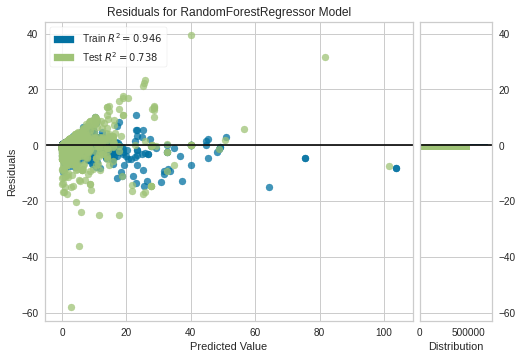

In [20]:
plot_model(rfr, 'residuals')

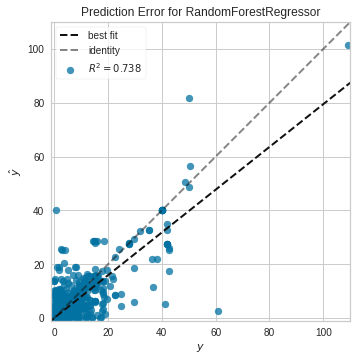

In [21]:
plot_model(rfr, 'error')

In [23]:
salvar_experi([rfr])

Transformation Pipeline and Model Successfully Saved


['20220128_033247.pkl', '20220128_033247_1_RandomForestRegressor']

In [24]:
list(Path().glob('20220128_033247*.pkl'))

[PosixPath('20220128_033247.pkl'),
 PosixPath('20220128_033247_1_RandomForestRegressor.pkl')]

<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### F.4 - Seleção de 5 variáveis categóricas e 4 variáveis numéricas COM opções de pré-processamento

- `categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]`
- `numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', ]`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Escolha, classificação e conferência das variáveis.

In [21]:
target = 'o_unpr'
categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]
numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', ]
ignore_features = [
    'grp_cor', 'c_tp', 'grp_dim', # cat
    'p_dv', 'o_qtty', 'o_ttdv', 'o_ttwt', # num
    'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr', # sempre
]
teste_features(df_vendas_bricks.columns, target, 
               categorical_features, numeric_features, ignore_features)

True --> set(cate).isdisjoint( set(nume) )
True --> set(nume).isdisjoint( set(igno) )
True --> set(igno).isdisjoint( set(cate) )
True --> alvo not in ( set(cate) | set(nume) | set(igno) )
True --> set(todas) == ( {alvo} | set(cate) | set(nume) | set(igno) )


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [22]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    combine_rare_levels=True, rare_level_threshold=0.1, 
    ignore_low_variance=True, 
    remove_multicollinearity=True, # multicollinearity_threshold=..., 
)

In [23]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 304)"


CPU times: user 1min 5s, sys: 30.4 s, total: 1min 35s
Wall time: 58.2 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [24]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'p_dv', 'o_qtty', 'o_ttdv', 'o_ttwt', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
combine_rare_levels|True
rare_level_threshold|0.1
ignore_low_variance|True
remove_multicollinearity|True

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [25]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0454,0.0925,0.3041,0.7275,0.0683,0.3759
1,0.0451,0.0548,0.2342,0.7380,0.0675,0.3781
2,0.0460,0.0640,0.2530,0.7180,0.0687,0.3728
3,0.0460,0.0920,0.3033,0.7260,0.0679,0.3910
4,0.0456,0.0668,0.2584,0.6897,0.0690,0.3844
Mean,0.0456,0.0740,0.2706,0.7198,0.0683,0.3804
SD,0.0004,0.0154,0.0282,0.0163,0.0005,0.0065


CPU times: user 4h 24min 42s, sys: 25.2 s, total: 4h 25min 8s
Wall time: 43min 44s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### F.5 - Seleção de 5 variáveis categóricas e 5 variáveis numéricas COM opções de pré-processamento

- `categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]`
- `numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt', ]`

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Escolha, classificação e conferência das variáveis.

In [27]:
target = 'o_unpr'
categorical_features = ['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr', ]
numeric_features = ['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt', ]
ignore_features = [
    'grp_cor', 'c_tp', 'grp_dim', # cat
    'p_dv', 'o_qtty', 'o_ttdv', # num
    'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr', # sempre
]
teste_features(df_vendas_bricks.columns, target, 
               categorical_features, numeric_features, ignore_features)

True --> set(cate).isdisjoint( set(nume) )
True --> set(nume).isdisjoint( set(igno) )
True --> set(igno).isdisjoint( set(cate) )
True --> alvo not in ( set(cate) | set(nume) | set(igno) )
True --> set(todas) == ( {alvo} | set(cate) | set(nume) | set(igno) )


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Configuração da regressão com PyCaret.

In [28]:
dct_setup_1 = dict(
    session_id=0, data=df_vendas_bricks, silent=True, verbose=True, # use_gpu=True, 
)

dct_setup_2 = dict(
    target=target, categorical_features=categorical_features, 
    numeric_features=numeric_features, ignore_features=ignore_features, 
)

dct_setup_3 = dict(  
    train_size = 0.6, fold=5,
    combine_rare_levels=True, rare_level_threshold=0.1, 
    ignore_low_variance=True, 
    remove_multicollinearity=True, # multicollinearity_threshold=..., 
)

In [29]:
%%time
cfg_regress_2 = setup(**{**dct_setup_1, **dct_setup_2, **dct_setup_3})

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 24)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 305)"


CPU times: user 1min 2s, sys: 31 s, total: 1min 33s
Wall time: 56.5 s


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Quadro resumo dos principais parâmetros do experimento.

In [30]:
d_dct({**dct_setup_2, **dct_setup_3}, tit_chave='parâmetro setup')
# d_dct(dct_compare_models, tit_chave='parâmetro compare_models')

parâmetro setup|valor
:--|:--
target|'o_unpr'
categorical_features|['p_no', 'c_id', 'n_u', 'o_sctr', 'o_bctr']
numeric_features|['p_wt', 'p_dx', 'p_dy', 'p_dz', 'o_ttwt']
ignore_features|['grp_cor', 'c_tp', 'grp_dim', 'p_dv', 'o_qtty', 'o_ttdv', 'o_dthr', 'p_nm', 'p_pfx', 'p_sfx', 'c_nm', 'c_cd', 'o_ttpr']
train_size|0.6
fold|5
combine_rare_levels|True
rare_level_threshold|0.1
ignore_low_variance|True
remove_multicollinearity|True

<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [31]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0480,0.0944,0.3072,0.7218,0.0705,0.3934
1,0.0477,0.0566,0.2380,0.7294,0.0705,0.3966
2,0.0482,0.0620,0.2491,0.7266,0.0710,0.3886
3,0.0484,0.0884,0.2974,0.7366,0.0699,0.4117
4,0.0479,0.0648,0.2546,0.6986,0.0709,0.4018
Mean,0.0481,0.0733,0.2693,0.7226,0.0705,0.3984
SD,0.0002,0.0152,0.0277,0.0129,0.0004,0.0079


CPU times: user 4h 39min 55s, sys: 35.1 s, total: 4h 40min 30s
Wall time: 41min 57s


<hr style="background-color:transparent;height:4px;border:none;border-top:2px solid #c0c0c0;border-bottom:2px solid #c0c0c0;">

### G - Testes de pré-processamento com PyCaret COM seleção manual de variáveis transformadas do experimento de referência

- *Datasets* montados a partir do *dataset* transformado resultante do pré-processamento do experimento de referência (D.1) e das listas de importâncias das variáveis do *dataset* transformado do experimento de referência (D.1).
- Manutenção de configurações do experimento de referência:
    - *train size* de 60% ;
    - *cross validation* com 5 *folds* .
- Utilização do modelo com melhor desempenho no experimento de referência: *Random Forest Regressor*.
- Principais parâmetros dos experimentos nos quadros resumos.

<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### G.1 - Seleção de variáveis transformadas do experimento de referência com *feature importance* > 0,01

- Configurações com valor padrão exceto `train_size=0.6` e `fold=5` .

In [60]:
cols_feat_impo = importance_01 + ['o_unpr']
cfg_regress_3 = setup(
    session_id=0, data=df_vendas_bricks_2[cols_feat_impo], target='o_unpr', 
    train_size=0.6, fold=5
)

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 22)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,15
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 21)"


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [61]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0727,0.1293,0.3596,0.6189,0.0992,0.7004
1,0.0730,0.1167,0.3416,0.4425,0.1009,0.6886
2,0.0730,0.1107,0.3327,0.5121,0.1001,0.6851
3,0.0736,0.1648,0.4060,0.5091,0.1010,0.7081
4,0.0723,0.0942,0.3070,0.5620,0.0994,0.6979
Mean,0.0729,0.1232,0.3494,0.5289,0.1001,0.6961
SD,0.0004,0.0237,0.0330,0.0589,0.0007,0.0083


CPU times: user 13min 46s, sys: 25.3 s, total: 14min 12s
Wall time: 2min 20s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### G.2 - Seleção de variáveis transformadas do experimento de referência com *feature importance* > 0,001

- Configurações com valor padrão exceto `train_size=0.6` e `fold=5` .

In [68]:
cols_feat_impo = importance_001 + ['o_unpr']
cfg_regress_3 = setup(
    session_id=0, data=df_vendas_bricks_2[cols_feat_impo], target='o_unpr', 
    train_size=0.6, fold=5
)

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 87)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,78
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 86)"


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [69]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0556,0.1075,0.3278,0.6832,0.0787,0.4915
1,0.0554,0.0604,0.2457,0.7116,0.0796,0.4925
2,0.0556,0.0640,0.2531,0.7178,0.0787,0.4844
3,0.0561,0.0992,0.3150,0.7045,0.0790,0.5075
4,0.0555,0.0684,0.2615,0.6821,0.0791,0.4964
Mean,0.0556,0.0799,0.2806,0.6998,0.0790,0.4944
SD,0.0002,0.0195,0.0339,0.0147,0.0003,0.0076


CPU times: user 1h 8min 13s, sys: 40.4 s, total: 1h 8min 53s
Wall time: 11min 13s


<hr style="background-color:transparent;height:0px;border:none;border-top:2px solid #c0c0c0;">

#### G.3 - Seleção de variáveis transformadas do experimento de referência com *feature importance* > 0,0001

- Configurações com valor padrão exceto `train_size=0.6` e `fold=5` .

In [72]:
cols_feat_impo = importance_0001 + ['o_unpr']
cfg_regress_3 = setup(
    session_id=0, data=df_vendas_bricks_2[cols_feat_impo], target='o_unpr', 
    train_size=0.6, fold=5
)

,Description,Value
0,session_id,0
1,Target,o_unpr
2,Original Data,"(1291936, 178)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,169
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775161, 177)"


<hr style="height:0px;border:none;border-top:1px solid #c0c0c0;">

- Comparação dos resultados de *cross validation* dos modelos treinados com PyCaret.

In [73]:
%%time
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0498,0.1094,0.3308,0.6775,0.0734,0.4084
1,0.0493,0.0667,0.2583,0.6812,0.0725,0.4098
2,0.0500,0.0761,0.2758,0.6648,0.0735,0.4034
3,0.0504,0.1007,0.3173,0.7002,0.0735,0.4277
4,0.0496,0.0703,0.2651,0.6734,0.0729,0.4159
Mean,0.0498,0.0846,0.2894,0.6794,0.0732,0.4130
SD,0.0004,0.0171,0.0291,0.0117,0.0004,0.0084


CPU times: user 2h 34min 42s, sys: 54.5 s, total: 2h 35min 37s
Wall time: 25min 30s
